In [1]:
import os
import time
import pickle
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings
import torch
import torch.optim as optim

from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, TimeSeriesSplit, KFold, StratifiedKFold
from category_encoders import TargetEncoder, OneHotEncoder
from math import sqrt
from datetime import datetime

In [2]:
from src.utils import check_stationarity, get_scaler, get_sample_weight, load_word2vec_embeddings, get_torch_optimizer, dummy_lagged_df
from src.arima import grid_search_arima
from src.sarimax import grid_search_sarimax
from src.ml_model import grid_search_ml, get_model, one_step_prediction as one_step_ml_prediction
from src.rnn import load_data, load_data_forecast, train_rnn, eval_rnn, one_step_prediction, grid_search_rnn, TimeSeriesDataset, ForecastModel

# Forecasting FX
## Baseline of simple ARIMA 
Last 4 years as test

In [3]:
imputed_dir = './data/imputed/'

In [4]:
aus_df = pd.read_csv(os.path.join(imputed_dir, 'Austria.csv'))
aus_df['Date'] = pd.to_datetime(aus_df['Date'])
aus_df = aus_df.set_index('Date')

In [5]:
candidates = ['GDPPerCap', 'GDP', 'Population', 'GDPRatioChina', 'GDPPerCapRatioChina', 'GDPGrowthDiffChina', 'GDPPerCapGrowthDiffChina']
target = 'FXAgainstChina'

train_df = aus_df[[target] + candidates].dropna()
train_x, train_y = train_df[candidates], train_df[target]
# train_x, test_x, train_y, test_y = train_test_split(train_x, train_y, test_size=0.2)
train_x, test_x, train_y, test_y = train_x.iloc[:-4*12], train_x.iloc[-4*12:], train_y.iloc[:-4*12], train_y.iloc[-4*12:]
scaler = StandardScaler()
train_x = scaler.fit_transform(train_x)
test_x = scaler.transform(test_x)

In [6]:
len(test_y) / (len(train_y) + len(test_y))

0.11566265060240964

/scratch/zt00296/Projects/tourism-forecasting/src/utils.py:45: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y, bins=int(sqrt(len(y))), ax=ax4)



The Test Statistics is lower than the Critical Value of 5%.
The series seems to be stationary


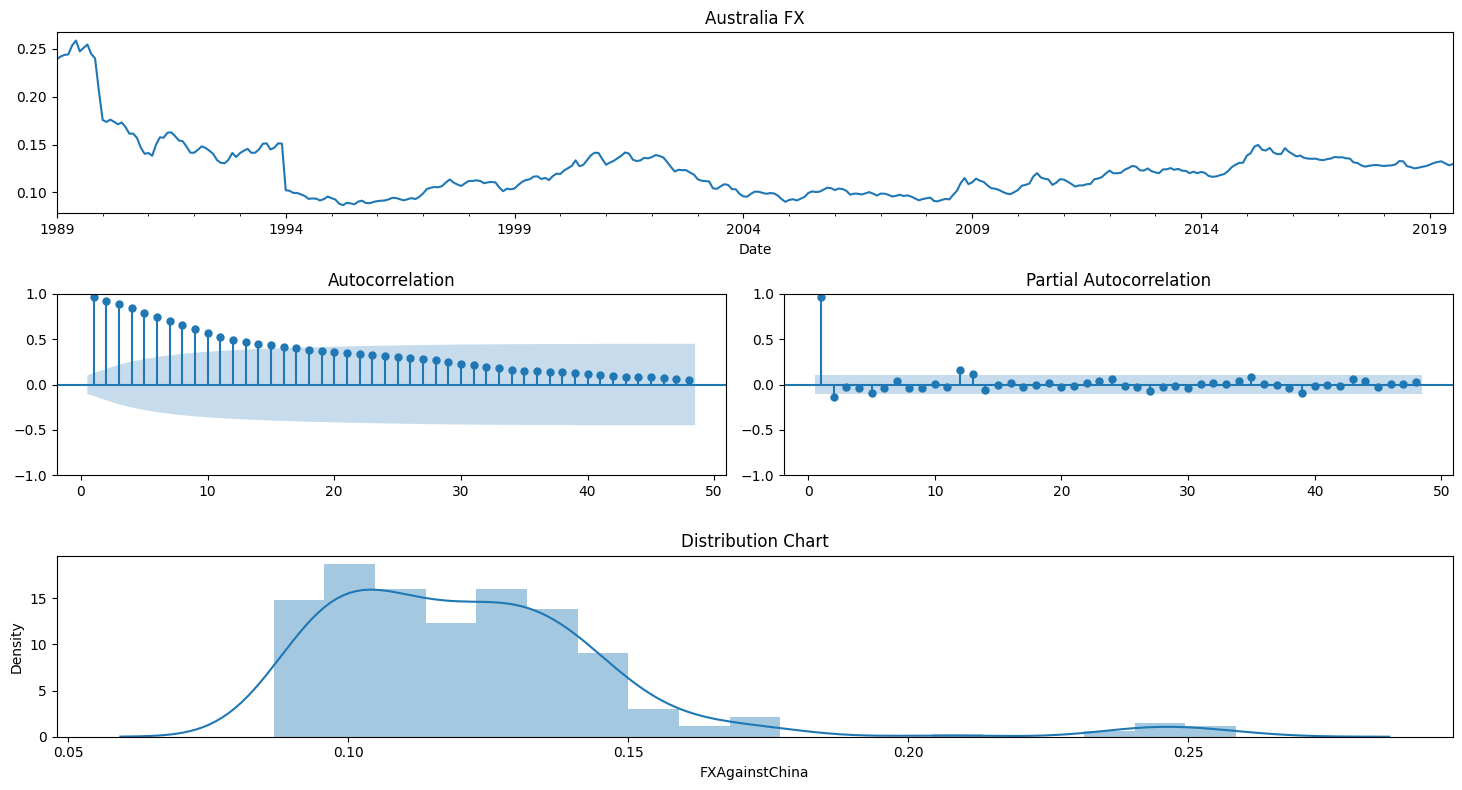

In [7]:
# find parameter analytically
check_stationarity(train_y, title='Australia FX')

(2, 0, 2) 0.010754555100356035


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


RMSE: 0.007087831605854153
R2 -0.2925597067465242


<Axes: xlabel='Date'>

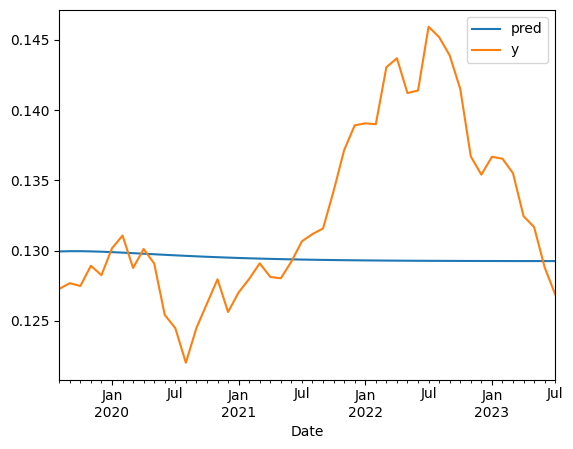

In [8]:
best_param, best_rmse = grid_search_arima(train_y, param_grids={'p': range(0, 3), 'q': range(0, 2), 'r': range(0, 3)})
print(best_param, best_rmse)
arima_model = sm.tsa.arima.ARIMA(train_y, order=best_param)
result = arima_model.fit()
pred = result.forecast(len(test_y))
print('RMSE:', sqrt(mean_squared_error(test_y, pred)))
print('R2', r2_score(test_y, pred))
pd.concat([pd.Series(pred, name='pred', index=test_y.index), pd.Series(test_y, name='y')], axis=1).plot()

In [9]:
# repeat for all countries
arima_pred, all_y = [], []
for f in os.listdir(imputed_dir):
    if f.endswith('.csv'):
        print('processing', f)
        df = pd.read_csv(os.path.join(imputed_dir, f))
        df['Date'] = pd.to_datetime(df['Date'])
        # df = df[df['Date'] < '2020-01-01']
        df = df.set_index('Date')
        train_y = df[target].dropna()
        train_y, test_y = train_y.iloc[:-4*12], train_y.iloc[-4*12:]
        best_param, best_rmse = grid_search_arima(train_y, param_grids={'p': range(0, 3), 'q': range(0, 2), 'r': range(0, 3)})
        print(best_param, best_rmse)
        arima_model = sm.tsa.arima.ARIMA(train_y, order=best_param)
        result = arima_model.fit()
        pred = result.forecast(len(test_y))
        arima_pred.append(pred)
        all_y.append(test_y)
arima_pred, all_y = pd.concat(arima_pred).values, pd.concat(all_y).values

processing Japan.csv
(2, 1, 2) 1.454005489246675
processing Korea (ROK).csv


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


(1, 1, 0) 13.130918380307051
processing Chile.csv


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


(1, 1, 1) 9.749269874096619
processing Maldives.csv


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


(2, 1, 2) 0.1623776296068084
processing Cambodia.csv


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 1, 2) 53.927348549503016
processing Singapore.csv


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/scratch/zt00296/.conda/envs/tourism/li

(1, 1, 0) 0.008716954476503645
processing USA.csv


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


(2, 0, 0) 0.008356492354161022
processing Chinese Taipei.csv


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


(1, 1, 0) 0.2387065062365313
processing Thailand.csv


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


(2, 0, 2) 0.26887438916078404
processing Indonesia.csv


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/scratch/zt00296/.conda/envs/tourism/li

(1, 1, 1) 188.3668194553487
processing Turkey.csv


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


(2, 1, 2) 0.10380357103946375
processing Macao, China.csv


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


(0, 1, 0) 0.08281105754308976
processing Australia.csv


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


(1, 1, 0) 0.026858786425543037
processing New Zealand.csv


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


(1, 1, 0) 0.03545720404552749
processing Czech.csv


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


(2, 1, 1) 0.5589730415847054
processing Hawaii.csv


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


(2, 0, 0) 0.008356492354161022
processing Mexico.csv


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


(2, 1, 2) 0.28077416464514093
processing Hong Kong SAR.csv


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


(1, 1, 2) 0.061774508362667874
processing Canada.csv


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


(1, 1, 0) 0.015833891714404337
processing Austria.csv


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


(2, 0, 2) 0.010754555100356035


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


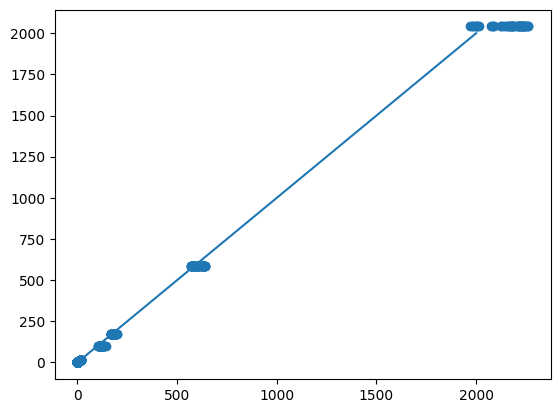

In [10]:
plt.scatter(all_y, arima_pred)
plt.plot((0, 2000), (0, 2000))

In [11]:
baseline_rmse = sqrt(mean_squared_error(all_y, arima_pred))
baseline_r2 = r2_score(all_y, arima_pred)
print(f'Baseline ARIMA RMSE: {baseline_rmse:.5f}\nBaseline ARIMA R2: {baseline_r2:.5f}')

Baseline ARIMA RMSE: 33.69119
Baseline ARIMA R2: 0.99506


# ARIMAX

In [12]:
candidates = ['GDPPerCap', 'GDP', 'Population', 'GDPRatioChina', 'GDPPerCapRatioChina', 'GDPGrowthDiffChina', 'GDPPerCapGrowthDiffChina']
target = 'FXAgainstChina'

train_df = aus_df[[target] + candidates].dropna()
train_x, train_y = train_df[candidates], train_df[target]
# train_x, test_x, train_y, test_y = train_test_split(train_x, train_y, test_size=0.2)
train_x, test_x, train_y, test_y = train_x.iloc[:-4*12], train_x.iloc[-4*12:], train_y.iloc[:-4*12], train_y.iloc[-4*12:]
# scaler = StandardScaler()
# train_x = scaler.fit_transform(train_x)
# test_x = scaler.transform(test_x)

(0, 1, 0)
RMSE: 0.007135665129258819
R2 -0.31006472552651276


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<Axes: xlabel='Date'>

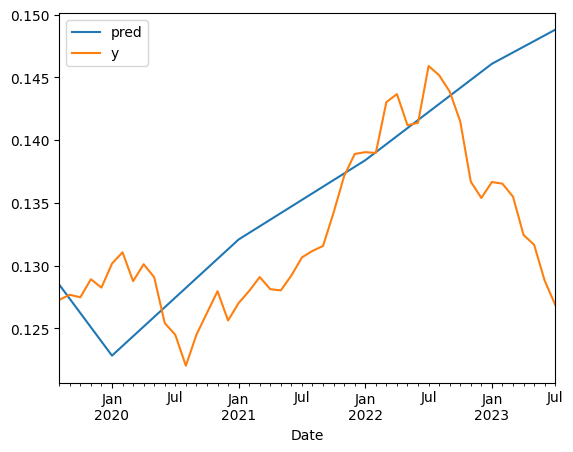

In [13]:
best_param, best_rmse = grid_search_arima(train_y, train_x, param_grids={'p': range(0, 3), 'q': range(0, 2), 'r': range(0, 3)})
print(best_param)
arimax_model = sm.tsa.arima.ARIMA(train_y, train_x, order=best_param)
result = arimax_model.fit()
pred = result.forecast(len(test_y), exog=test_x)
print('RMSE:', sqrt(mean_squared_error(test_y, pred)))
print('R2', r2_score(test_y, pred))
pd.concat([pd.Series(pred, name='pred', index=test_y.index), pd.Series(test_y, name='y')], axis=1).plot()

In [14]:
# repeat for all countries
arimax_pred, all_y = [], []
for f in os.listdir(imputed_dir):
    if f.endswith('.csv'):
        print('processing', f)
        df = pd.read_csv(os.path.join(imputed_dir, f))
        df['Date'] = pd.to_datetime(df['Date'])
        # df = df[df['Date'] < '2020-01-01']
        df = df.set_index('Date')
        train_df = df[[target] + candidates].dropna()
        train_x, train_y = train_df[candidates], train_df[target]
        train_x, test_x, train_y, test_y = train_x.iloc[:-4*12], train_x.iloc[-4*12:], train_y.iloc[:-4*12], train_y.iloc[-4*12:]
        best_param, best_rmse = grid_search_arima(train_y, train_x, param_grids={'p': range(0, 3), 'q': range(0, 2), 'r': range(0, 3)})
        print(best_param, best_rmse)
        arimax_model = sm.tsa.arima.ARIMA(train_y, train_x, order=best_param)
        result = arimax_model.fit()
        pred = result.forecast(len(test_y), exog=test_x)
        arimax_pred.append(pred)
        all_y.append(test_y)
arimax_pred, all_y = pd.concat(arimax_pred).values, pd.concat(all_y).values

processing Japan.csv
(1, 1, 0) 3.717894329118389
processing Korea (ROK).csv


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 1, 2) 35.85477837943288
processing Chile.csv


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 0, 0) 37.7846844288286
processing Maldives.csv


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 1, 2) 0.1940648821805819
processing Cambodia.csv


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 0, 0) 329.08050539998925
processing Singapore.csv


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 1, 2) 0.0831348411894802
processing USA.csv


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site

(1, 1, 0) 0.03145994292117625
processing Chinese Taipei.csv


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 1, 0) 2.4862425525142133
processing Thailand.csv


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 0, 0) 1.6700654073514187
processing Indonesia.csv


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 0, 0) 339.8683798958724
processing Turkey.csv


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 0, 0) 0.11806477356655457
processing Macao, China.csv


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 0, 0) 1.2791119593773264
processing Australia.csv


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 0, 0) 0.09867226651238124
processing New Zealand.csv


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 0, 2) 0.09010349500246892
processing Czech.csv


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/scratch/zt00296/.conda/envs/tourism/li

(1, 0, 1) 1.5730181007887798
processing Hawaii.csv


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 1, 1) 0.010341315198065582
processing Mexico.csv


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 0, 2) 0.2540918961583991
processing Hong Kong SAR.csv


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/scratch/zt00296/.conda/envs/tourism/li

(2, 1, 2) 0.21548695314590022
processing Canada.csv


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(0, 1, 0) 0.05802356808424516
processing Austria.csv


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(0, 1, 0) 0.04791904533246441


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


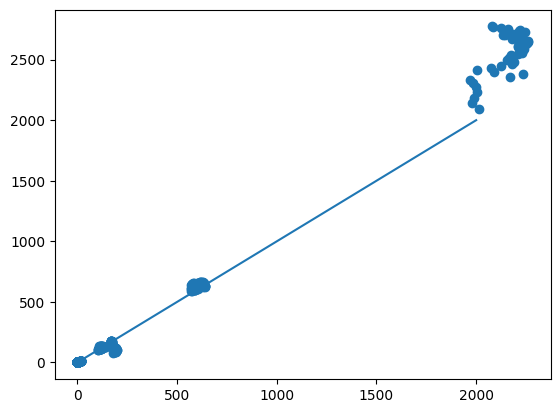

In [15]:
plt.scatter(all_y, arimax_pred)
plt.plot((0, 2000), (0, 2000))

In [16]:
arimax_rmse = sqrt(mean_squared_error(all_y, arimax_pred))
arimax_r2 = r2_score(all_y, arimax_pred)
print(f'Baseline ARIMAX RMSE: {arimax_rmse:.5f}\nBaseline ARIMAX R2: {arimax_r2:.5f}')

Baseline ARIMAX RMSE: 93.69237
Baseline ARIMAX R2: 0.96177


# SARIMA

In [12]:
candidates = ['GDPPerCap', 'GDP', 'Population', 'GDPRatioChina', 'GDPPerCapRatioChina', 'GDPGrowthDiffChina', 'GDPPerCapGrowthDiffChina']
target = 'FXAgainstChina'

train_df = aus_df[[target] + candidates].dropna()
train_x, train_y = train_df[candidates], train_df[target]
# train_x, test_x, train_y, test_y = train_test_split(train_x, train_y, test_size=0.2)
train_x, test_x, train_y, test_y = train_x.iloc[:-4*12], train_x.iloc[-4*12:], train_y.iloc[:-4*12], train_y.iloc[-4*12:]
scaler = StandardScaler()
train_x = scaler.fit_transform(train_x)
test_x = scaler.transform(test_x)

[(0, 0, 0), (1, 0, 0, 12), 'c'] 0.005436103285490503


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


RMSE: 0.005436103285490503
R2 0.23967506946197148


<Axes: xlabel='Date'>

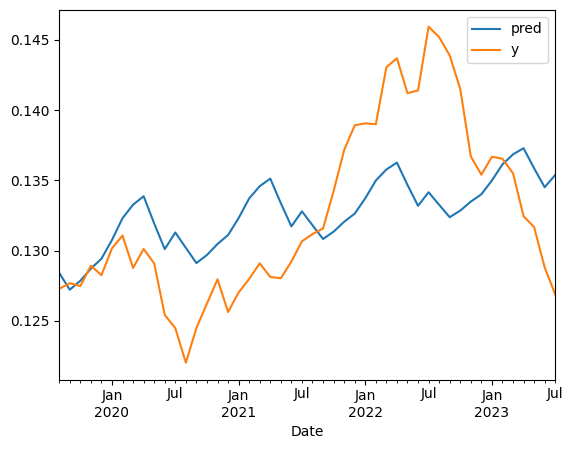

In [13]:
best_param, best_rmse, best_r2 = grid_search_sarimax(train_y, test_y, init_repeat=False, param_grids={'p': range(0, 3), 'q': range(0, 2), 'r': range(0, 3)})
print(best_param, best_rmse)
sarima_model = sm.tsa.statespace.SARIMAX(train_y, order=best_param[0], seasonal_order=best_param[1], trend=best_param[2])
result = sarima_model.fit(disp=False)
pred = result.forecast(len(test_y))
print('RMSE:', sqrt(mean_squared_error(test_y, pred)))
print('R2', r2_score(test_y, pred))
pd.concat([pd.Series(pred, name='pred', index=test_y.index), pd.Series(test_y, name='y')], axis=1).plot()

In [14]:
# repeat for all countries
sarima_pred, all_y = [], []
for f in os.listdir(imputed_dir):
    if f.endswith('.csv'):
        print('processing', f)
        df = pd.read_csv(os.path.join(imputed_dir, f))
        df['Date'] = pd.to_datetime(df['Date'])
        # df = df[df['Date'] < '2020-01-01']
        df = df.set_index('Date')
        train_y = df[target].dropna()
        train_y, test_y = train_y.iloc[:-4*12], train_y.iloc[-4*12:]
        best_param, best_rmse, best_r2 = grid_search_sarimax(train_y, test_y, init_repeat=False, param_grids={'p': range(0, 3), 'q': range(0, 2), 'r': range(0, 3)})
        print(best_param, best_rmse, best_r2)
        sarima_model = sm.tsa.statespace.SARIMAX(train_y, order=best_param[0], seasonal_order=best_param[1], trend=best_param[2])
        result = sarima_model.fit(disp=False)
        pred = result.forecast(len(test_y))
        sarima_pred.append(pred)
        all_y.append(test_y)
sarima_pred, all_y = pd.concat(sarima_pred).values, pd.concat(all_y).values

processing Japan.csv
[(1, 1, 0), (0, 1, 1, 12), 'c'] 0.885307777209198 None


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


processing Korea (ROK).csv
[(1, 1, 0), (1, 1, 0, 12), 'c'] 5.7967455823793905 None
processing Chile.csv


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


[(0, 1, 2), (0, 1, 0, 12), 'c'] 13.13586183955123 None
processing Maldives.csv


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


[(0, 0, 0), (0, 1, 0, 12), 'n'] 0.09859053854368247 None
processing Cambodia.csv


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


[(0, 0, 1), (1, 1, 1, 12), 'n'] 24.261415973033817 None


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


processing Singapore.csv
[(1, 0, 1), (1, 1, 1, 12), 'n'] 0.007231266903346869 None


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


processing USA.csv
[(0, 0, 0), (0, 0, 1, 12), 'c'] 0.005376147816357612 None
processing Chinese Taipei.csv


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


[(0, 0, 0), (0, 0, 0, 12), 'c'] 0.09708230260182105 None
processing Thailand.csv


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


[(2, 1, 1), (1, 1, 1, 12), 'c'] 0.26060335110503324 None


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


processing Indonesia.csv
[(1, 1, 0), (1, 1, 1, 12), 'n'] 73.58963785493161 None


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


processing Turkey.csv
[(2, 1, 2), (1, 1, 0, 12), 'c'] 0.832034167147965 None


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


processing Macao, China.csv
[(0, 0, 0), (0, 0, 1, 12), 'c'] 0.043824345159825716 None
processing Australia.csv


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


[(2, 0, 2), (0, 0, 0, 12), 'c'] 0.00653477850574442 None


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


processing New Zealand.csv
[(2, 0, 2), (1, 0, 0, 12), 'c'] 0.006680254804279749 None


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


processing Czech.csv
[(2, 1, 1), (0, 0, 0, 12), 'n'] 0.13670651951501223 None
processing Hawaii.csv


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


[(0, 0, 0), (0, 0, 1, 12), 'c'] 0.005376147816357612 None
processing Mexico.csv


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


[(1, 0, 2), (1, 1, 0, 12), 'n'] 0.2615327576116882 None


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


processing Hong Kong SAR.csv
[(0, 0, 0), (0, 0, 1, 12), 'c'] 0.040023652515036 None
processing Canada.csv


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


[(1, 0, 1), (1, 0, 1, 12), 'c'] 0.003982608800481525 None


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


processing Austria.csv
[(0, 0, 0), (1, 0, 0, 12), 'c'] 0.005436103285490503 None


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


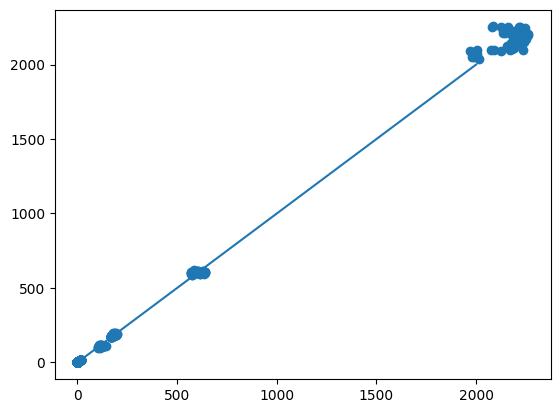

In [15]:
plt.scatter(all_y, sarima_pred)
plt.plot((0, 2000), (0, 2000))

In [16]:
sarima_rmse = sqrt(mean_squared_error(all_y, sarima_pred))
sarima_r2 = r2_score(all_y, sarima_pred)
print(f'Baseline SARIMA RMSE: {sarima_rmse:.5f}\nBaseline SARIMA R2: {sarima_r2:.5f}')

Baseline SARIMA RMSE: 17.62365
Baseline SARIMA R2: 0.99865


## Regression

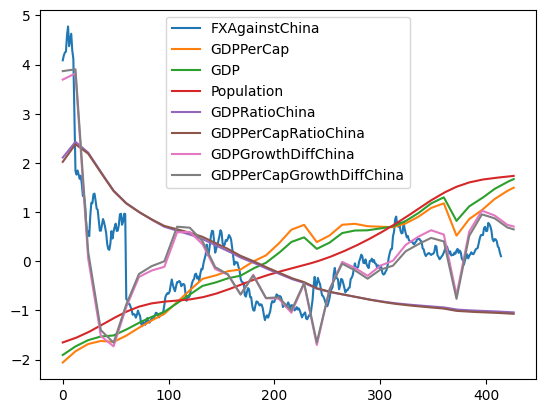

Pearson: -0.284104511203557
Kendall: 0.0533735332464146
Spearman: 0.01313086905572701


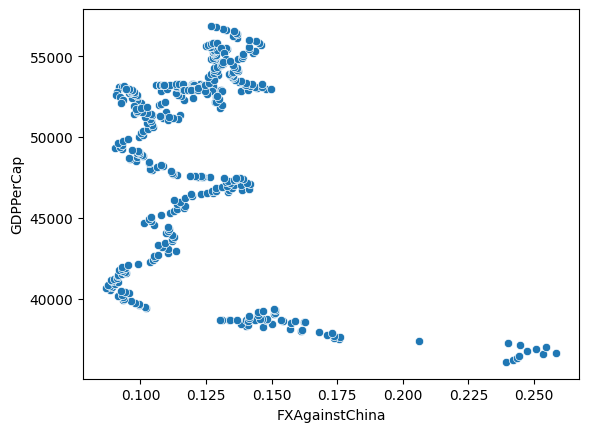

Pearson: -0.22082280511735014
Kendall: 0.08644483118027328
Spearman: 0.04373354806070221


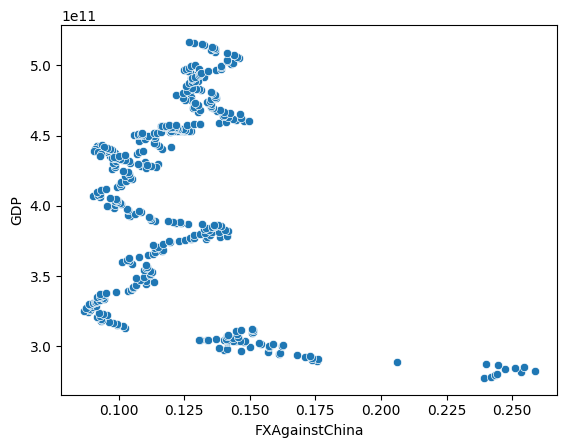

Pearson: -0.11295714304762274
Kendall: 0.09275416305472899
Spearman: 0.048153737363909585


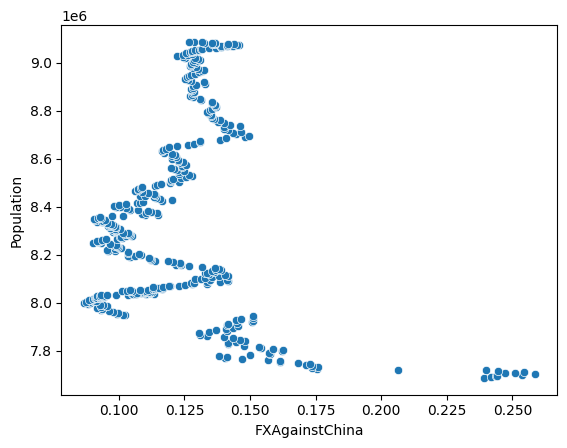

Pearson: 0.37421897993174985
Kendall: -0.0952685831375379
Spearman: -0.04851135514093817


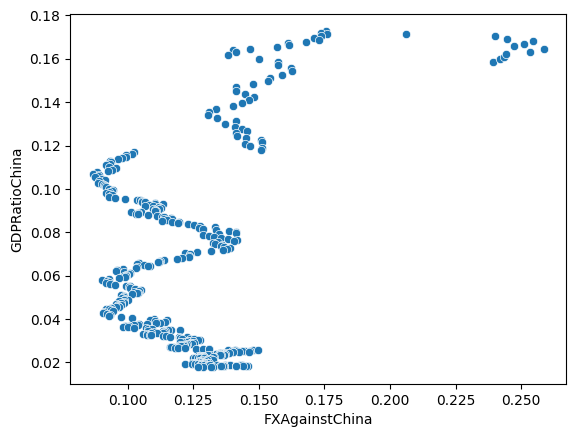

Pearson: 0.357341789430969
Kendall: -0.09575749815363964
Spearman: -0.048632407918984


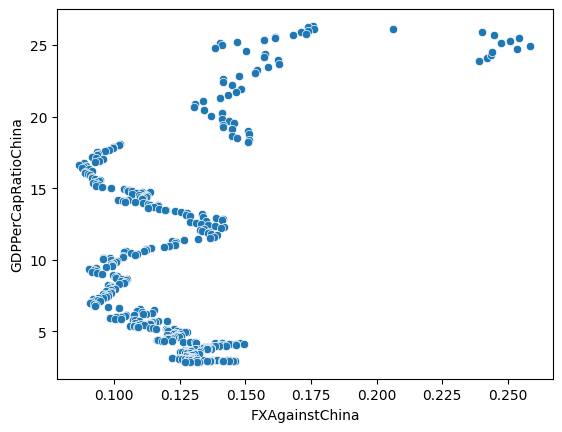

Pearson: 0.6702868208993422
Kendall: 0.28992660454832836
Spearman: 0.39731838714886286


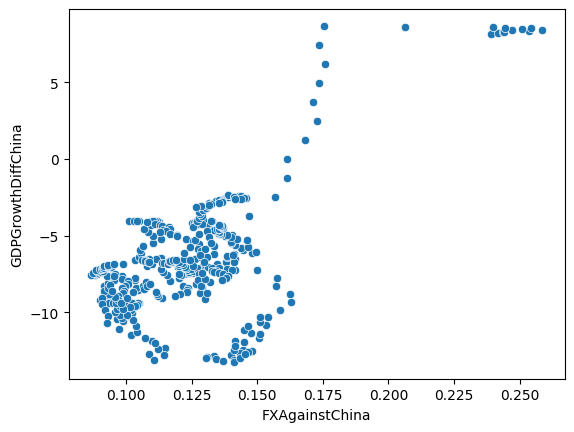

Pearson: 0.6750371544311575
Kendall: 0.2588921418595849
Spearman: 0.36339170911873736


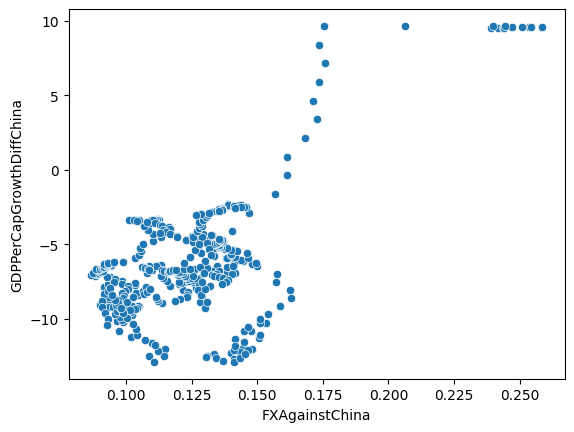

In [17]:
candidates = ['GDPPerCap', 'GDP', 'Population', 'GDPRatioChina', 'GDPPerCapRatioChina', 'GDPGrowthDiffChina', 'GDPPerCapGrowthDiffChina']
target = 'FXAgainstChina'
aus_df['Year'] = aus_df.index.year
pd.DataFrame(StandardScaler().fit_transform(aus_df[[target] + candidates]), columns=[target] + candidates).plot()
plt.show()
for candidate in candidates:
    print('Pearson:', aus_df[target].corr(aus_df[candidate]))
    print('Kendall:', aus_df[target].corr(aus_df[candidate], method='kendall'))
    print('Spearman:', aus_df[target].corr(aus_df[candidate], method='spearman'))
    sns.scatterplot(aus_df, x=target, y=candidate)
    plt.show()

In [18]:
train_df = aus_df[[target] + candidates].dropna()
train_x, train_y = train_df[candidates], train_df[target]

train_y, train_x, _ = dummy_lagged_df(train_y, train_x, lag=3)

# train_x, test_x, train_y, test_y = train_test_split(train_x, train_y, test_size=0.2)
train_x, test_x, train_y, test_y = train_x.iloc[:-4*12], train_x.iloc[-4*12:], train_y.iloc[:-4*12], train_y.iloc[-4*12:]

In [19]:
# sample_weight = get_sample_weight(0.5, 1.0, len(train_x))
best_param, best_rmse = grid_search_ml(train_x, train_y, #sample_weight=sample_weight,
                                         additional_params={'rf': [{'n_estimators': n} for n in (3, 5, 10, 50, 100)],
                                                            'mlp': [{'hidden_layer_sizes': n} for n in (1, 2, 3, 5, 10)],
                                                            'xgb': [{'n_estimators': n} for n in (3, 5, 10, 50, 100)]})
best_param, best_rmse

(('ridge',
  'standard',
  {'alpha_per_target': False,
   'alphas': (0.1, 0.25, 0.5, 1.0, 5.0, 10.0),
   'cv': None,
   'fit_intercept': True,
   'gcv_mode': None,
   'scoring': None,
   'store_cv_values': False}),
 0.0037750017590010773)

RMSE: 0.00199
R2: 0.89840


<Axes: xlabel='Date'>

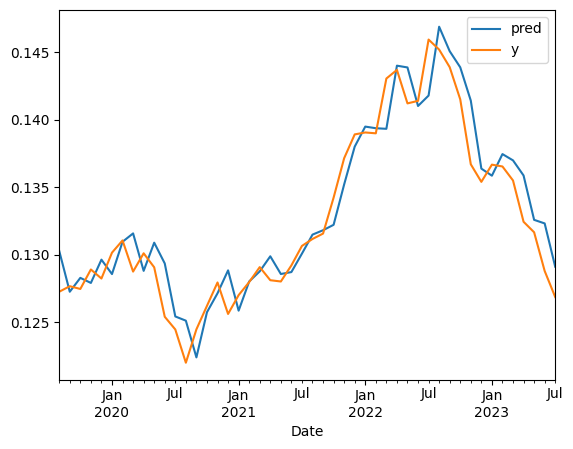

In [20]:
model = get_model(best_param[0])
model = model.set_params(**best_param[2])
scaler = get_scaler(best_param[1])
train_x_ = scaler.fit_transform(train_x)
test_x_ = scaler.transform(test_x)
model.fit(train_x_, train_y, )#sample_weight=sample_weight)
pred = model.predict(test_x_)
linear_r2 = r2_score(test_y, pred)
linear_rmse = sqrt(mean_squared_error(test_y, pred))
print(f'RMSE: {linear_rmse:.5f}\nR2: {linear_r2:.5f}')

pd.concat([pd.Series(pred, name='pred', index=test_y.index), pd.Series(test_y, name='y')], axis=1).plot()

In [21]:
# repeat for all countries
reg_pred, all_y = [], []
for f in os.listdir(imputed_dir):
    if f.endswith('.csv'):
        print('processing', f)
        df = pd.read_csv(os.path.join(imputed_dir, f))
        df['Date'] = pd.to_datetime(df['Date'])
        # df = df[df['Date'] < '2020-01-01']
        df = df.set_index('Date')

        train_df = df[[target] + candidates].dropna()
        train_x, train_y = train_df[candidates], train_df[target]
        
        train_y, train_x, _ = dummy_lagged_df(train_y, train_x, lag=1)

        train_x, test_x, train_y, test_y = train_x.iloc[:-4*12], train_x.iloc[-4*12:], train_y.iloc[:-4*12], train_y.iloc[-4*12:]
        # sample_weight = get_sample_weight(0.5, 1.0, len(train_x))

        best_param, best_rmse = grid_search_ml(train_x, train_y, #sample_weight=sample_weight,
                                                 additional_params={'rf': [{'n_estimators': n} for n in (5, 10, 50, 100)],
                                                                    'mlp': [{'hidden_layer_sizes': n} for n in (1, 3, 5, 10)],
                                                                    'xgb': [{'n_estimators': n} for n in (5, 10, 50, 100)]})
        print(best_param, best_rmse)
        model = get_model(best_param[0])
        model = model.set_params(**best_param[2])
        scaler = get_scaler(best_param[1])
        train_x_ = scaler.fit_transform(train_x)
        test_x_ = scaler.transform(test_x)
        model.fit(train_x_, train_y,)# sample_weight=sample_weight)
        pred = model.predict(test_x_)
        reg_pred.append(pred)
        all_y.append(test_y)
reg_pred, all_y = np.concatenate(reg_pred), pd.concat(all_y).values

processing Japan.csv
('elastic', 'standard', {'alphas': None, 'copy_X': True, 'cv': None, 'eps': 0.001, 'fit_intercept': True, 'l1_ratio': [0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1.0], 'max_iter': 1000, 'n_alphas': 100, 'n_jobs': None, 'positive': False, 'precompute': 'auto', 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'verbose': 0}) 0.5386067914822968
processing Korea (ROK).csv
('elastic', 'minmax', {'alphas': None, 'copy_X': True, 'cv': None, 'eps': 0.001, 'fit_intercept': True, 'l1_ratio': [0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1.0], 'max_iter': 1000, 'n_alphas': 100, 'n_jobs': None, 'positive': False, 'precompute': 'auto', 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'verbose': 0}) 5.19145235949356
processing Chile.csv
('elastic', 'standard', {'alphas': None, 'copy_X': True, 'cv': None, 'eps': 0.001, 'fit_intercept': True, 'l1_ratio': [0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1.0], 'max_iter': 1000, 'n_alphas': 100, 'n_jobs': None, 'positive': False, 'precompute': 'auto', 

/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


('elastic', 'minmax', {'alphas': None, 'copy_X': True, 'cv': None, 'eps': 0.001, 'fit_intercept': True, 'l1_ratio': [0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1.0], 'max_iter': 1000, 'n_alphas': 100, 'n_jobs': None, 'positive': False, 'precompute': 'auto', 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'verbose': 0}) 14.75232936781416
processing Singapore.csv
('elastic', 'standard', {'alphas': None, 'copy_X': True, 'cv': None, 'eps': 0.001, 'fit_intercept': True, 'l1_ratio': [0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1.0], 'max_iter': 1000, 'n_alphas': 100, 'n_jobs': None, 'positive': False, 'precompute': 'auto', 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'verbose': 0}) 0.0049957644159568035
processing USA.csv
('svr', 'minmax', {'C': 1.0, 'dual': True, 'epsilon': 0.0, 'fit_intercept': True, 'intercept_scaling': 1.0, 'loss': 'epsilon_insensitive', 'max_iter': 1000, 'random_state': None, 'tol': 0.0001, 'verbose': 0}) 0.002414362167983238
processing Chinese Taipei.csv


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


('ridge', 'standard', {'alpha_per_target': False, 'alphas': (0.1, 0.25, 0.5, 1.0, 5.0, 10.0), 'cv': None, 'fit_intercept': True, 'gcv_mode': None, 'scoring': None, 'store_cv_values': False}) 0.08752329606282452
processing Thailand.csv
('elastic', 'standard', {'alphas': None, 'copy_X': True, 'cv': None, 'eps': 0.001, 'fit_intercept': True, 'l1_ratio': [0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1.0], 'max_iter': 1000, 'n_alphas': 100, 'n_jobs': None, 'positive': False, 'precompute': 'auto', 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'verbose': 0}) 0.12953937819734782
processing Indonesia.csv
('elastic', 'standard', {'alphas': None, 'copy_X': True, 'cv': None, 'eps': 0.001, 'fit_intercept': True, 'l1_ratio': [0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1.0], 'max_iter': 1000, 'n_alphas': 100, 'n_jobs': None, 'positive': False, 'precompute': 'auto', 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'verbose': 0}) 58.30125577569389
processing Turkey.csv
('ridge', 'standard', {'alpha_pe

/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


('elastic', 'standard', {'alphas': None, 'copy_X': True, 'cv': None, 'eps': 0.001, 'fit_intercept': True, 'l1_ratio': [0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1.0], 'max_iter': 1000, 'n_alphas': 100, 'n_jobs': None, 'positive': False, 'precompute': 'auto', 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'verbose': 0}) 0.006549437004249719
processing New Zealand.csv
('elastic', 'standard', {'alphas': None, 'copy_X': True, 'cv': None, 'eps': 0.001, 'fit_intercept': True, 'l1_ratio': [0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1.0], 'max_iter': 1000, 'n_alphas': 100, 'n_jobs': None, 'positive': False, 'precompute': 'auto', 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'verbose': 0}) 0.008013986793860572
processing Czech.csv
('elastic', 'standard', {'alphas': None, 'copy_X': True, 'cv': None, 'eps': 0.001, 'fit_intercept': True, 'l1_ratio': [0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1.0], 'max_iter': 1000, 'n_alphas': 100, 'n_jobs': None, 'positive': False, 'precompute': 'auto', 'random_state

/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


('ridge', 'standard', {'alpha_per_target': False, 'alphas': (0.1, 0.25, 0.5, 1.0, 5.0, 10.0), 'cv': None, 'fit_intercept': True, 'gcv_mode': None, 'scoring': None, 'store_cv_values': False}) 0.0045038295100394915
processing Austria.csv
('elastic', 'standard', {'alphas': None, 'copy_X': True, 'cv': None, 'eps': 0.001, 'fit_intercept': True, 'l1_ratio': [0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1.0], 'max_iter': 1000, 'n_alphas': 100, 'n_jobs': None, 'positive': False, 'precompute': 'auto', 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'verbose': 0}) 0.0038394278803415157


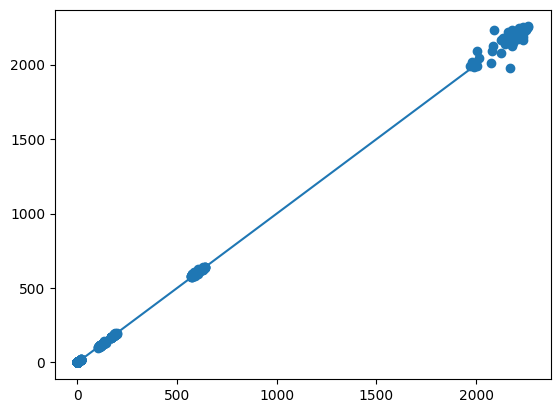

In [22]:
plt.scatter(all_y, reg_pred)
plt.plot((0, 2000), (0, 2000))

In [23]:
reg_rmse = sqrt(mean_squared_error(all_y, reg_pred))
reg_r2 = r2_score(all_y, reg_pred)
print(f'Baseline Model RMSE: {reg_rmse:.5f}\nBaseline Model R2: {reg_r2:.5f}')

Baseline Model RMSE: 10.77925
Baseline Model R2: 0.99949


# Combination Regression Model
combine all countries to train regression model

In [24]:
candidates = ['GDPPerCap', 'GDP', 'Population', 'GDPRatioChina', 'GDPPerCapRatioChina', 'GDPGrowthDiffChina', 'GDPPerCapGrowthDiffChina', 'Country']
target = 'FXAgainstChina'
comb_train, comb_test = [], []
for f in os.listdir(imputed_dir):
    if f.endswith('.csv'):
        # print('processing', f)
        df = pd.read_csv(os.path.join(imputed_dir, f))
        df['Date'] = pd.to_datetime(df['Date'])
        # df = df[df['Date'] < '2020-01-01']
        # df = df.set_index('Date')
        # df = df.resample('Y').first().reset_index(names='Date')

        df['Country'] = f.split('.')[0]
        df['Year'] = df['Date'].dt.year
        
        train_df = df[[target] + candidates].dropna()
        
        _, train_x, added_col = dummy_lagged_df(train_df[target], dropna=False, lag=1)
        train_df = pd.concat([train_df, train_x], axis=1).dropna()

        train_df, test_df = train_df.iloc[:-4*12], train_df.iloc[-4*12:]
        
        scaler = get_scaler('minmax') #scale each country stats separately
        
        temp = candidates.copy()
        temp.remove('Country')
        train_df[temp] = scaler.fit_transform(train_df[temp])
        test_df[temp] = scaler.transform(test_df[temp])
        
        comb_train.append(train_df)
        comb_test.append(test_df)
comb_train = pd.concat(comb_train, ignore_index=True)
comb_test = pd.concat(comb_test, ignore_index=True)

In [25]:
comb_train['Country'].value_counts()

Country
Japan             366
Indonesia         366
Canada            366
Hong Kong SAR     366
Mexico            366
New Zealand       366
Australia         366
Macao, China      366
Korea (ROK)       366
Austria           366
Thailand          366
Chinese Taipei    366
USA               366
Singapore         366
Maldives          366
Chile             366
Cambodia          354
Czech             318
Hawaii            258
Turkey            241
Name: count, dtype: int64

In [26]:
comb_train_x, comb_train_y = comb_train[candidates + added_col], comb_train[target]
comb_test_x, comb_test_y = comb_test[candidates + added_col], comb_test[target]

In [27]:
target_encoder = TargetEncoder(cols='Country', handle_missing='error', handle_unknown='error', min_samples_leaf=20)
comb_train_x = target_encoder.fit_transform(comb_train_x, comb_train_y)
comb_test_x = target_encoder.transform(comb_test_x)
# oh_encoder = OneHotEncoder(cols='Country', handle_missing='error', handle_unknown='error')
# comb_train_x = oh_encoder.fit_transform(comb_train_x, comb_train_y)
# comb_test_x = oh_encoder.transform(comb_test_x)


In [28]:
comb_train_x

GDPPerCap       GDP  Population  GDPRatioChina  GDPPerCapRatioChina  \
0      0.000000  0.000000    0.000000       0.911352             0.898140   
1      0.011424  0.011352    0.008348       0.919411             0.907400   
2      0.022848  0.022703    0.016696       0.927470             0.916660   
3      0.034271  0.034055    0.025044       0.935529             0.925920   
4      0.045695  0.045406    0.033392       0.943588             0.935180   
...         ...       ...         ...            ...                  ...   
7022   0.965943  0.974993    0.986758       0.004267             0.004601   
7023   0.948915  0.962490    0.990068       0.003200             0.003451   
7024   0.931887  0.949987    0.993378       0.002134             0.002300   
7025   0.914858  0.937483    0.996690       0.001067             0.001150   
7026   0.897830  0.924980    1.000000       0.000000             0.000000   

      GDPGrowthDiffChina  GDPPerCapGrowthDiffChina    Country  TargetLag1  
0               0.953540                  0.961866  16.499679   34.042108  
1               0.957764                  0.965333  16.499679   34.215966  
2               0.961987                  0.968799  16.499679   34.920539  
3               0.966211                  0.972266  16.499679   35.394164  
4               0.970435                  0.975733  16.499679   36.901598  
...                  ...                       ...        ...         ...  
7022            0.372512                  0.335331   0.122559    0.130747  
7023            0.353968                  0.317813   0.122559    0.131810  
7024            0.335425                  0.300294   0.122559    0.132471  
7025            0.316882                  0.282775   0.122559    0.130326  
7026            0.298339                  0.265257   0.122559    0.128311  

[7027 rows x 9 columns]

In [29]:
best_param, best_rmse = grid_search_ml(comb_train_x, comb_train_y, #sample_weight=sample_weight,
                                         additional_params={'rf': [{'n_estimators': n, 'max_depth': d, 'min_samples_leaf': 2} for n in (5, 10, 50, 100) for d in (3, 5, 7, 10)],
                                                            'mlp': [{'hidden_layer_sizes': n} for n in (1, 5, 10, 20)],
                                                            'xgb': [{'n_estimators': n, 'max_depth': d, #'subsample': 0.7, 'colsample_bytree': 0.7,
                                                                     'gamma': g, 'reg_alpha': ra} for n in (10, 50, 100, 200) for d in (3, 5, 7, 10) for g in (0., 0.01, 0.1) for ra in (0, 0.01, 0.05, 0.1)]})
print(best_param, best_rmse)
model = get_model(best_param[0])
model = model.set_params(**best_param[2])
scaler = get_scaler(best_param[1])
comb_train_x_ = scaler.fit_transform(comb_train_x)
comb_test_x_ = scaler.transform(comb_test_x)
model.fit(comb_train_x_, comb_train_y,)# sample_weight=sample_weight)
comb_pred = model.predict(comb_test_x_)

('svr', 'standard', {'C': 1.0, 'dual': True, 'epsilon': 0.0, 'fit_intercept': True, 'intercept_scaling': 1.0, 'loss': 'epsilon_insensitive', 'max_iter': 1000, 'random_state': None, 'tol': 0.0001, 'verbose': 0}) 8.490327575478707


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


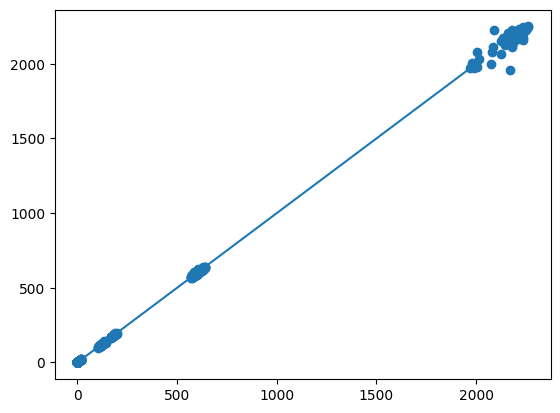

In [30]:
plt.scatter(comb_test_y, comb_pred)
plt.plot((0, 2000), (0, 2000))

In [31]:
reg_rmse = sqrt(mean_squared_error(comb_test_y, comb_pred))
reg_r2 = r2_score(comb_test_y, comb_pred)
print(f'Combination Model RMSE: {reg_rmse:.5f}\nCombination Model R2: {reg_r2:.5f}')

Combination Model RMSE: 11.17834
Combination Model R2: 0.99946


# RNN

In [32]:
candidates = ['GDPPerCap', 'GDP', 'Population', 'Country', 'GDPRatioChina', 'GDPPerCapRatioChina', 'GDPGrowthDiffChina', 'GDPPerCapGrowthDiffChina']
target = 'FXAgainstChina'
seq_len = 10

seq_train_x, seq_train_y, seq_test_x, seq_test_y, x_scaler, y_scaler, train_country = load_data(imputed_dir, candidates, target, seq_len, freq='MS', test_size=4*12, reverse=False, preprocess='minmax', single_x_scaler=False, single_y_scaler=True)
# seq_test_x = pd.concat(seq_test_x, ignore_index=True)

In [33]:
seq_test_x[-1]

GDPPerCap       GDP  Population  Country  GDPRatioChina  \
404   1.003802  1.033516    1.073872  Austria      -0.016208   
405   1.009582  1.038468    1.074804  Austria      -0.016474   
406   1.015361  1.043421    1.075735  Austria      -0.016740   
407   1.021141  1.048373    1.076666  Austria      -0.017006   
408   1.026920  1.053325    1.077598  Austria      -0.017272   
409   1.031183  1.056999    1.078315  Austria      -0.017602   
410   1.035446  1.060673    1.079032  Austria      -0.017933   
411   1.039708  1.064346    1.079749  Austria      -0.018263   
412   1.043971  1.068020    1.080466  Austria      -0.018593   
413   1.048234  1.071694    1.081182  Austria      -0.018923   

     GDPPerCapRatioChina  GDPGrowthDiffChina  GDPPerCapGrowthDiffChina  \
404            -0.017219            0.485378                  0.459751   
405            -0.017489            0.483915                  0.458551   
406            -0.017760            0.482452                  0.457351   
407            -0.018031            0.480990                  0.456151   
408            -0.018302            0.479527                  0.454951   
409            -0.018642            0.476674                  0.452166   
410            -0.018981            0.473822                  0.449380   
411            -0.019321            0.470970                  0.446595   
412            -0.019660            0.468118                  0.443809   
413            -0.020000            0.465265                  0.441024   

     ShiftedTarget  
404       0.000041  
405       0.000040  
406       0.000038  
407       0.000037  
408       0.000037  
409       0.000037  
410       0.000037  
411       0.000036  
412       0.000035  
413       0.000034

In [34]:
seq_train_x, seq_val_x, seq_train_y, seq_val_y = train_test_split(seq_train_x, seq_train_y, test_size=0.2, stratify=train_country)
train_dataset = TimeSeriesDataset(seq_train_x, seq_train_y,)# (model.num_layers, model.hidden_size))
# train_dataset.initialize_states()
val_dataset = TimeSeriesDataset(seq_val_x, seq_val_y,)# (model.num_layers, model.hidden_size))
# val_dataset.set_initial_states(train_dataset.get_initial_states())
test_dataset = TimeSeriesDataset(seq_test_x, seq_test_y,)# (model.num_layers, model.hidden_size))
# test_dataset.set_initial_states(train_dataset.get_initial_states())

In [35]:
model = ForecastModel('gru', input_size=8, num_layers=2, conditional_labels=np.unique(train_country).tolist())
optimizer = get_torch_optimizer('nadam', model.parameters(), lr=0.001)
# optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [36]:
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=8, pin_memory=True)
val_dataloader = DataLoader(val_dataset, shuffle=False, batch_size=1, pin_memory=True)
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=1, pin_memory=True)

In [37]:
test_dataset.__getitem__(-1)

('Austria',
 array([[ 1.00380228e+00,  1.03351585e+00,  1.07387169e+00,
         -1.62081174e-02, -1.72185955e-02,  4.85378110e-01,
          4.59751035e-01,  4.06809196e-05],
        [ 1.00958175e+00,  1.03846818e+00,  1.07480355e+00,
         -1.64741536e-02, -1.74894479e-02,  4.83915263e-01,
          4.58551046e-01,  3.96298895e-05],
        [ 1.01536122e+00,  1.04342052e+00,  1.07573540e+00,
         -1.67401897e-02, -1.77603003e-02,  4.82452417e-01,
          4.57351058e-01,  3.75083902e-05],
        [ 1.02114068e+00,  1.04837285e+00,  1.07666649e+00,
         -1.70062259e-02, -1.80311527e-02,  4.80989570e-01,
          4.56151070e-01,  3.69344986e-05],
        [ 1.02692015e+00,  1.05332519e+00,  1.07759834e+00,
         -1.72722621e-02, -1.83020051e-02,  4.79526724e-01,
          4.54951082e-01,  3.74969035e-05],
        [ 1.03118293e+00,  1.05699886e+00,  1.07831539e+00,
         -1.76024413e-02, -1.86416250e-02,  4.76674432e-01,
          4.52165571e-01,  3.74368194e-05],
    

In [38]:
test_dataset.x_dfs[-1]

GDPPerCap       GDP  Population  Country  GDPRatioChina  \
404   1.003802  1.033516    1.073872  Austria      -0.016208   
405   1.009582  1.038468    1.074804  Austria      -0.016474   
406   1.015361  1.043421    1.075735  Austria      -0.016740   
407   1.021141  1.048373    1.076666  Austria      -0.017006   
408   1.026920  1.053325    1.077598  Austria      -0.017272   
409   1.031183  1.056999    1.078315  Austria      -0.017602   
410   1.035446  1.060673    1.079032  Austria      -0.017933   
411   1.039708  1.064346    1.079749  Austria      -0.018263   
412   1.043971  1.068020    1.080466  Austria      -0.018593   
413   1.048234  1.071694    1.081182  Austria      -0.018923   

     GDPPerCapRatioChina  GDPGrowthDiffChina  GDPPerCapGrowthDiffChina  \
404            -0.017219            0.485378                  0.459751   
405            -0.017489            0.483915                  0.458551   
406            -0.017760            0.482452                  0.457351   
407            -0.018031            0.480990                  0.456151   
408            -0.018302            0.479527                  0.454951   
409            -0.018642            0.476674                  0.452166   
410            -0.018981            0.473822                  0.449380   
411            -0.019321            0.470970                  0.446595   
412            -0.019660            0.468118                  0.443809   
413            -0.020000            0.465265                  0.441024   

     ShiftedTarget  
404       0.000041  
405       0.000040  
406       0.000038  
407       0.000037  
408       0.000037  
409       0.000037  
410       0.000037  
411       0.000036  
412       0.000035  
413       0.000034

Epoch 0: train loss 0.0056, val loss 0.0003, time 5.9047
Epoch 1: train loss 0.0007, val loss 0.0004, time 5.3744
Epoch 2: train loss 0.0006, val loss 0.0001, time 5.3869
Epoch 3: train loss 0.0005, val loss 0.0003, time 5.3818
Epoch 4: train loss 0.0005, val loss 0.0001, time 5.4265
Epoch 5: train loss 0.0004, val loss 0.0001, time 5.4155
Epoch 6: train loss 0.0004, val loss 0.0002, time 5.4024
Epoch 7: train loss 0.0004, val loss 0.0003, time 5.3775
Epoch 8: train loss 0.0004, val loss 0.0002, time 5.3859
Epoch 9: train loss 0.0004, val loss 0.0001, time 5.3753
warning not converged


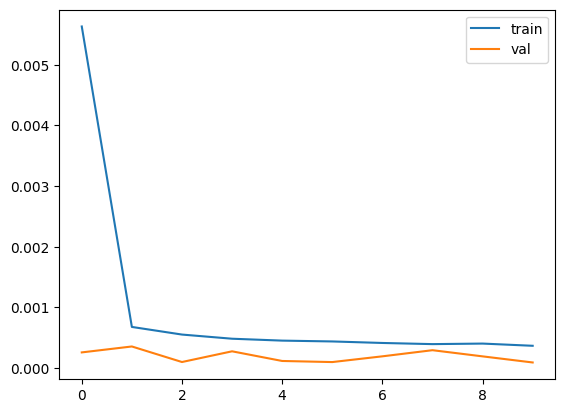

In [39]:
model, train_losses, val_losses = train_rnn(model, criterion, optimizer, train_dataloader, val_dataloader, epochs=10, cuda=True)
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.legend();

In [40]:
len(train_dataset) + len(val_dataset)

6847

In [ ]:
best_param, best_rmse = grid_search_rnn(imputed_dir, candidates, target, emb_dict=None, freq='MS', test_size=4*12, input_size=8, max_epochs=10,
                                        param_grids={'seq_len': [10, 25, 50], 'hidden_size': [10, 20, 50], 'num_layers': range(1, 3)})
best_param, best_rmse

Epoch 0: train loss 0.1906, val loss 0.1404, time 5.8233
Epoch 1: train loss 0.0111, val loss 0.0185, time 5.4091
Epoch 2: train loss 0.0045, val loss 0.0118, time 5.4164
Epoch 3: train loss 0.0044, val loss 0.0096, time 5.4665
Epoch 4: train loss 0.0039, val loss 0.0057, time 5.3912
Epoch 5: train loss 0.0035, val loss 0.0048, time 5.4024
Epoch 6: train loss 0.0035, val loss 0.0035, time 5.4649
Epoch 7: train loss 0.0033, val loss 0.0036, time 5.4505
Epoch 8: train loss 0.0032, val loss 0.0031, time 5.3745
Epoch 9: train loss 0.0031, val loss 0.0037, time 5.4439
warning not converged


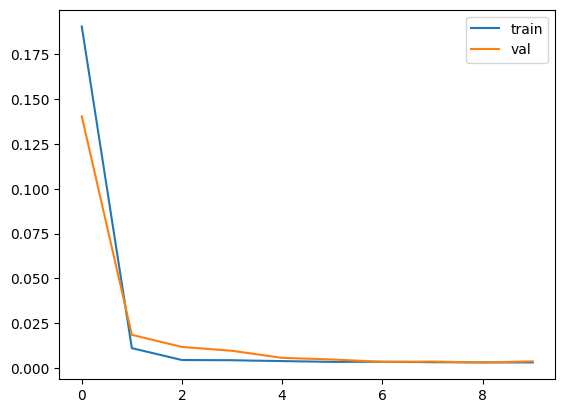

In [42]:
best_param = ({'preprocess': 'standard', 'seq_len': 50, 'batch_size': 128}, 
              {'model_type': 'lstm', 'num_layers': 1, 'hidden_size': 20}, 
              {'optim_type': 'rmsprop', 'lr': 0.00005})

seq_train_x, seq_train_y, seq_test_x, seq_test_y, x_scaler, y_scaler, train_country = load_data(imputed_dir, candidates, target, best_param[0]['seq_len'], freq='MS', test_size=4*12, reverse=False, preprocess=best_param[0]['preprocess'], single_y_scaler=True)
model = ForecastModel(**best_param[1], input_size=8, conditional_labels=np.unique(train_country).tolist())
optimizer = get_torch_optimizer(best_param[2]['optim_type'], model.parameters(), lr=best_param[2]['lr'])
criterion = nn.MSELoss()

train_dataset = TimeSeriesDataset(seq_train_x, seq_train_y,)# (model.num_layers, model.hidden_size))
# train_dataset.initialize_states()
test_dataset = TimeSeriesDataset(seq_test_x, seq_test_y,)# (model.num_layers, model.hidden_size))
# test_dataset.set_initial_states(train_dataset.get_initial_states())
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=8, pin_memory=True)
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=1, pin_memory=True)

model, train_losses, val_losses = train_rnn(model, criterion, optimizer, train_dataloader, test_dataloader, epochs=10, cuda=True)
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.legend();

In [43]:
rnn_preds, _ = eval_rnn(model, criterion, test_dataloader)
rnn_preds = y_scaler.inverse_transform(np.expand_dims(rnn_preds, -1)).flatten()

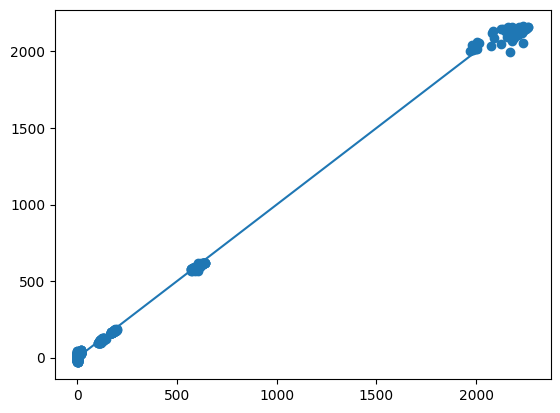

In [44]:
plt.scatter(all_y, rnn_preds)
plt.plot((0, 2000), (0, 2000))

In [45]:
rnn_rmse = sqrt(mean_squared_error(all_y, rnn_preds))
rnn_r2 = r2_score(all_y, rnn_preds)
print(f'RNN RMSE: {rnn_rmse:.5f}\nRNN R2: {rnn_r2:.5f}')

RNN RMSE: 19.69223
RNN R2: 0.99831


# Separate RNN models

In [48]:
rnn_sep_pred = []
for f in os.listdir(imputed_dir):
    if f.endswith('.csv'):
        country = f.split('.')[0]
        print('processing', f)
        # best_param, best_rmse = grid_search_rnn(imputed_dir, candidates, target, emb_dict=None, freq='MS', test_size=4*12, input_size=8, max_epochs=10,
        #                                         param_grids={'seq_len': [20, 50, 70], 'hidden_size': [10, 20, 50], 'num_layers': range(1, 2), 
        #                                                      'batch_size': [64, 128], 'lr': [0.0001, 0.00005,]},
        #                                         country_filter=country, verbose=False)
        
        # print(best_param, best_rmse)
        best_param = ({'preprocess': 'standard', 'seq_len': 50, 'batch_size': 64}, {'model_type': 'gru', 'num_layers': 1, 'hidden_size': 20}, {'optim_type': 'rmsprop', 'lr': 0.0005}) # too slow

        seq_train_x, seq_train_y, seq_test_x, seq_test_y, x_scaler, y_scaler, train_country = load_data(imputed_dir, candidates, target, best_param[0]['seq_len'], freq='MS', test_size=4*12, reverse=False, country_filter=country, preprocess=best_param[0]['preprocess'], single_y_scaler=True)
        model = ForecastModel(**best_param[1], input_size=8, conditional_labels=np.unique(train_country).tolist())
        optimizer = get_torch_optimizer(best_param[2]['optim_type'], model.parameters(), lr=best_param[2]['lr'])
        criterion = nn.MSELoss()

        train_dataset = TimeSeriesDataset(seq_train_x, seq_train_y,)# (model.num_layers, model.hidden_size))
        # train_dataset.initialize_states()
        test_dataset = TimeSeriesDataset(seq_test_x, seq_test_y,)# (model.num_layers, model.hidden_size))
        # test_dataset.set_initial_states(train_dataset.get_initial_states())
        train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=8, pin_memory=True)
        test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=1, pin_memory=True)

        model, train_losses, val_losses = train_rnn(model, criterion, optimizer, train_dataloader, test_dataloader, epochs=10, cuda=True, verbose=False)
        preds, _ = eval_rnn(model, criterion, test_dataloader)
        preds = y_scaler.inverse_transform(np.expand_dims(preds, -1)).flatten()
        rnn_sep_pred.append(preds)
rnn_sep_pred = np.concatenate(rnn_sep_pred)

processing Japan.csv
processing Korea (ROK).csv
processing Chile.csv
processing Maldives.csv
processing Cambodia.csv
processing Singapore.csv
processing USA.csv
processing Chinese Taipei.csv
processing Thailand.csv
processing Indonesia.csv
processing Turkey.csv
processing Macao, China.csv
processing Australia.csv
processing New Zealand.csv
processing Czech.csv
processing Hawaii.csv
processing Mexico.csv
processing Hong Kong SAR.csv
processing Canada.csv
processing Austria.csv


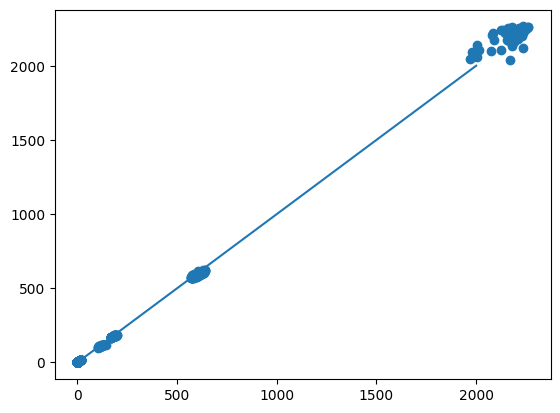

In [49]:
plt.scatter(all_y, rnn_sep_pred)
plt.plot((0, 2000), (0, 2000))

In [50]:
rnn_sep_rmse = sqrt(mean_squared_error(all_y, rnn_sep_pred))
rnn_sep_r2 = r2_score(all_y, rnn_sep_pred)
print(f'Separate RNN RMSE: {rnn_sep_rmse:.5f}\n Separate RNN R2: {rnn_sep_r2:.5f}')

Separate RNN RMSE: 15.05219
 Separate RNN R2: 0.99901


# Ensembling Models

In [51]:
sarima_rmse = sqrt(mean_squared_error(all_y, sarima_pred))
sarima_r2 = r2_score(all_y, sarima_pred)
print(f'Baseline SARIMA RMSE: {sarima_rmse:.5f}\nBaseline SARIMA R2: {sarima_r2:.5f}')

Baseline SARIMA RMSE: 17.62365
Baseline SARIMA R2: 0.99865


In [52]:
rnn_preds.min()

-32.091988

In [53]:
rnn_sep_rmse = sqrt(mean_squared_error(all_y, rnn_sep_pred))
rnn_sep_r2 = r2_score(all_y, rnn_sep_pred)
print(f'Separate RNN RMSE: {rnn_sep_rmse:.5f}\n Separate RNN R2: {rnn_sep_r2:.5f}')

Separate RNN RMSE: 15.05219
 Separate RNN R2: 0.99901


In [54]:
arima_w = 0.5
for i in range(0, 11):
    arima_w = i / 10
    print(arima_w)
    ensemble_pred = arima_w * sarima_pred.clip(0.1, 2500) + (1 - arima_w) * rnn_sep_pred.clip(0.1, 2500)

    ensemble_rmse = sqrt(mean_squared_error(all_y, ensemble_pred))
    ensemble_r2 = r2_score(all_y, ensemble_pred)
    print(f'Ensemble Model RMSE: {ensemble_rmse:.5f}\nEnsemble Model R2: {ensemble_r2:.5f}')

0.0
Ensemble Model RMSE: 15.05219
Ensemble Model R2: 0.99901
0.1
Ensemble Model RMSE: 14.92741
Ensemble Model R2: 0.99903
0.2
Ensemble Model RMSE: 14.89245
Ensemble Model R2: 0.99903
0.3
Ensemble Model RMSE: 14.94795
Ensemble Model R2: 0.99903
0.4
Ensemble Model RMSE: 15.09291
Ensemble Model R2: 0.99901
0.5
Ensemble Model RMSE: 15.32479
Ensemble Model R2: 0.99898
0.6
Ensemble Model RMSE: 15.63972
Ensemble Model R2: 0.99893
0.7
Ensemble Model RMSE: 16.03281
Ensemble Model R2: 0.99888
0.8
Ensemble Model RMSE: 16.49848
Ensemble Model R2: 0.99881
0.9
Ensemble Model RMSE: 17.03077
Ensemble Model R2: 0.99874
1.0
Ensemble Model RMSE: 17.62365
Ensemble Model R2: 0.99865


# Full Run
Best model seems to be ensembling of SARIMA and Separate RNN

In [55]:
# repeat for all countries for rnn model
# no need to rerun for forecast
# best_param, best_rmse = grid_search_rnn(reverse=False, verbose=False)
candidates = ['GDPPerCap', 'GDP', 'Population', 'Country', 'GDPRatioChina', 'GDPPerCapRatioChina', 'GDPGrowthDiffChina', 'GDPPerCapGrowthDiffChina']
target = 'FXAgainstChina'

processing Japan.csv


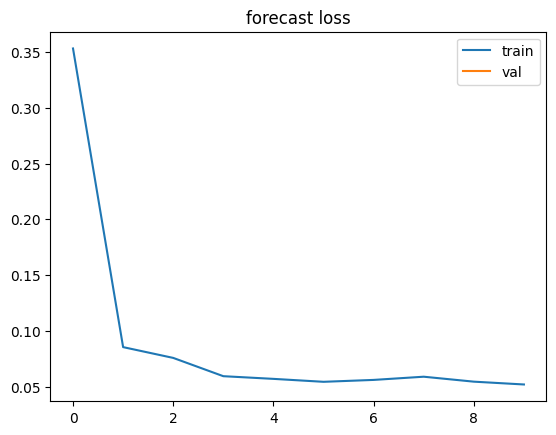

processing Korea (ROK).csv


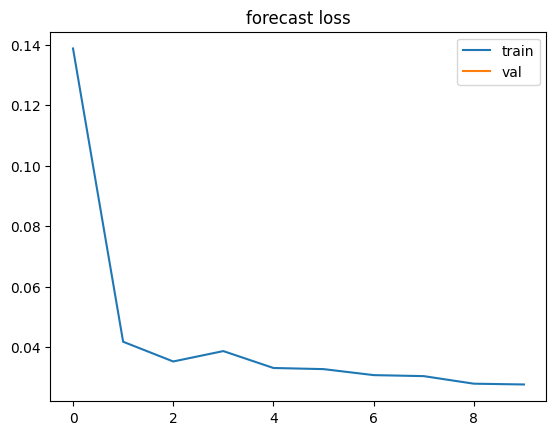

processing Chile.csv


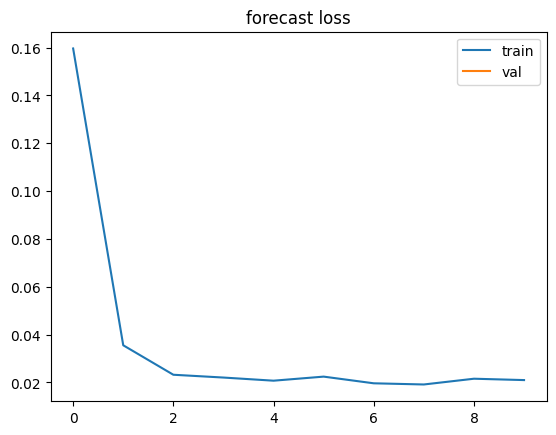

processing Maldives.csv


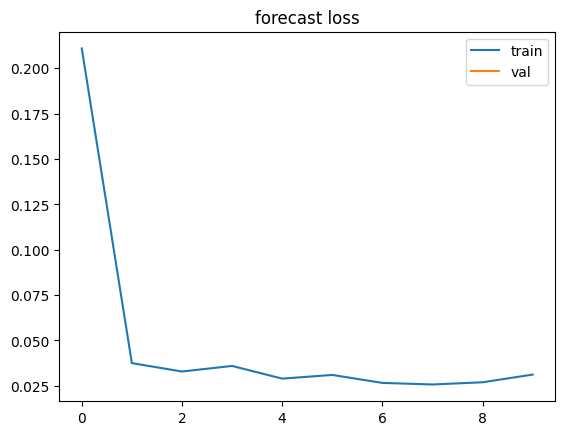

processing Cambodia.csv


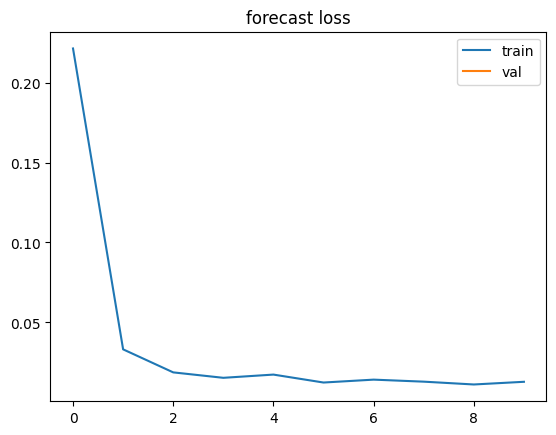

processing Singapore.csv


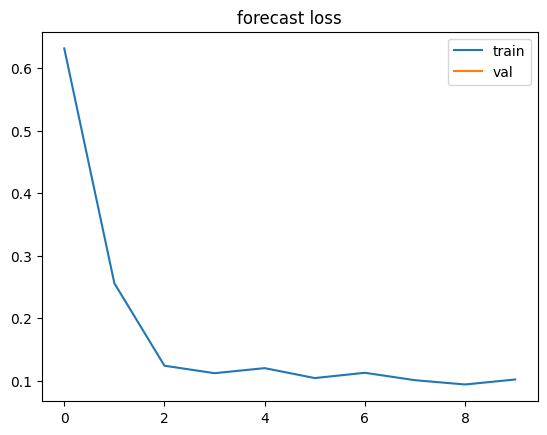

processing USA.csv


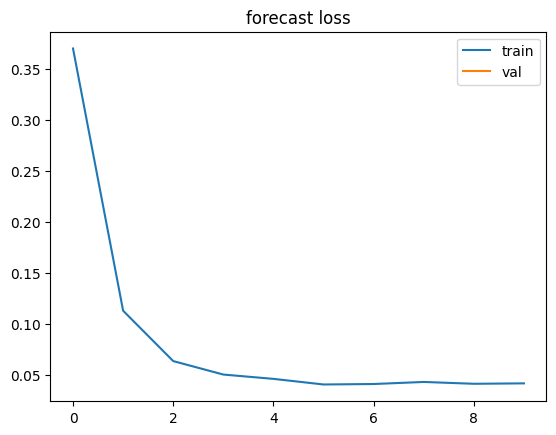

processing Chinese Taipei.csv


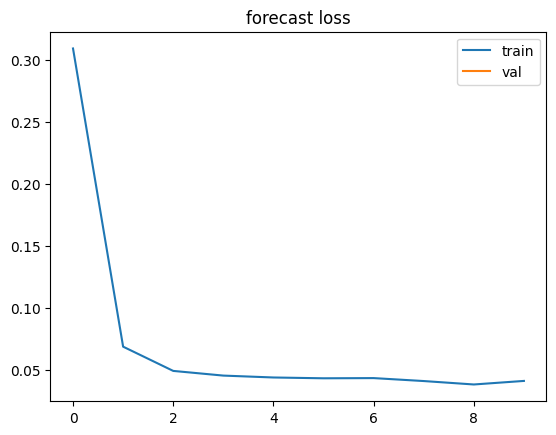

processing Thailand.csv


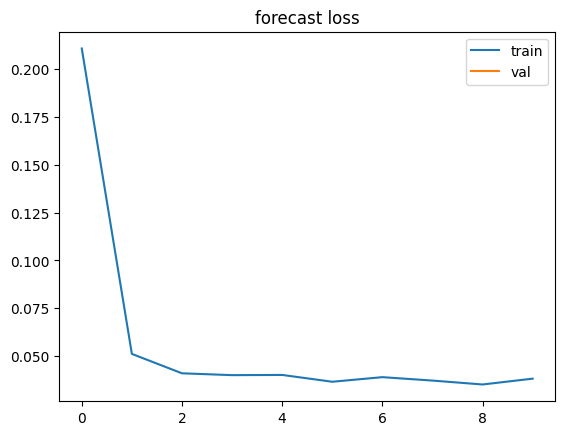

processing Indonesia.csv


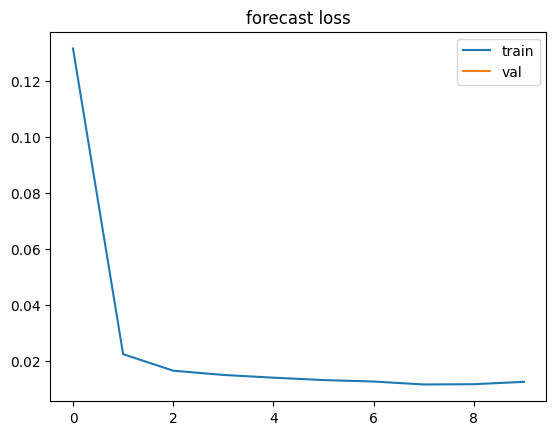

processing Turkey.csv


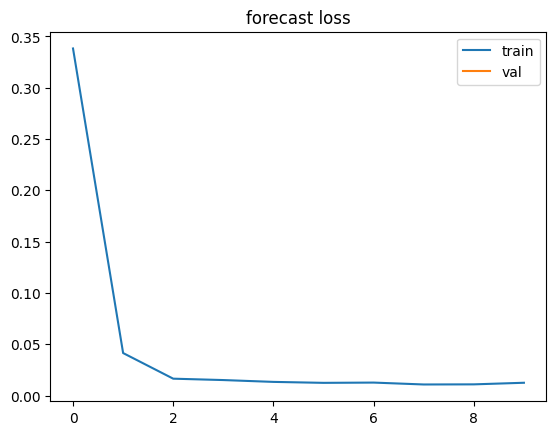

processing Macao, China.csv


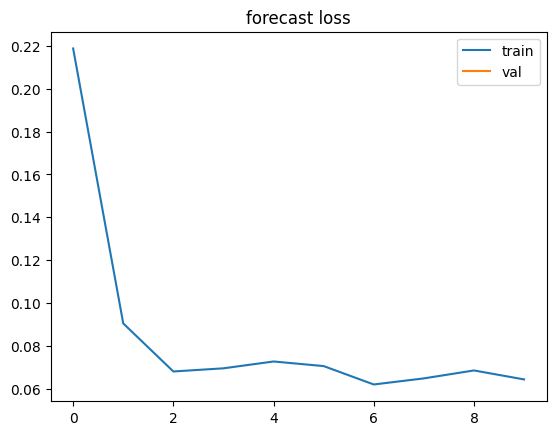

processing Australia.csv


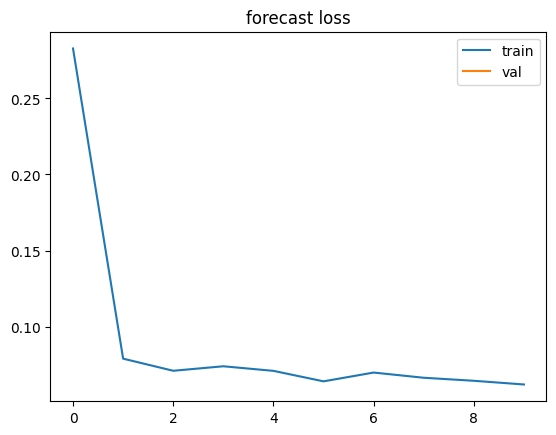

processing New Zealand.csv


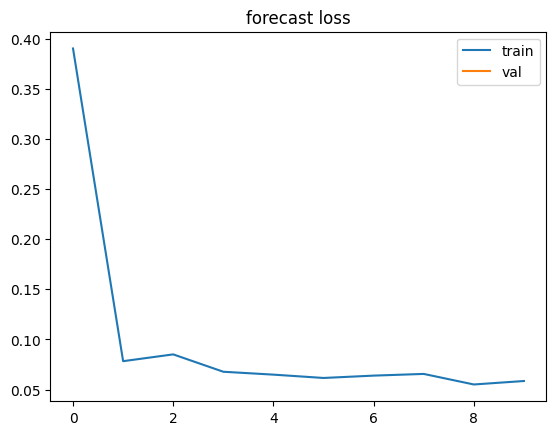

processing Czech.csv


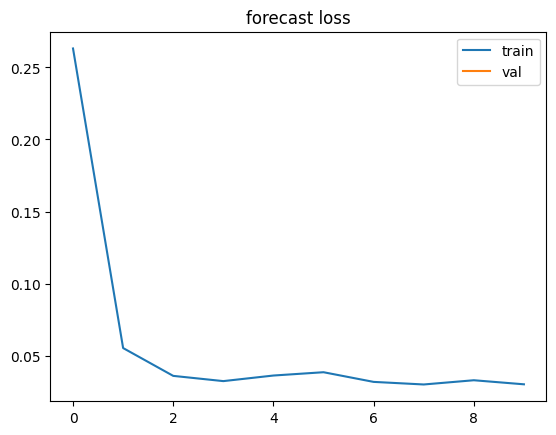

processing Hawaii.csv


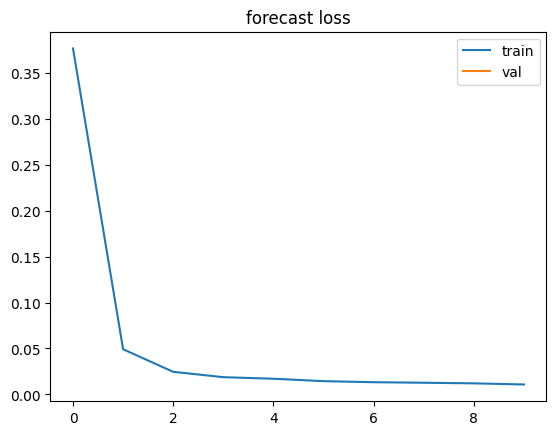

processing Mexico.csv


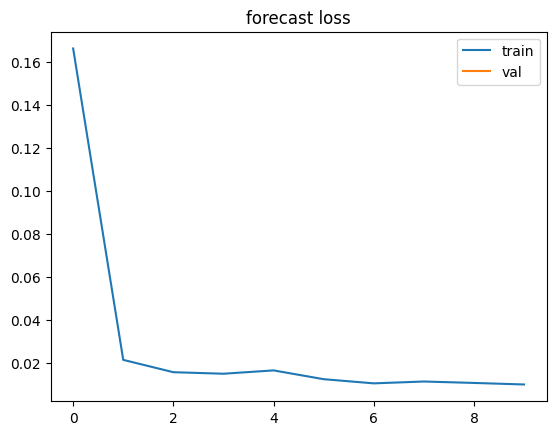

processing Hong Kong SAR.csv


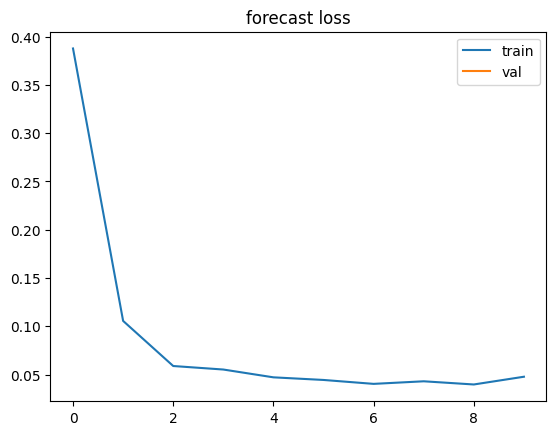

processing Canada.csv


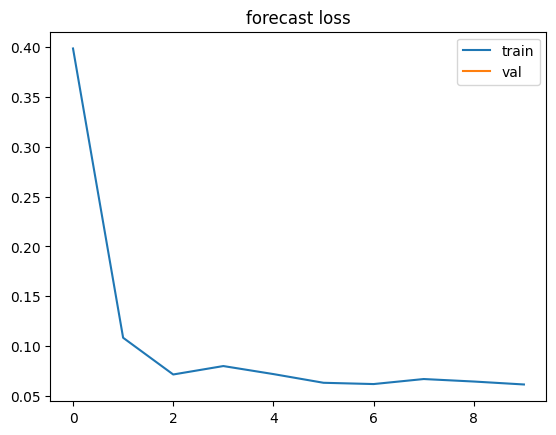

processing Austria.csv


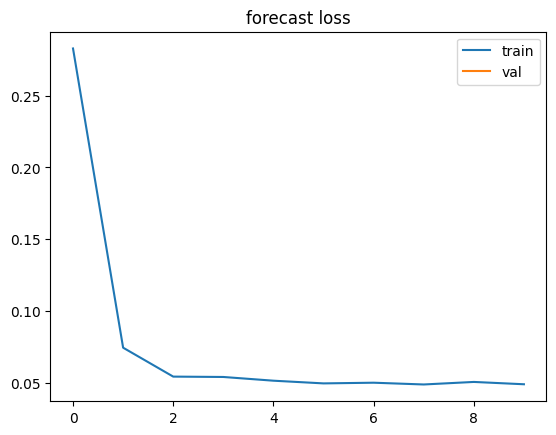

In [58]:
forecast_predictions = {}
for f in os.listdir(imputed_dir):
    if f.endswith('.csv'):
        print('processing', f)
        country = f.split('.')[0]
        # best_param, best_rmse = grid_search_rnn(imputed_dir, candidates, target, emb_dict=None, freq='MS', test_size=4*12, input_size=8, max_epochs=10,
        #                                         param_grids={'seq_len': [20, 50, 70], 'hidden_size': [10, 20, 50], 'num_layers': range(1, 2), 
        #                                                      'batch_size': [64], 'lr': [0.0001, 0.00005, 0.00001]},
        #                                         country_filter=country, verbose=False)
        best_param = ({'preprocess': 'standard', 'seq_len': 50, 'batch_size': 64}, {'model_type': 'gru', 'num_layers': 1, 'hidden_size': 20}, {'optim_type': 'rmsprop', 'lr': 0.0005}) # too slow

        seq_train_x, seq_train_y, seq_test_x, seq_test_y, x_scaler, y_scaler, train_country = load_data_forecast(imputed_dir, candidates, target, best_param[0]['seq_len'], freq='MS', reverse=False, country_filter=country, preprocess=best_param[0]['preprocess'])
        model = ForecastModel(**best_param[1], input_size=8, conditional_labels=np.unique(train_country).tolist())
        optimizer = get_torch_optimizer(best_param[2]['optim_type'], model.parameters(), lr=best_param[2]['lr'])
        criterion = nn.MSELoss()
        
        # seq_train_x, seq_train_y, seq_val_x, seq_val_y = seq_train_x[:-3], seq_train_y[:-3], seq_train_x[-3:], seq_train_y[-3:]
        train_dataset = TimeSeriesDataset(seq_train_x, seq_train_y,)# (model.num_layers, model.hidden_size))
        # val_dataset = TimeSeriesDataset(seq_val_x, seq_val_y,)# (model.num_layers, model.hidden_size))
        train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=8, pin_memory=True)
        # val_dataloader = DataLoader(val_dataset, shuffle=False, batch_size=1, pin_memory=True)

        model, train_losses, val_losses = train_rnn(model, criterion, optimizer, train_dataloader, epochs=10, cuda=True, verbose=False)
        predictions = one_step_prediction(model, seq_test_x, x_scaler, y_scaler)
        forecast_predictions = {**forecast_predictions, **predictions}

        plt.plot(train_losses, label='train')
        plt.plot(val_losses, label='val')
        plt.title('forecast loss')
        plt.legend()
        plt.show()

processing Japan.csv


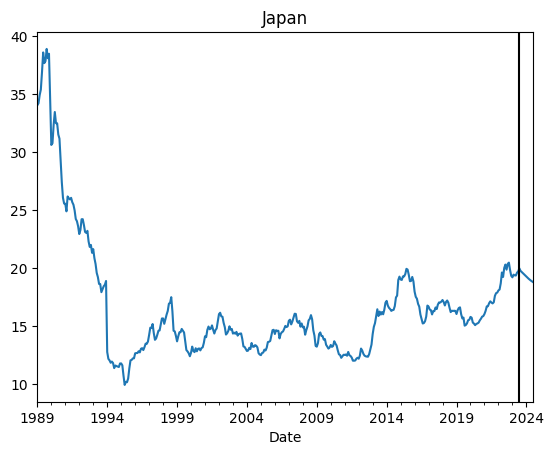

processing Korea (ROK).csv


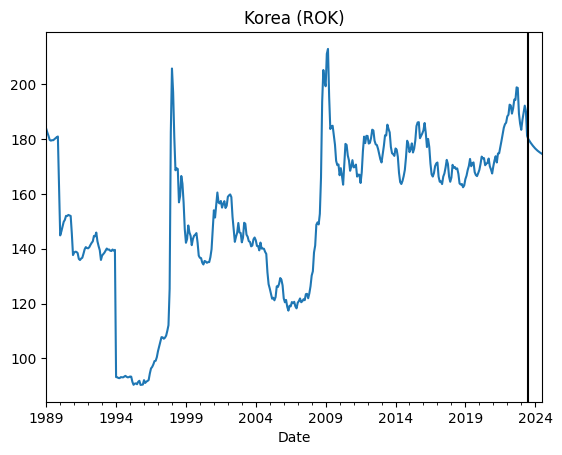

processing Chile.csv


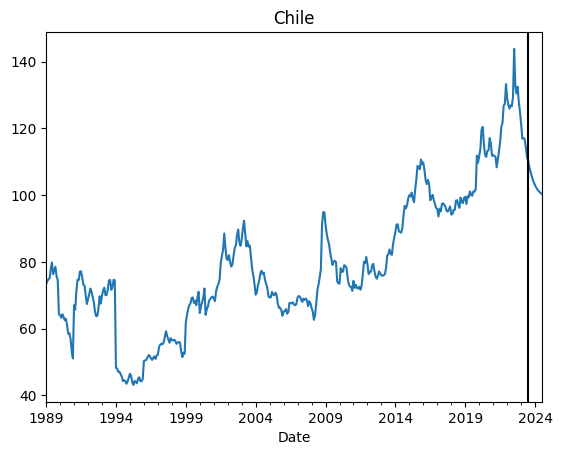

processing Maldives.csv


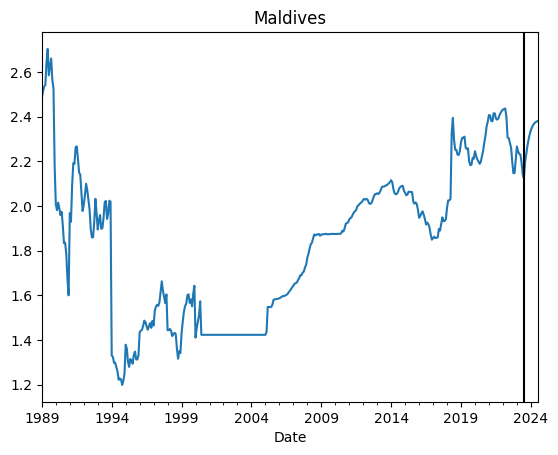

processing Cambodia.csv


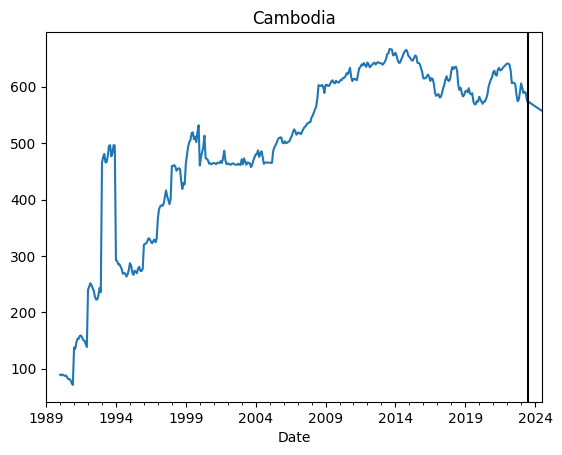

processing Singapore.csv


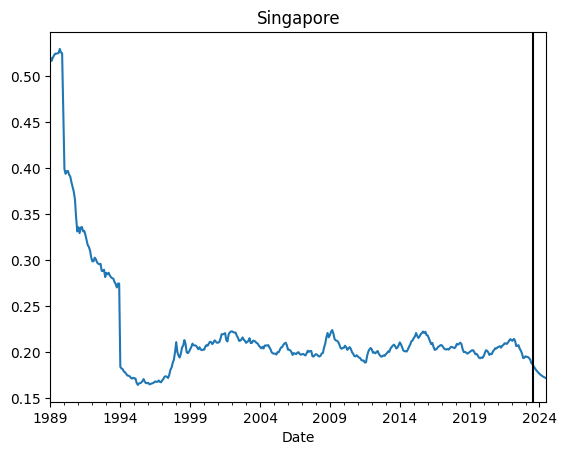

processing USA.csv


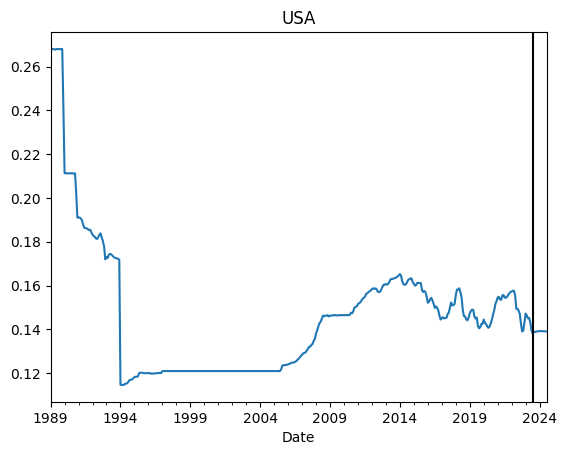

processing Chinese Taipei.csv


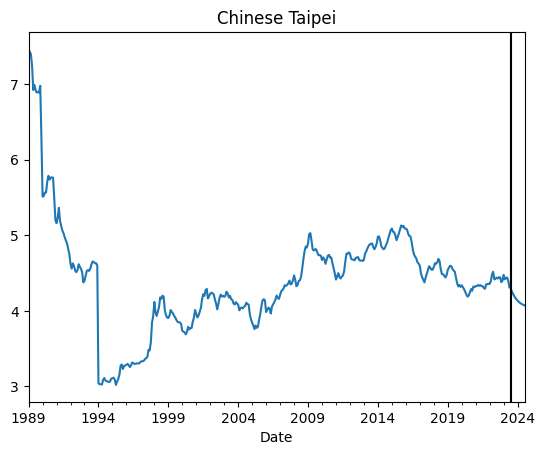

processing Thailand.csv


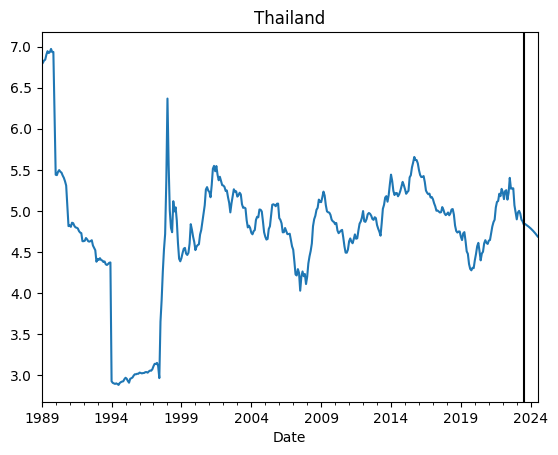

processing Indonesia.csv


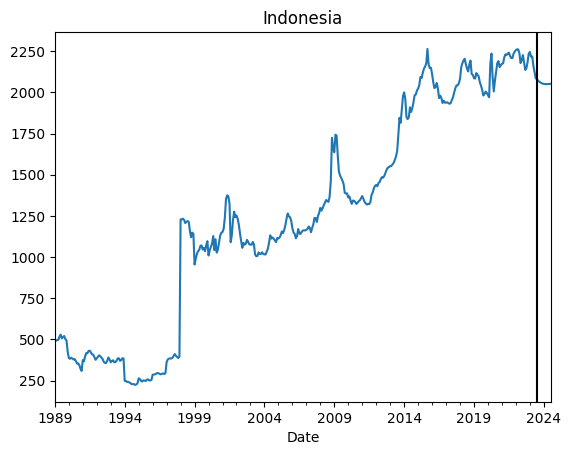

processing Turkey.csv


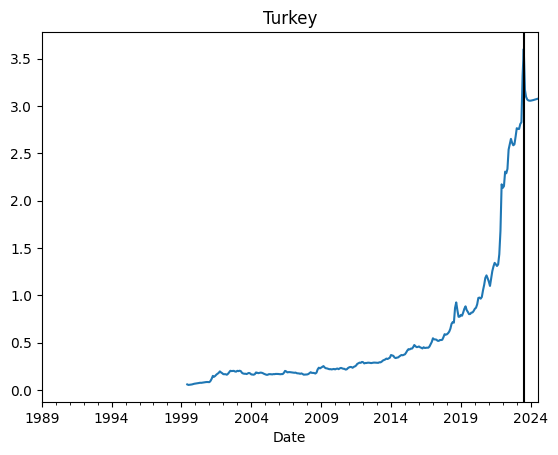

processing Macao, China.csv


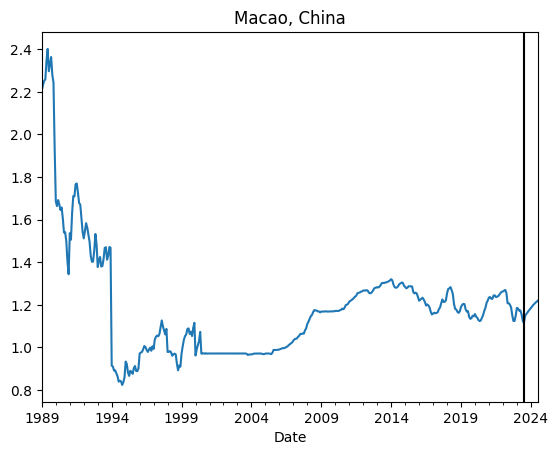

processing Australia.csv


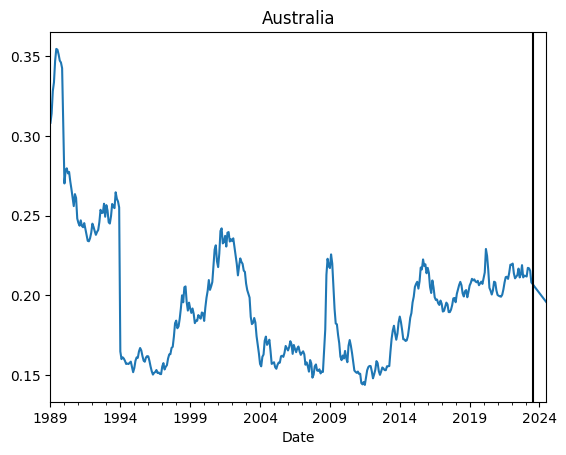

processing New Zealand.csv


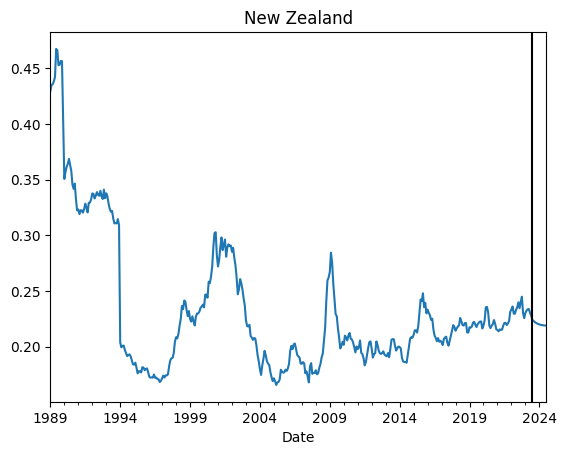

processing Czech.csv


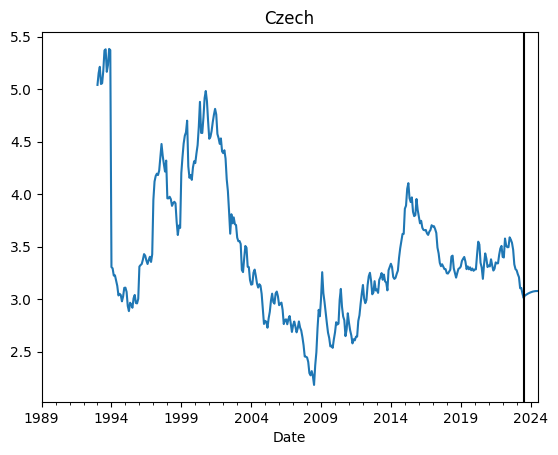

processing Hawaii.csv


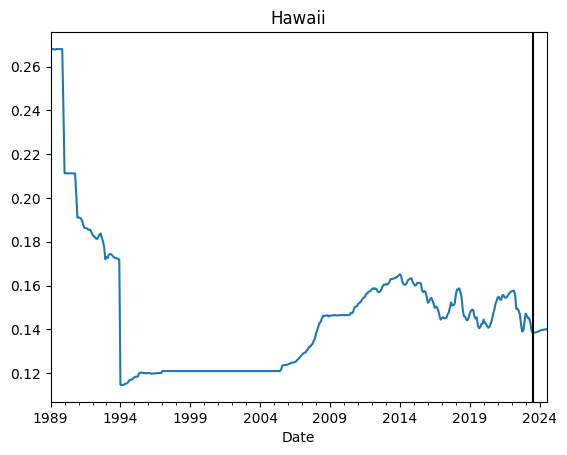

processing Mexico.csv


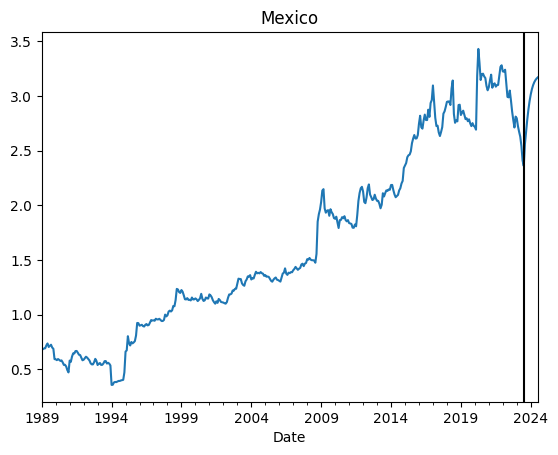

processing Hong Kong SAR.csv


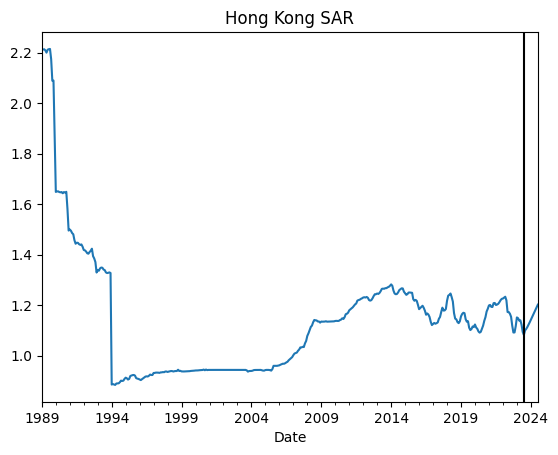

processing Canada.csv


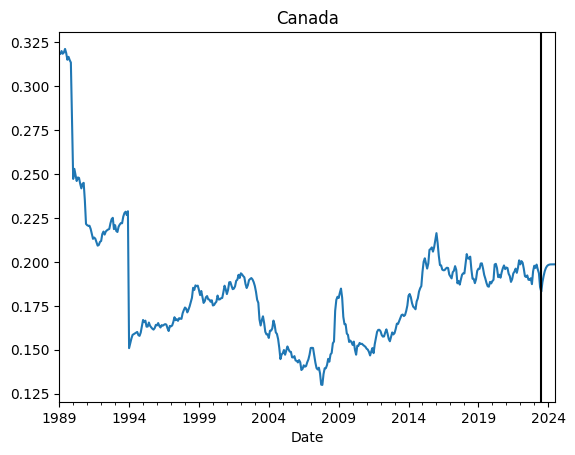

processing Austria.csv


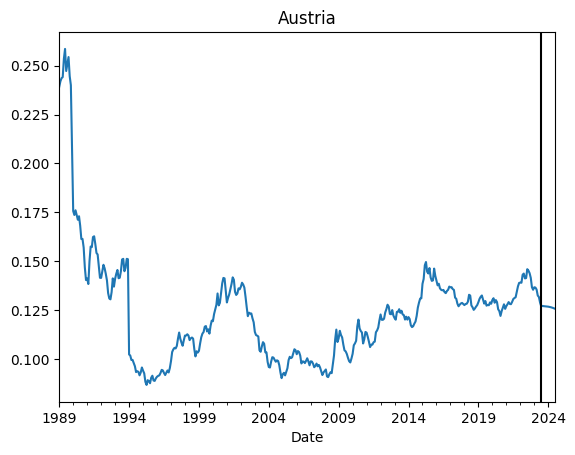

In [59]:
for f in os.listdir(imputed_dir):
    if f.endswith('.csv'):
        print('processing', f)
        country = f.split('.')[0]
        full_df = pd.read_csv(os.path.join(imputed_dir, f))
        full_df['Date'] = pd.to_datetime(full_df['Date'])
        # df = df[df['Date'] < '2020-01-01']
        full_df = full_df.set_index('Date')
        end_date = full_df[target].last_valid_index()
        df = full_df.copy()
        df = df.reset_index(names='Date')
        df.loc[df[target].last_valid_index() + 1:, target] = np.asarray(forecast_predictions[country]).clip(0.9*full_df[target].min(), 1.1*full_df[target].max())
        df = df.set_index('Date')
        
        full_df[target] = full_df[target].fillna(df[target]).ffill()
        full_df.reset_index(names='Date')
        full_df[target].plot()
        plt.title(country)
        plt.axvline(end_date, color='black')
        plt.show()
        # break
        # full_df.to_csv(os.path.join(imputed_dir, f))

processing Japan.csv
[(1, 1, 0), (0, 1, 1, 12), 'c'] 0.885307777209198 None


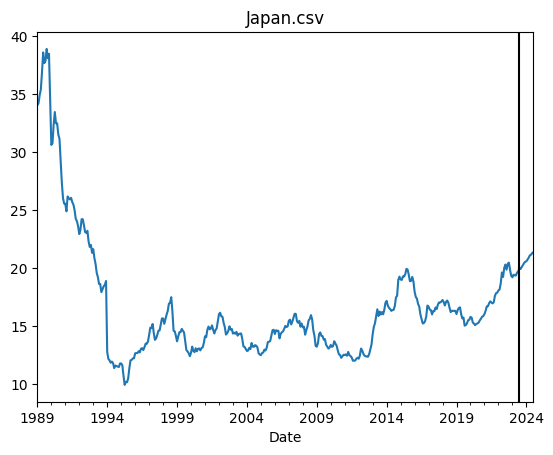

processing Korea (ROK).csv
[(1, 1, 0), (1, 1, 0, 12), 'c'] 5.7967455823793905 None


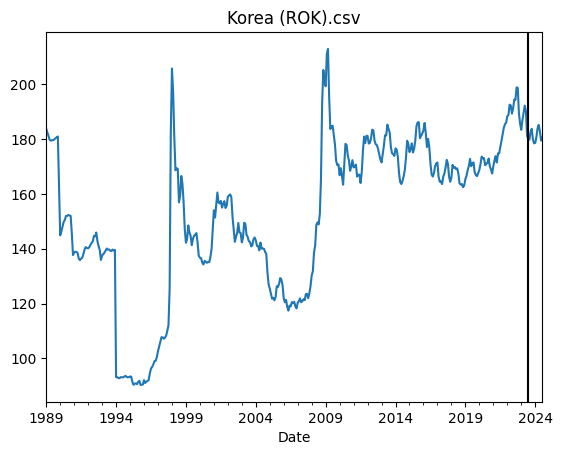

processing Chile.csv
[(0, 1, 2), (0, 1, 0, 12), 'c'] 13.13586183955123 None


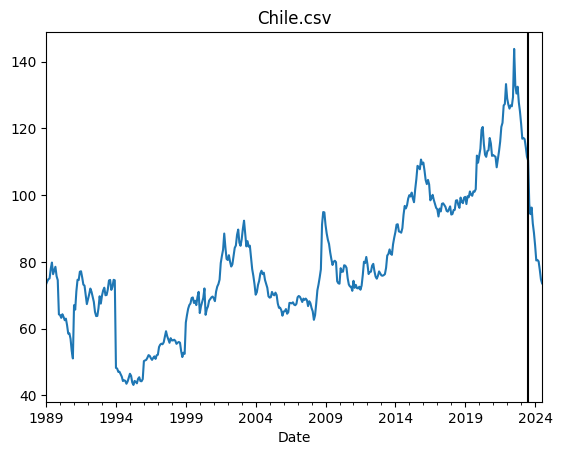

processing Maldives.csv
[(0, 0, 0), (0, 1, 0, 12), 'n'] 0.09859053854368247 None


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


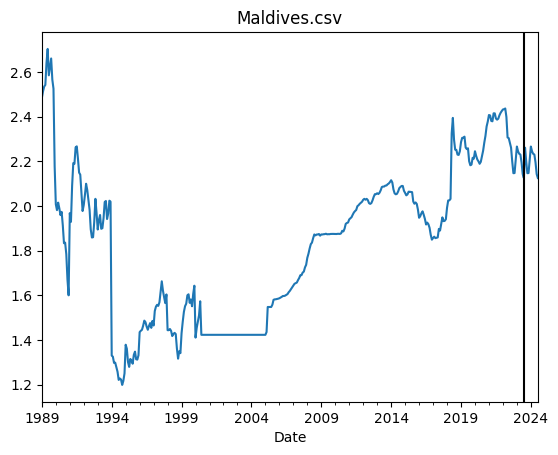

processing Cambodia.csv
[(0, 0, 1), (1, 1, 1, 12), 'n'] 24.261415973033817 None


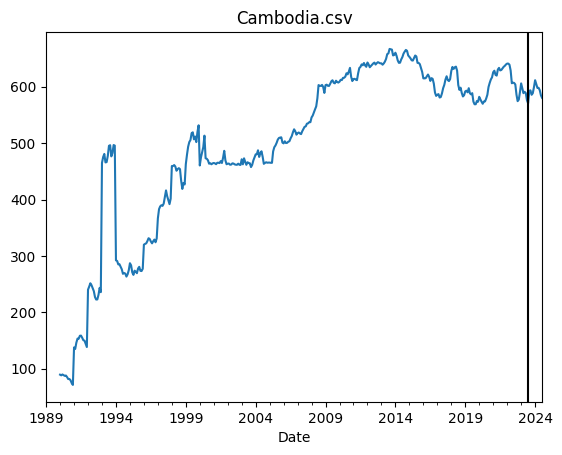

processing Singapore.csv
[(1, 0, 1), (1, 1, 1, 12), 'n'] 0.007231266903346869 None


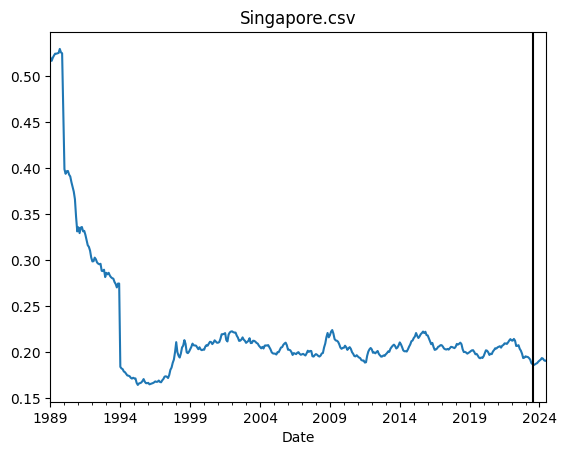

processing USA.csv
[(0, 0, 0), (0, 0, 1, 12), 'c'] 0.005376147816357612 None


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


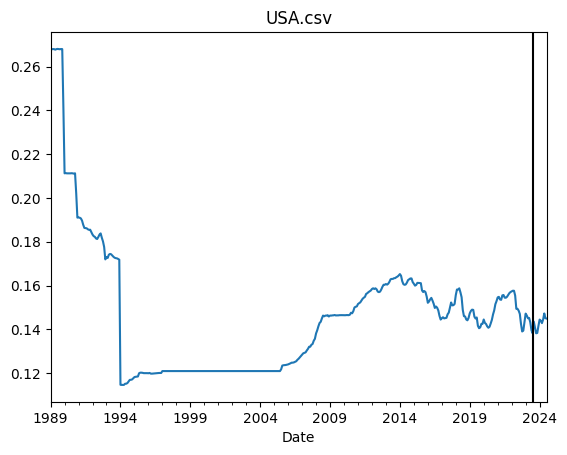

processing Chinese Taipei.csv
[(0, 0, 0), (0, 0, 0, 12), 'c'] 0.09708230260182105 None


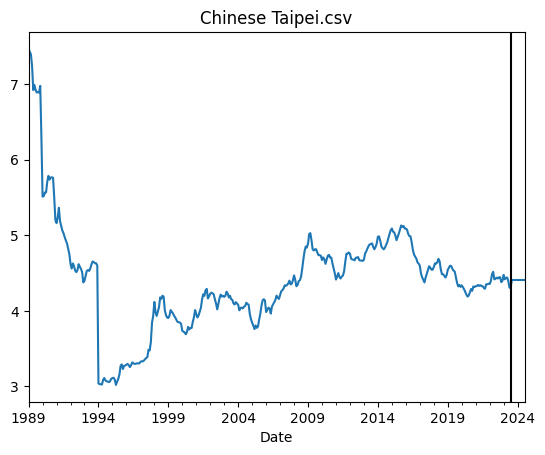

processing Thailand.csv
[(2, 1, 1), (1, 1, 1, 12), 'c'] 0.26060335110503324 None


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


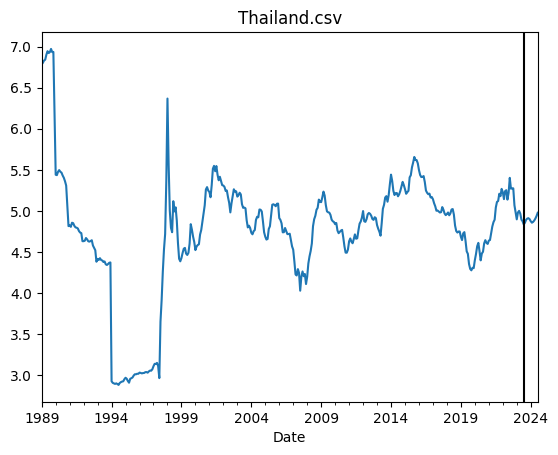

processing Indonesia.csv
[(1, 1, 0), (1, 1, 1, 12), 'n'] 73.58963785493161 None


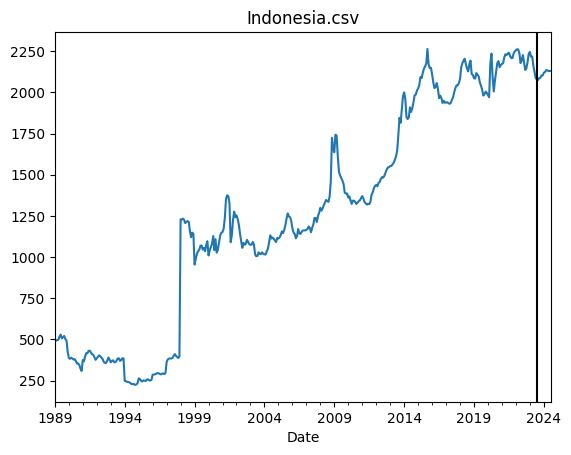

processing Turkey.csv
[(2, 1, 2), (1, 1, 0, 12), 'c'] 0.832034167147965 None


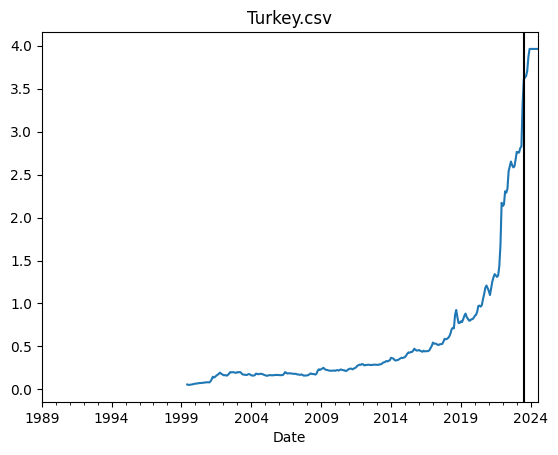

processing Macao, China.csv
[(0, 0, 0), (0, 0, 1, 12), 'c'] 0.043824345159825716 None


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


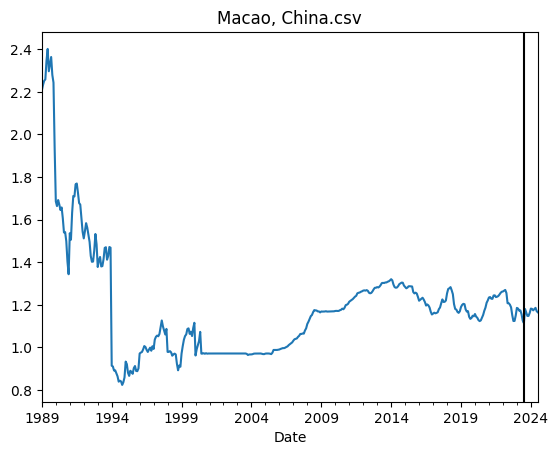

processing Australia.csv
[(2, 0, 2), (0, 0, 0, 12), 'c'] 0.00653477850574442 None


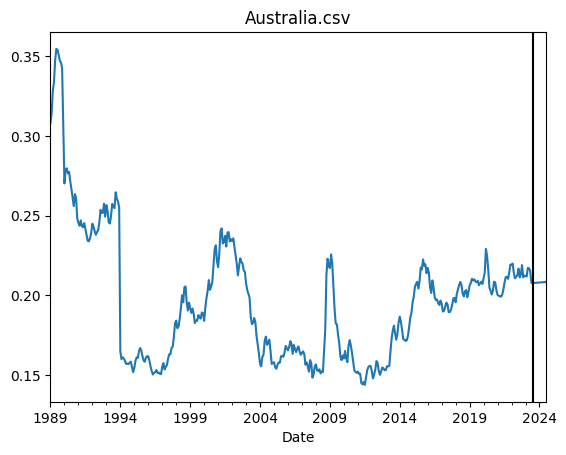

processing New Zealand.csv
[(2, 0, 2), (1, 0, 0, 12), 'c'] 0.006680254804279749 None


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


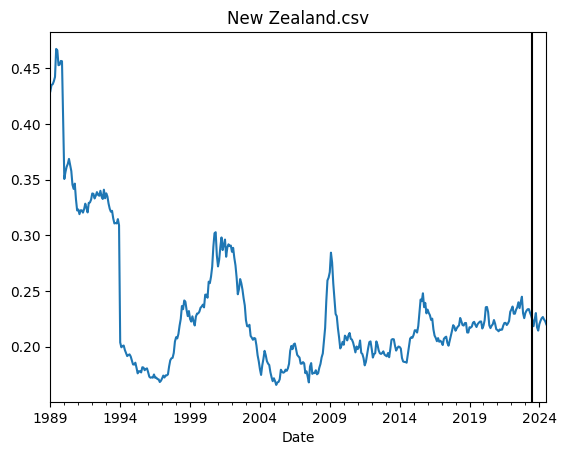

processing Czech.csv
[(2, 1, 1), (0, 0, 0, 12), 'n'] 0.13670651951501223 None


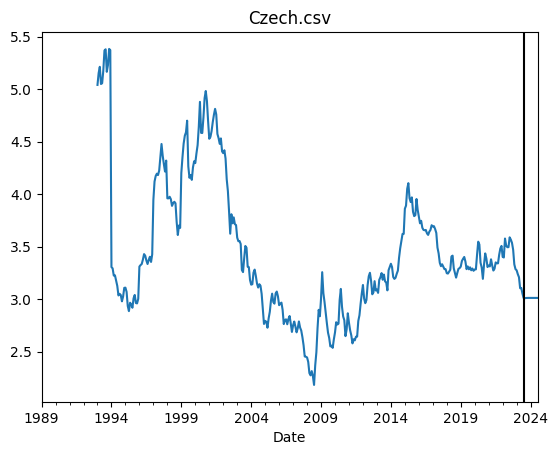

processing Hawaii.csv
[(0, 0, 0), (0, 0, 1, 12), 'c'] 0.005376147816357612 None


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


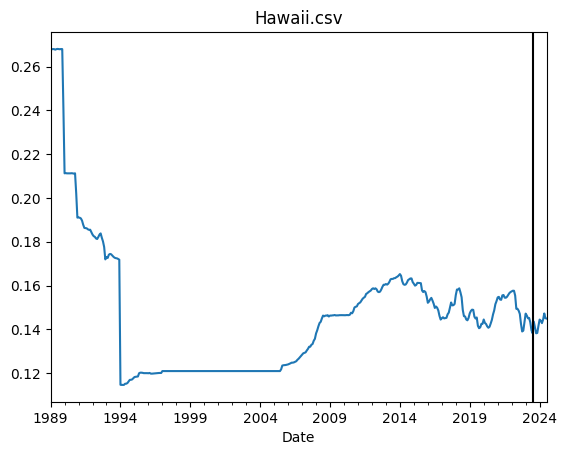

processing Mexico.csv
[(1, 0, 2), (1, 1, 0, 12), 'n'] 0.2615327576116882 None


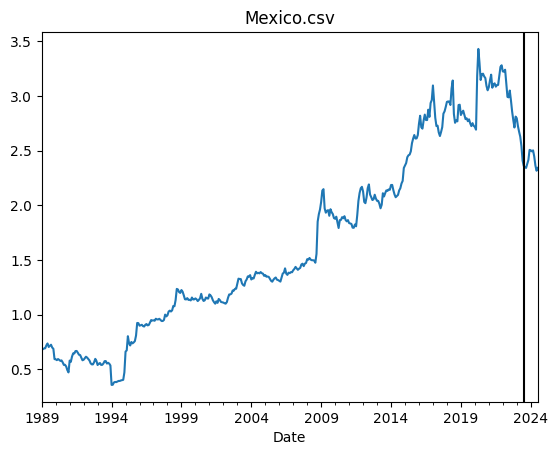

processing Hong Kong SAR.csv
[(0, 0, 0), (0, 0, 1, 12), 'c'] 0.040023652515036 None


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


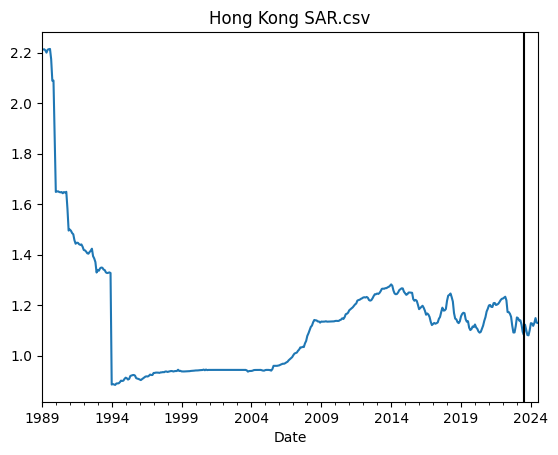

processing Canada.csv
[(1, 0, 1), (1, 0, 1, 12), 'c'] 0.003982608800481525 None


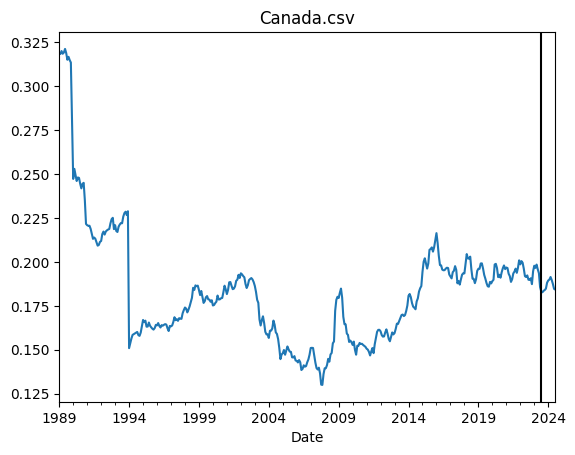

processing Austria.csv
[(0, 0, 0), (1, 0, 0, 12), 'c'] 0.005436103285490503 None


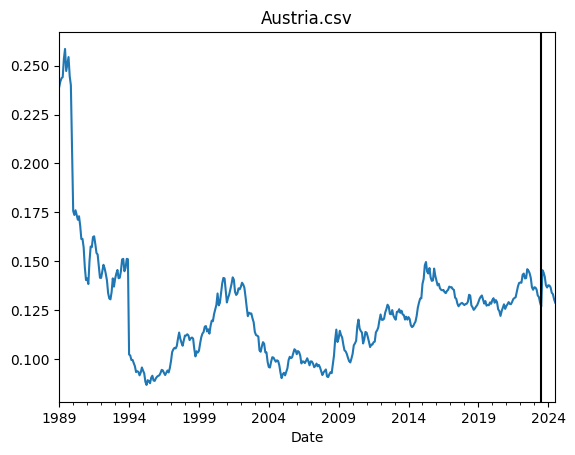

In [61]:
# repeat for all countries for sarima
target = 'FXAgainstChina'

for f in os.listdir(imputed_dir):
    if f.endswith('.csv'):
        print('processing', f)
        full_df = pd.read_csv(os.path.join(imputed_dir, f))
        full_df['Date'] = pd.to_datetime(full_df['Date'])
        # df = df[df['Date'] < '2020-01-01']
        full_df = full_df.set_index('Date')
        df = full_df.copy()
        
        # forward
        train_full = df[target].asfreq('MS')
        train_y = train_full.dropna()
        train_y, test_y = train_y.iloc[:-4*12], train_y.iloc[-4*12:]
        
        best_param, best_rmse, best_r2 = grid_search_sarimax(train_y, test_y, init_repeat=False, param_grids={'p': range(0, 3), 'q': range(0, 2), 'r': range(0, 3)})
        print(best_param, best_rmse, best_r2)
        train_y = train_full.dropna()
        test_y = train_full[train_full.last_valid_index() + train_full.index.freq:]
        sarima_model = sm.tsa.statespace.SARIMAX(train_y, order=best_param[0], seasonal_order=best_param[1], trend=best_param[2])
        result = sarima_model.fit(disp=False)
        pred = result.forecast(len(test_y)).clip(0.9*full_df[target].min(), 1.1*full_df[target].max())
        pred_df = pd.DataFrame({'TargetImputed': pred}, index=test_y.index)
        
        assert sum(full_df[full_df[target].first_valid_index():][target].isna()) == len(pred_df)
        full_df[target] = full_df[target].fillna(full_df.merge(pred_df, how='left', left_index=True, right_index=True)['TargetImputed'])
        full_df.reset_index(names='Date')
        full_df[target].plot()
        plt.title(f)
        plt.axvline(train_y.index.max(), color='black')
        plt.show()
        # full_df.to_csv(os.path.join(imputed_dir, f))
        # break

In [63]:
sarima_best_param = {'Japan': [(1, 1, 0), (0, 1, 1, 12), 'c'], 'Korea (ROK)': [(1, 1, 0), (1, 1, 0, 12), 'c'], 'Chile': [(0, 1, 2), (0, 1, 0, 12), 'c'], 'Maldives': [(0, 0, 0), (0, 1, 0, 12), 'n'],
                     'Cambodia': [(0, 0, 1), (1, 1, 1, 12), 'n'], 'Singapore': [(1, 0, 1), (1, 1, 1, 12), 'n'], 'USA': [(0, 0, 0), (0, 0, 1, 12), 'c'], 'Chinese Taipei': [(0, 0, 0), (0, 0, 0, 12), 'c'],
                     'Thailand': [(2, 1, 1), (1, 1, 1, 12), 'c'], 'Indonesia': [(1, 1, 0), (1, 1, 1, 12), 'n'], 'Turkey': [(2, 1, 2), (1, 1, 0, 12), 'c'], 'Macao, China': [(0, 0, 0), (0, 0, 1, 12), 'c'],
                     'Australia': [(2, 0, 2), (0, 0, 0, 12), 'c'], 'New Zealand': [(2, 0, 2), (1, 0, 0, 12), 'c'], 'Czech': [(2, 1, 1), (0, 0, 0, 12), 'n'], 'Hawaii': [(0, 0, 0), (0, 0, 1, 12), 'c'],
                     'Mexico': [(1, 0, 2), (1, 1, 0, 12), 'n'], 'Hong Kong SAR': [(0, 0, 0), (0, 0, 1, 12), 'c'], 'Canada': [(1, 0, 1), (1, 0, 1, 12), 'c'], 'Austria': [(0, 0, 0), (1, 0, 0, 12), 'c']}

processing Japan.csv


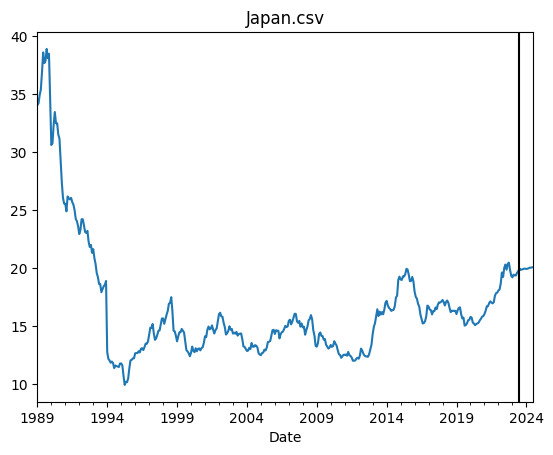

processing Korea (ROK).csv


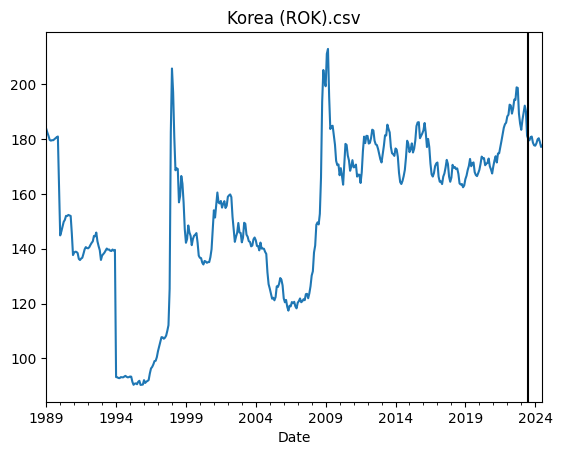

processing Chile.csv


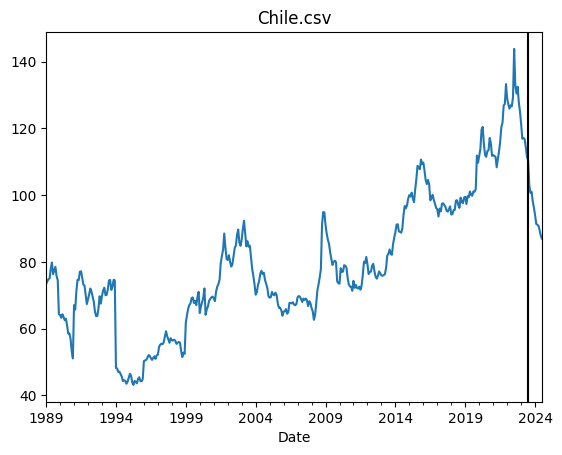

processing Maldives.csv


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


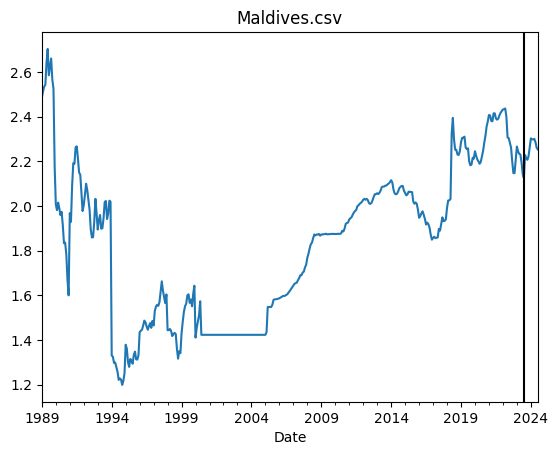

processing Cambodia.csv


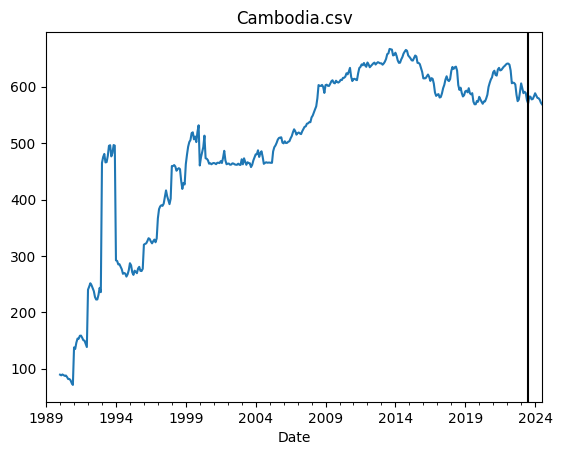

processing Singapore.csv


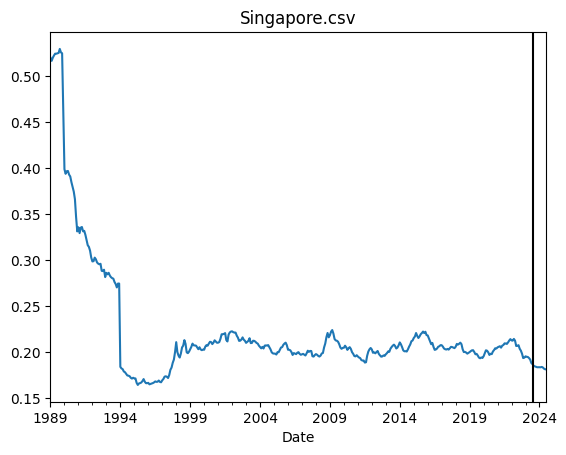

processing USA.csv


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


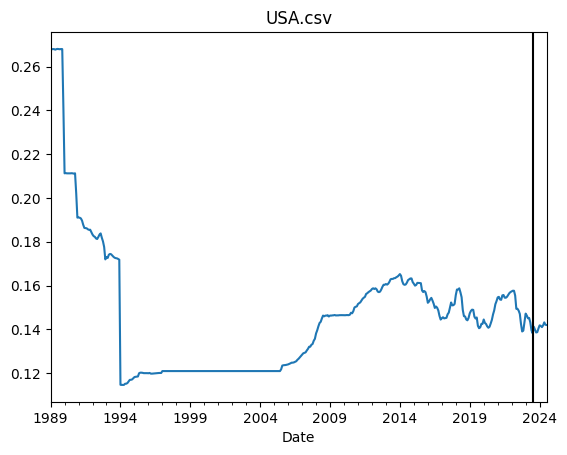

processing Chinese Taipei.csv


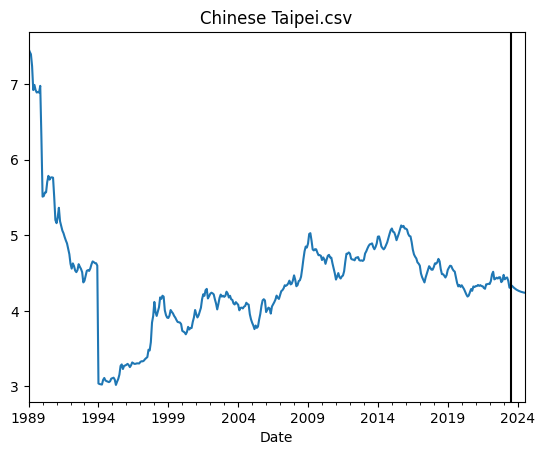

processing Thailand.csv


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


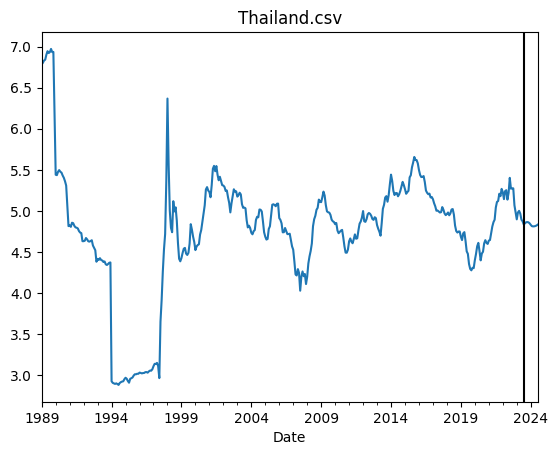

processing Indonesia.csv


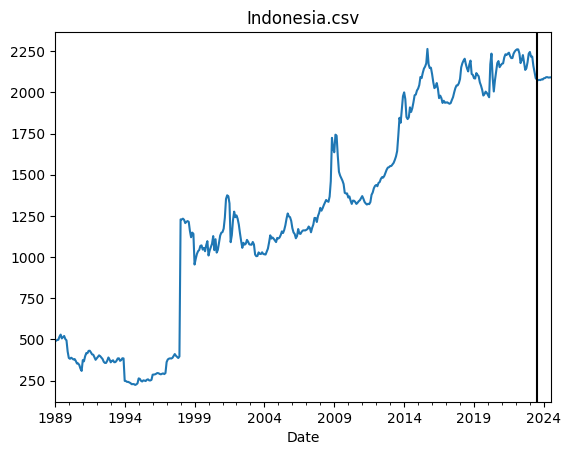

processing Turkey.csv


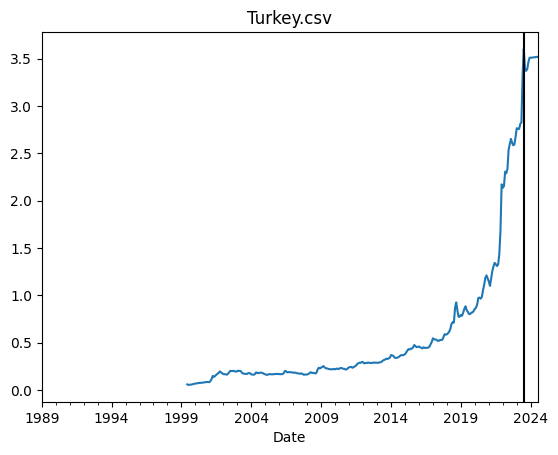

processing Macao, China.csv


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


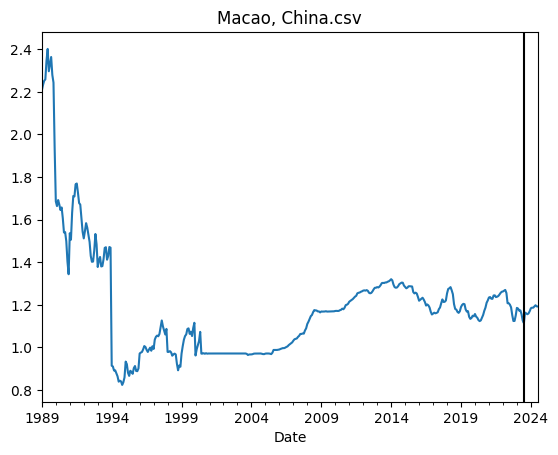

processing Australia.csv


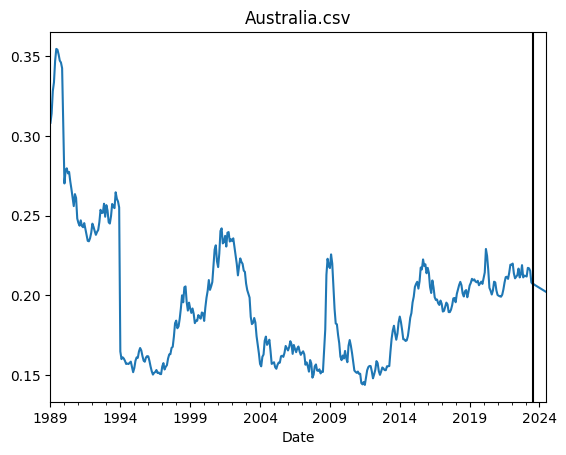

processing New Zealand.csv


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


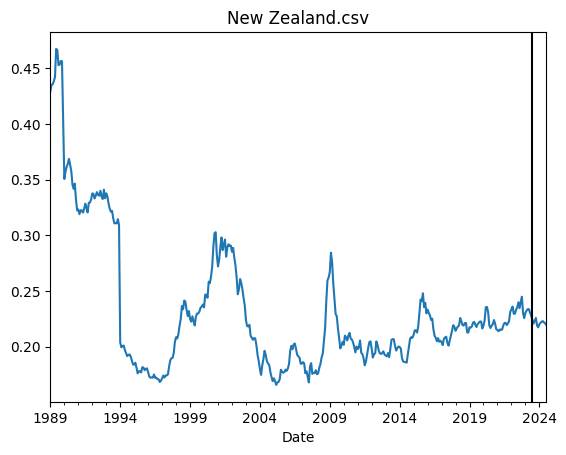

processing Czech.csv


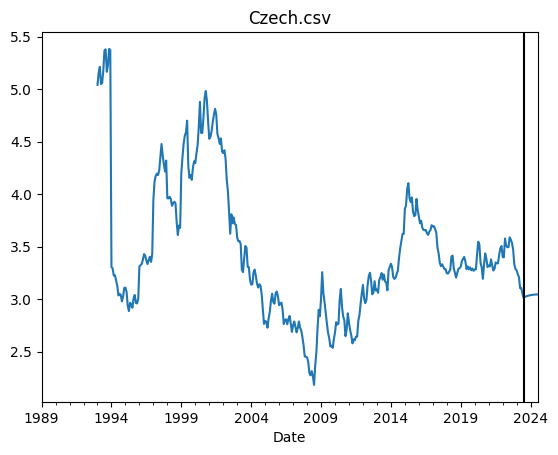

processing Hawaii.csv


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


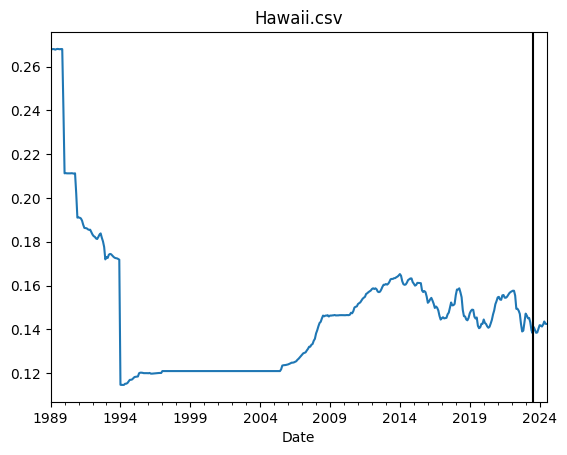

processing Mexico.csv


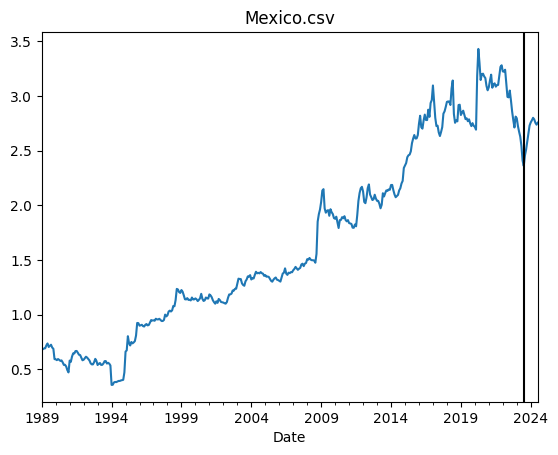

processing Hong Kong SAR.csv


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


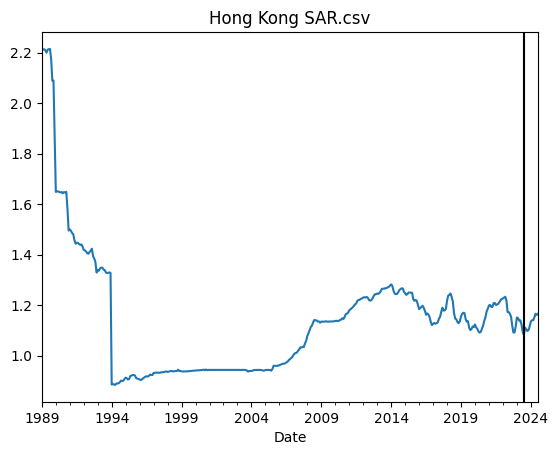

processing Canada.csv


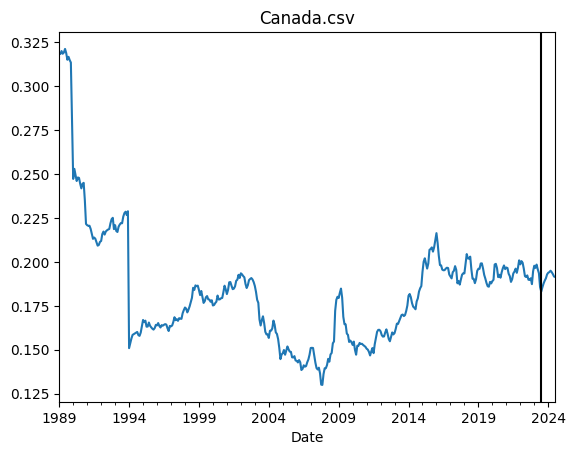

processing Austria.csv


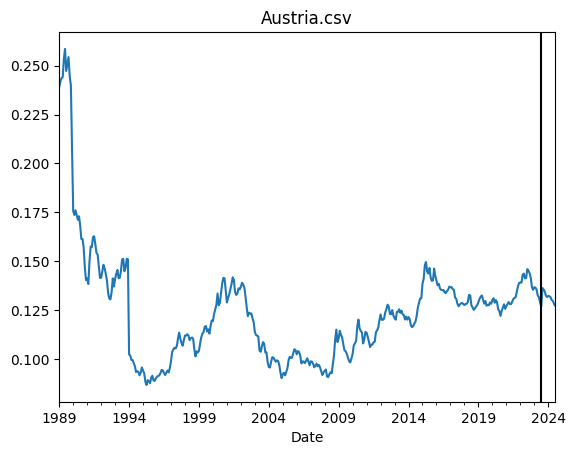

In [94]:
# repeat for ensembling
target = 'FXAgainstChina'

for f in os.listdir(imputed_dir):
    if f.endswith('.csv'):
        print('processing', f)
        country = f.split('.')[0]
        full_df = pd.read_csv(os.path.join(imputed_dir, f))
        full_df['Date'] = pd.to_datetime(full_df['Date'])
        # df = df[df['Date'] < '2020-01-01']
        full_df = full_df.set_index('Date')
        df = full_df.copy()
        
        # forward
        train_full = df[target].asfreq('MS')
        train_y = train_full.dropna()
        train_y, test_y = train_y.iloc[:-4*12], train_y.iloc[-4*12:]
        
        if country in sarima_best_param:
            best_param = sarima_best_param[country]
        else:
            best_param, best_rmse, best_r2 = grid_search_sarimax(train_y, test_y, init_repeat=False, param_grids={'p': range(0, 3), 'q': range(0, 2), 'r': range(0, 3)})
            print(best_param, best_rmse, best_r2)

        train_y = train_full.dropna()
        test_y = train_full[train_full.last_valid_index() + train_full.index.freq:]
        sarima_model = sm.tsa.statespace.SARIMAX(train_y, order=best_param[0], seasonal_order=best_param[1], trend=best_param[2])
        result = sarima_model.fit(disp=False)
        pred = result.forecast(len(test_y)).clip(0.9*full_df[target].min(), 1.1*full_df[target].max())
        rnn_pred = np.asarray(forecast_predictions[country]).clip(0.9*full_df[target].min(), 1.1*full_df[target].max())
        assert len(pred) == len(rnn_pred)
        pred_df = pd.DataFrame({'SARIMAPred': pred, 'RNNPred': rnn_pred}, index=test_y.index)
        sarima_w = 0.5
        pred_df['TargetImputed'] = sarima_w * pred_df['SARIMAPred'] + (1 - sarima_w) * pred_df['RNNPred']
        
        assert sum(full_df.loc[full_df[target].first_valid_index():][target].isna()) == len(pred_df)
        full_df[target] = full_df[target].fillna(full_df.merge(pred_df, how='left', left_index=True, right_index=True)['TargetImputed'])
        full_df.reset_index(names='Date')
        full_df[target].plot()
        plt.title(f)
        plt.axvline(train_y.index.max(), color='black')
        plt.show()
        full_df.to_csv(os.path.join(imputed_dir, f))
        # break

processing Japan.csv
('elastic', 'standard', {'alphas': None, 'copy_X': True, 'cv': None, 'eps': 0.001, 'fit_intercept': True, 'l1_ratio': [0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1.0], 'max_iter': 1000, 'n_alphas': 100, 'n_jobs': None, 'positive': False, 'precompute': 'auto', 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'verbose': 0}) 0.5386067914822968


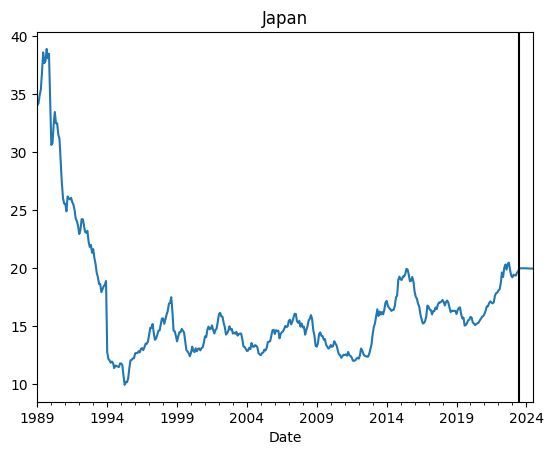

processing Korea (ROK).csv
('elastic', 'minmax', {'alphas': None, 'copy_X': True, 'cv': None, 'eps': 0.001, 'fit_intercept': True, 'l1_ratio': [0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1.0], 'max_iter': 1000, 'n_alphas': 100, 'n_jobs': None, 'positive': False, 'precompute': 'auto', 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'verbose': 0}) 5.19145235949356


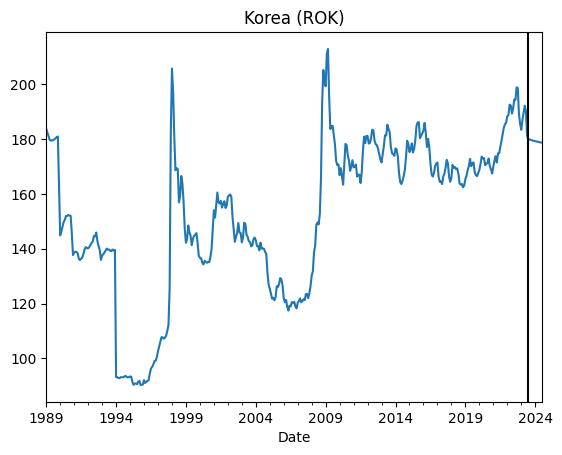

processing Chile.csv
('elastic', 'standard', {'alphas': None, 'copy_X': True, 'cv': None, 'eps': 0.001, 'fit_intercept': True, 'l1_ratio': [0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1.0], 'max_iter': 1000, 'n_alphas': 100, 'n_jobs': None, 'positive': False, 'precompute': 'auto', 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'verbose': 0}) 2.5373462858566223


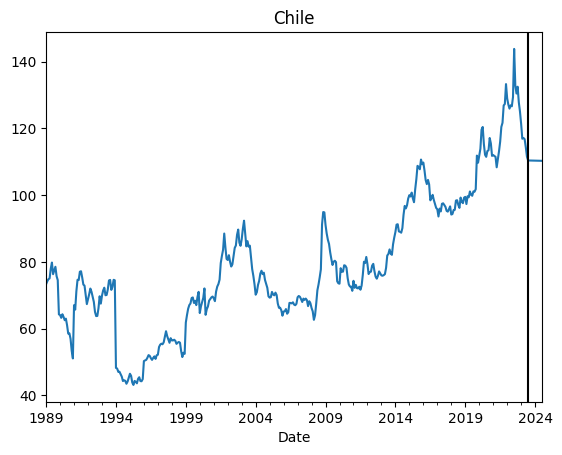

processing Maldives.csv
('svr', 'minmax', {'C': 1.0, 'dual': True, 'epsilon': 0.0, 'fit_intercept': True, 'intercept_scaling': 1.0, 'loss': 'epsilon_insensitive', 'max_iter': 1000, 'random_state': None, 'tol': 0.0001, 'verbose': 0}) 0.04568507444629184


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


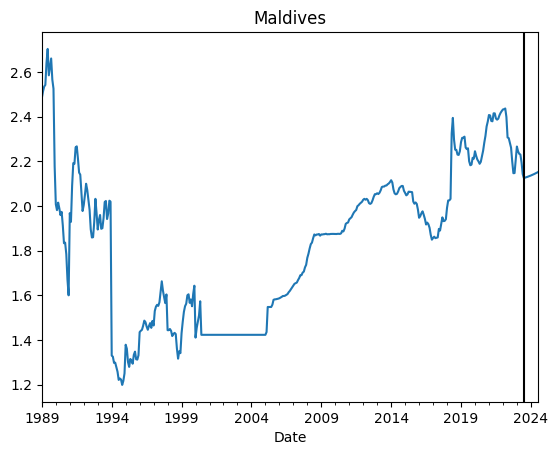

processing Cambodia.csv
('elastic', 'minmax', {'alphas': None, 'copy_X': True, 'cv': None, 'eps': 0.001, 'fit_intercept': True, 'l1_ratio': [0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1.0], 'max_iter': 1000, 'n_alphas': 100, 'n_jobs': None, 'positive': False, 'precompute': 'auto', 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'verbose': 0}) 14.75232936781416


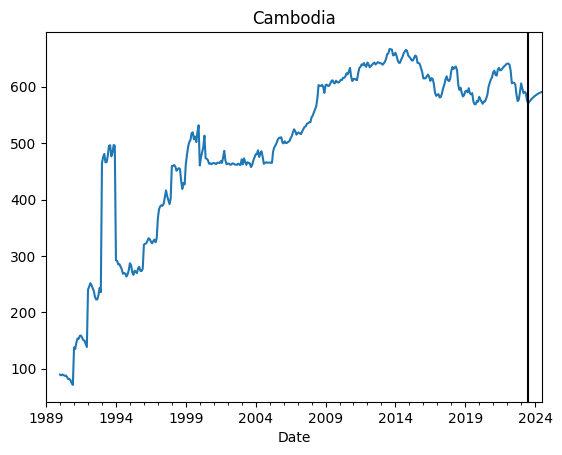

processing Singapore.csv
('elastic', 'standard', {'alphas': None, 'copy_X': True, 'cv': None, 'eps': 0.001, 'fit_intercept': True, 'l1_ratio': [0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1.0], 'max_iter': 1000, 'n_alphas': 100, 'n_jobs': None, 'positive': False, 'precompute': 'auto', 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'verbose': 0}) 0.0049957644159568035


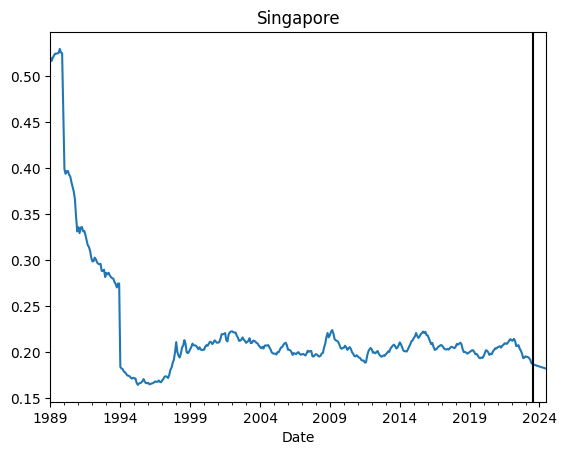

processing USA.csv
('elastic', 'minmax', {'alphas': None, 'copy_X': True, 'cv': None, 'eps': 0.001, 'fit_intercept': True, 'l1_ratio': [0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1.0], 'max_iter': 1000, 'n_alphas': 100, 'n_jobs': None, 'positive': False, 'precompute': 'auto', 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'verbose': 0}) 0.00241965369766562


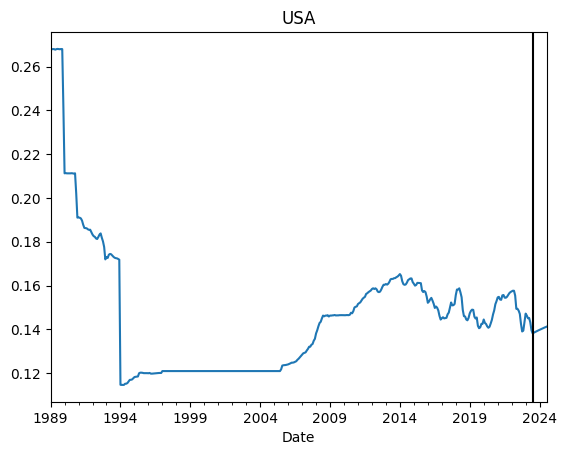

processing Chinese Taipei.csv
('ridge', 'standard', {'alpha_per_target': False, 'alphas': (0.1, 0.25, 0.5, 1.0, 5.0, 10.0), 'cv': None, 'fit_intercept': True, 'gcv_mode': None, 'scoring': None, 'store_cv_values': False}) 0.08752329606282452


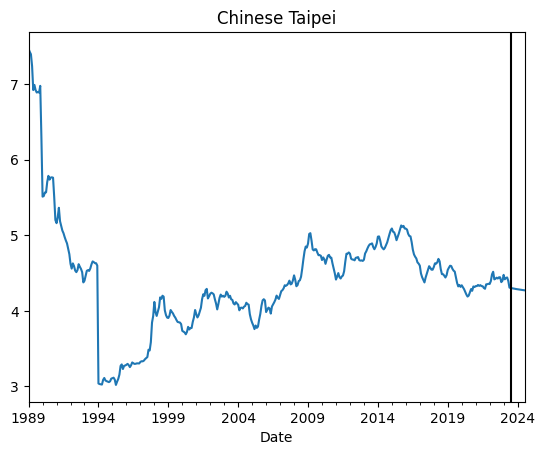

processing Thailand.csv
('elastic', 'standard', {'alphas': None, 'copy_X': True, 'cv': None, 'eps': 0.001, 'fit_intercept': True, 'l1_ratio': [0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1.0], 'max_iter': 1000, 'n_alphas': 100, 'n_jobs': None, 'positive': False, 'precompute': 'auto', 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'verbose': 0}) 0.12953937819734782


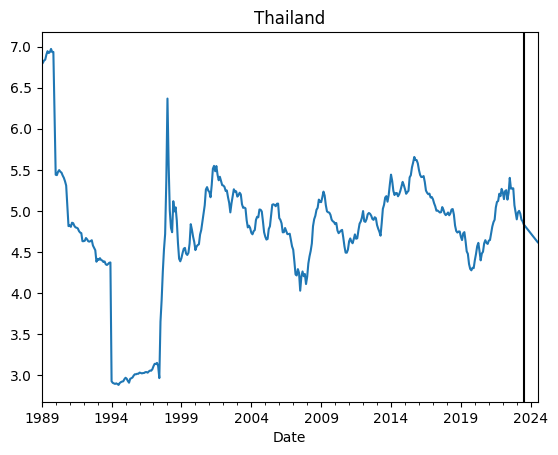

processing Indonesia.csv
('elastic', 'standard', {'alphas': None, 'copy_X': True, 'cv': None, 'eps': 0.001, 'fit_intercept': True, 'l1_ratio': [0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1.0], 'max_iter': 1000, 'n_alphas': 100, 'n_jobs': None, 'positive': False, 'precompute': 'auto', 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'verbose': 0}) 58.30125577569389


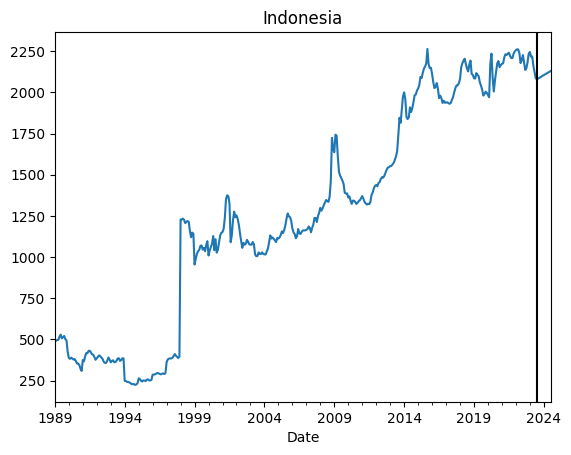

processing Turkey.csv
('ridge', 'standard', {'alpha_per_target': False, 'alphas': (0.1, 0.25, 0.5, 1.0, 5.0, 10.0), 'cv': None, 'fit_intercept': True, 'gcv_mode': None, 'scoring': None, 'store_cv_values': False}) 0.012959246512482248


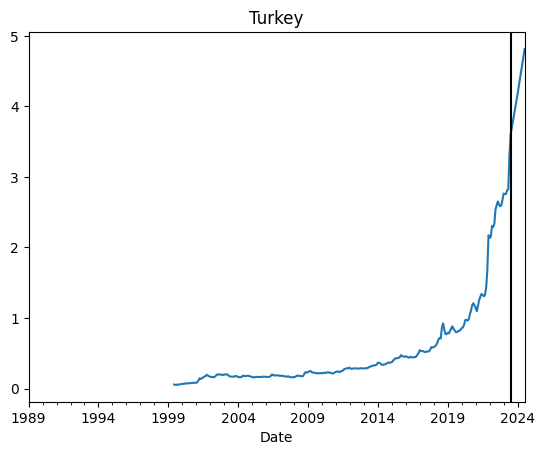

processing Macao, China.csv
('svr', 'minmax', {'C': 1.0, 'dual': True, 'epsilon': 0.0, 'fit_intercept': True, 'intercept_scaling': 1.0, 'loss': 'epsilon_insensitive', 'max_iter': 1000, 'random_state': None, 'tol': 0.0001, 'verbose': 0}) 0.029736698995222847


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


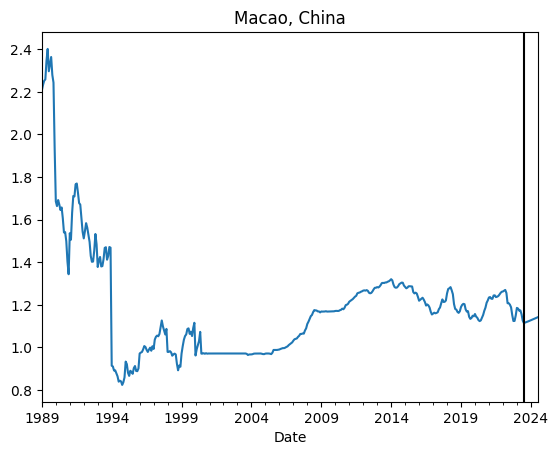

processing Australia.csv
('elastic', 'standard', {'alphas': None, 'copy_X': True, 'cv': None, 'eps': 0.001, 'fit_intercept': True, 'l1_ratio': [0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1.0], 'max_iter': 1000, 'n_alphas': 100, 'n_jobs': None, 'positive': False, 'precompute': 'auto', 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'verbose': 0}) 0.006549437004249719


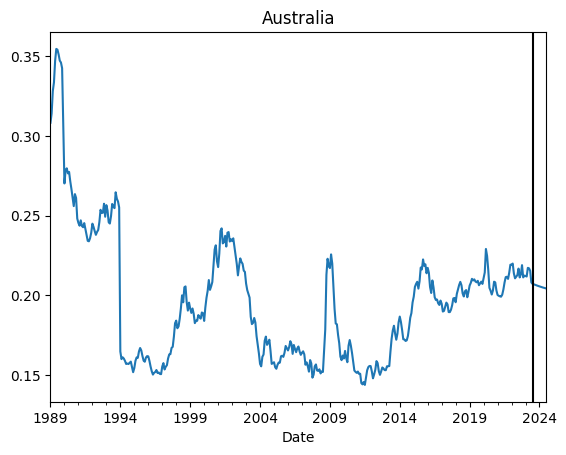

processing New Zealand.csv
('elastic', 'standard', {'alphas': None, 'copy_X': True, 'cv': None, 'eps': 0.001, 'fit_intercept': True, 'l1_ratio': [0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1.0], 'max_iter': 1000, 'n_alphas': 100, 'n_jobs': None, 'positive': False, 'precompute': 'auto', 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'verbose': 0}) 0.008013986793860572


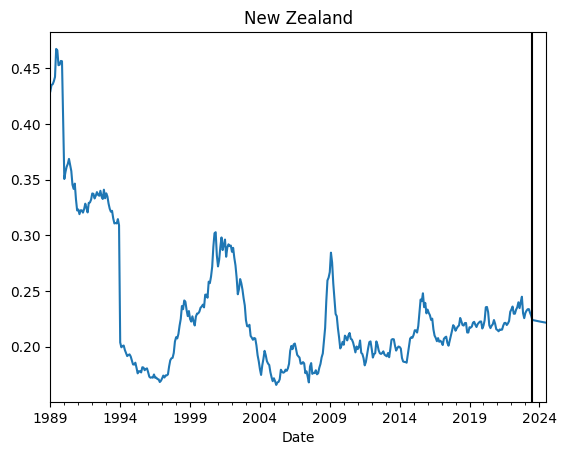

processing Czech.csv
('elastic', 'standard', {'alphas': None, 'copy_X': True, 'cv': None, 'eps': 0.001, 'fit_intercept': True, 'l1_ratio': [0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1.0], 'max_iter': 1000, 'n_alphas': 100, 'n_jobs': None, 'positive': False, 'precompute': 'auto', 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'verbose': 0}) 0.14139057815144093


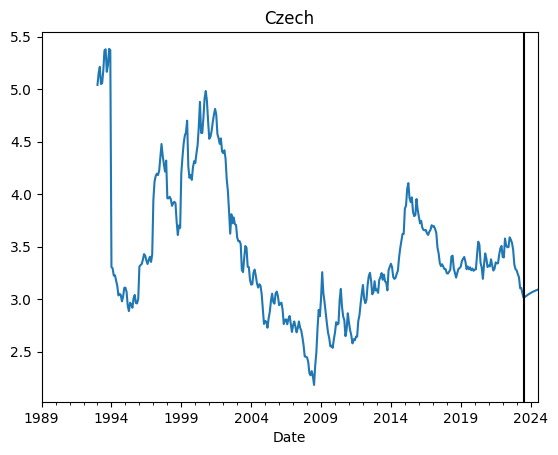

processing Hawaii.csv
('elastic', 'minmax', {'alphas': None, 'copy_X': True, 'cv': None, 'eps': 0.001, 'fit_intercept': True, 'l1_ratio': [0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1.0], 'max_iter': 1000, 'n_alphas': 100, 'n_jobs': None, 'positive': False, 'precompute': 'auto', 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'verbose': 0}) 0.0008420450447891255


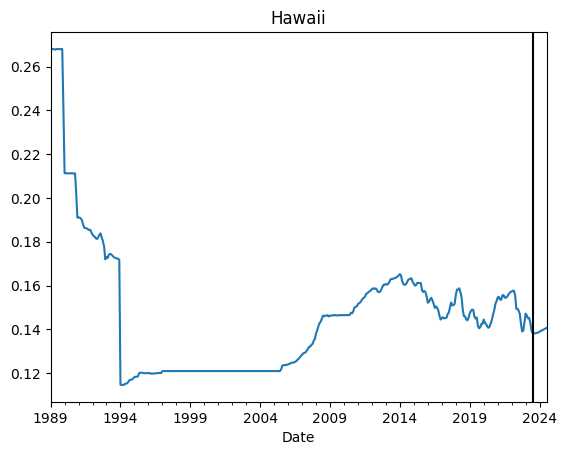

processing Mexico.csv
('elastic', 'standard', {'alphas': None, 'copy_X': True, 'cv': None, 'eps': 0.001, 'fit_intercept': True, 'l1_ratio': [0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1.0], 'max_iter': 1000, 'n_alphas': 100, 'n_jobs': None, 'positive': False, 'precompute': 'auto', 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'verbose': 0}) 0.04503594300430704


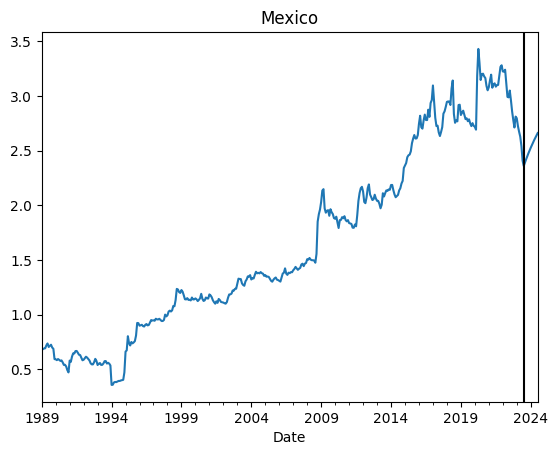

processing Hong Kong SAR.csv
('svr', 'standard', {'C': 1.0, 'dual': True, 'epsilon': 0.0, 'fit_intercept': True, 'intercept_scaling': 1.0, 'loss': 'epsilon_insensitive', 'max_iter': 1000, 'random_state': None, 'tol': 0.0001, 'verbose': 0}) 0.01792806034594442


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


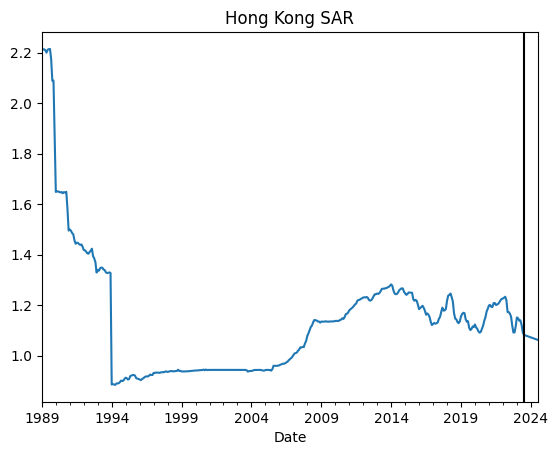

processing Canada.csv
('ridge', 'standard', {'alpha_per_target': False, 'alphas': (0.1, 0.25, 0.5, 1.0, 5.0, 10.0), 'cv': None, 'fit_intercept': True, 'gcv_mode': None, 'scoring': None, 'store_cv_values': False}) 0.0045038295100394915


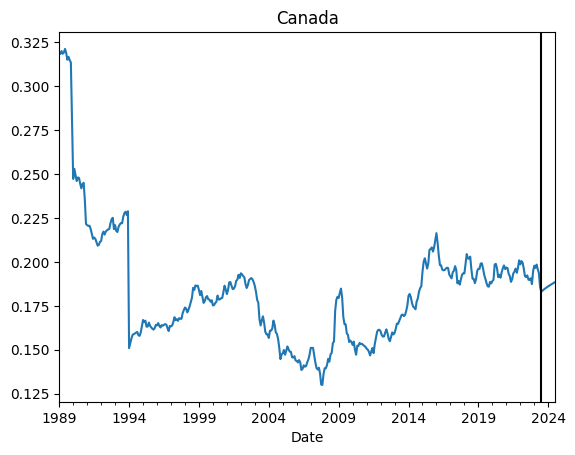

processing Austria.csv
('elastic', 'standard', {'alphas': None, 'copy_X': True, 'cv': None, 'eps': 0.001, 'fit_intercept': True, 'l1_ratio': [0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1.0], 'max_iter': 1000, 'n_alphas': 100, 'n_jobs': None, 'positive': False, 'precompute': 'auto', 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'verbose': 0}) 0.0038394278803415157


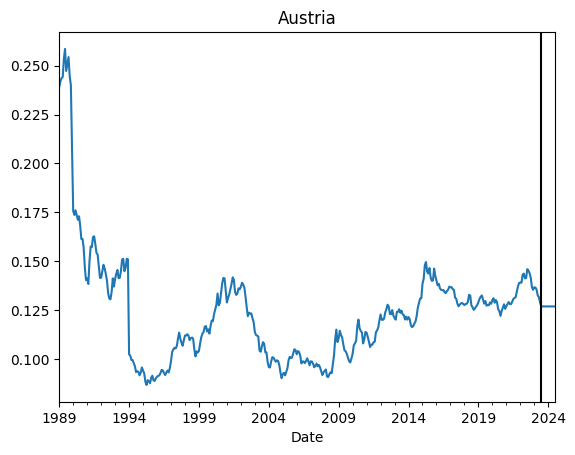

In [93]:
# repeat for regression all countries, nonsense flat forecast
candidates = ['GDPPerCap', 'GDP', 'Population', 'GDPRatioChina', 'GDPPerCapRatioChina', 'GDPGrowthDiffChina', 'GDPPerCapGrowthDiffChina']
target = 'FXAgainstChina'
final_reg_preds = {}
for f in os.listdir(imputed_dir):
    if f.endswith('.csv'):
        country = f.split('.')[0]
        print('processing', f)
        df = pd.read_csv(os.path.join(imputed_dir, f))
        df['Date'] = pd.to_datetime(df['Date'])
        # df = df[df['Date'] < '2020-01-01']
        # df = df.set_index('Date')

        train_df = df[[target] + candidates].dropna()
        train_x, train_y = train_df[candidates], train_df[target]
        
        train_y, train_x, _ = dummy_lagged_df(train_y, train_x, lag=1)

        train_x, test_x, train_y, test_y = train_x.iloc[:-4*12], train_x.iloc[-4*12:], train_y.iloc[:-4*12], train_y.iloc[-4*12:]
        # sample_weight = get_sample_weight(0.5, 1.0, len(train_x))

        best_param, best_rmse = grid_search_ml(train_x, train_y, #sample_weight=sample_weight,
                                                 additional_params={'rf': [{'n_estimators': n} for n in (5, 10, 50, 100)],
                                                                    'mlp': [{'hidden_layer_sizes': n} for n in (1, 3, 5, 10)],
                                                                    'xgb': [{'n_estimators': n} for n in (5, 10, 50, 100)]})
        print(best_param, best_rmse)
        train_df = df.iloc[df[target].first_valid_index():]
        _, train_x, added_col = dummy_lagged_df(train_df[target], dropna=False, lag=1)
        train_df = pd.concat([train_df[[target] + candidates], train_x], axis=1).reset_index(drop=True)
        train_df, test_df = train_df.iloc[:train_df[target].last_valid_index()].dropna(), train_df.iloc[train_df[target].last_valid_index()+1:]
        
        train_x, train_y = train_df[candidates + added_col], train_df[target]
        
        model = get_model(best_param[0])
        model = model.set_params(**best_param[2])
        scaler = get_scaler(best_param[1])
        train_x_ = scaler.fit_transform(train_x)
        test_x_ = scaler.transform(test_x)
        model.fit(train_x_, train_y,)# sample_weight=sample_weight)
        final_reg_preds[country] = []
        for i in range(len(test_df)):
            row = test_df.iloc[i:i + 1][candidates + added_col]
            for l in range(1, 2):
                if row['TargetLag' + str(l)].isna().sum() > 0:
                    assert len(final_reg_preds[country]) >= l
                    row.iloc[0, row.columns.get_loc('TargetLag' + str(l))] = final_reg_preds[country][-l]
                assert row['TargetLag' + str(l)].isna().sum() == 0
            x = scaler.transform(row)
            y = model.predict(x)[0]
            final_reg_preds[country].append(y)
        
        full_df = df.copy().set_index('Date')
        end_date = full_df[target].last_valid_index()

        # combination reg pred
        df.loc[df[target].last_valid_index() + 1:, target] = final_reg_preds[country]
        df = df.set_index('Date').resample('MS').ffill()

        full_df[target] = full_df[target].fillna(df[target]).ffill()
        full_df.reset_index(names='Date')
        full_df[target].plot()
        plt.title(country)
        plt.axvline(end_date, color='black')
        plt.show()
        # break
        # full_df.to_csv(os.path.join(imputed_dir, f))
        

processing Japan.csv
[(1, 1, 0), (0, 1, 1, 12), 'c'] 0.885307777209198 0.772711278977917


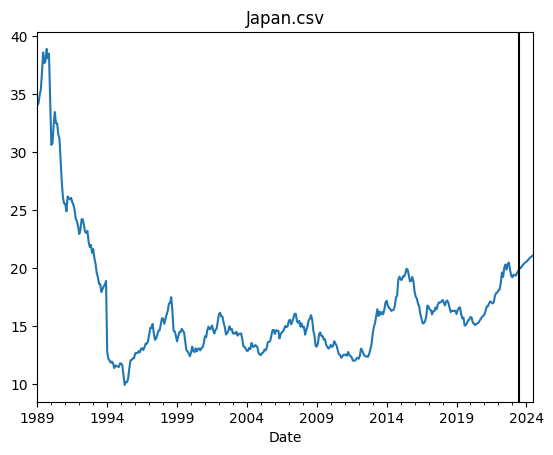

processing Korea (ROK).csv
[(1, 1, 0), (1, 1, 0, 12), 'c'] 5.7967455823793905 0.6385732076475366


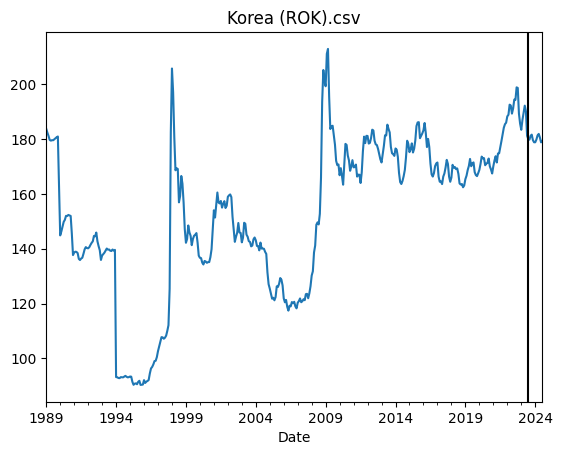

processing Chile.csv
[(0, 1, 2), (0, 1, 0, 12), 'c'] 13.13586183955123 -1.0929344170832431


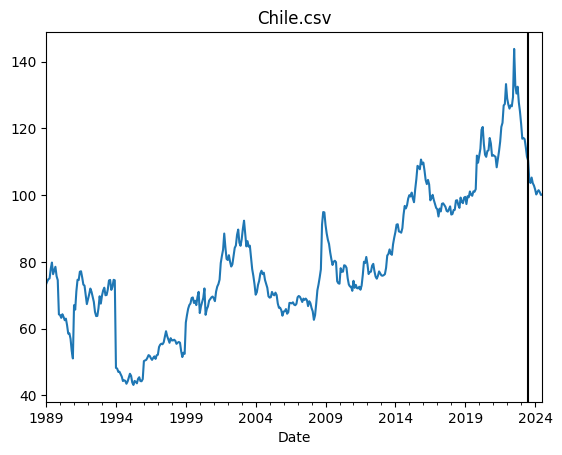

processing Maldives.csv
None 0.09859053854368247 -0.033106417406199906


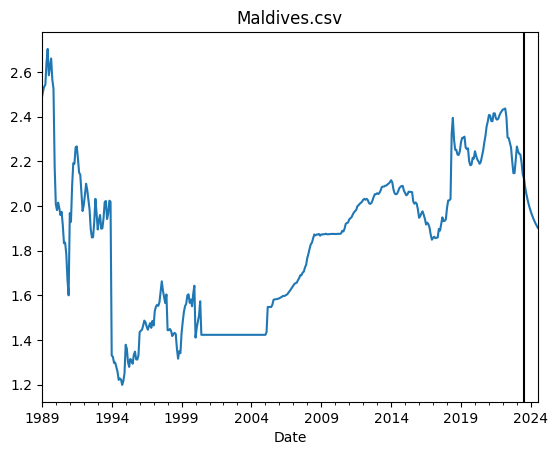

processing Cambodia.csv
[(0, 0, 1), (1, 1, 1, 12), 'n'] 24.261415973033817 0.030285719201645023


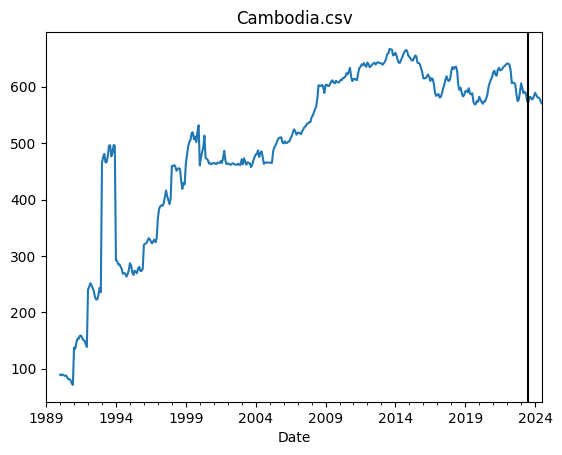

processing Singapore.csv
[(1, 0, 1), (1, 1, 1, 12), 'n'] 0.007231266903346869 -0.01047844212560256


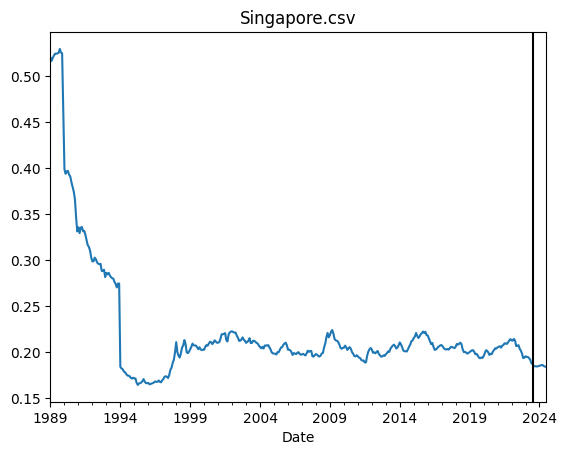

processing USA.csv
[(0, 0, 0), (0, 0, 1, 12), 'c'] 0.005376147816357612 0.2542475645552491


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


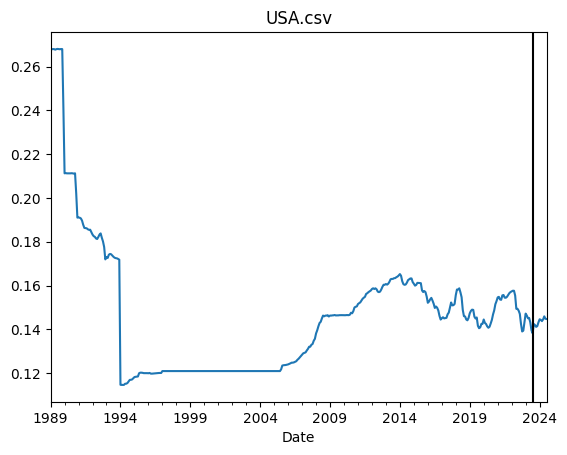

processing Chinese Taipei.csv
[(0, 0, 0), (0, 0, 0, 12), 'c'] 0.09708230260182105 -0.7452570566334573


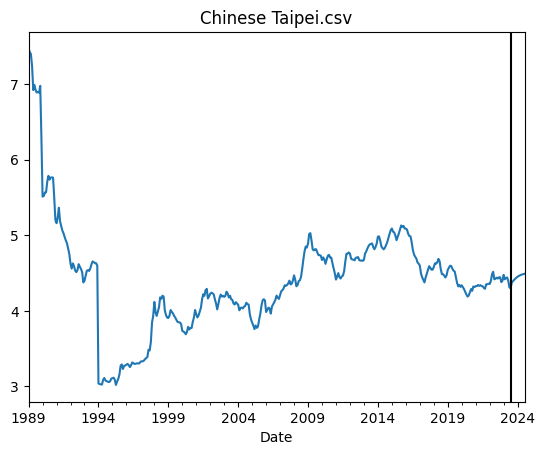

processing Thailand.csv
[(2, 1, 1), (1, 1, 1, 12), 'c'] 0.26060335110503324 0.36937399678270233


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


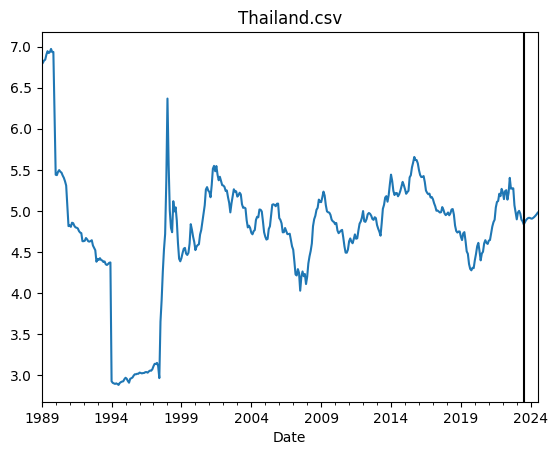

processing Indonesia.csv
[(1, 1, 0), (1, 1, 1, 12), 'n'] 73.58963785493161 0.2921355588327381


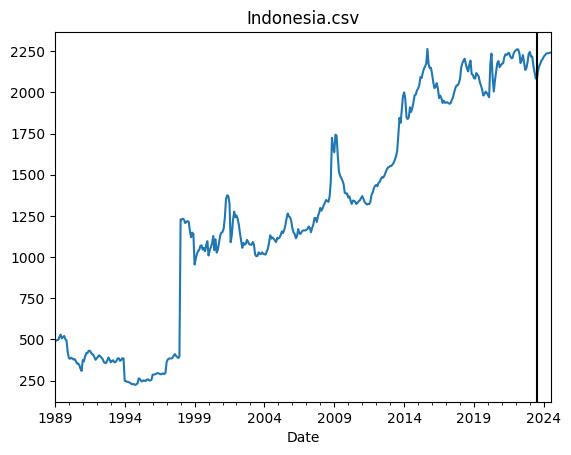

processing Turkey.csv
[(2, 1, 2), (1, 1, 0, 12), 'c'] 0.832034167147965 -0.06754050837038439


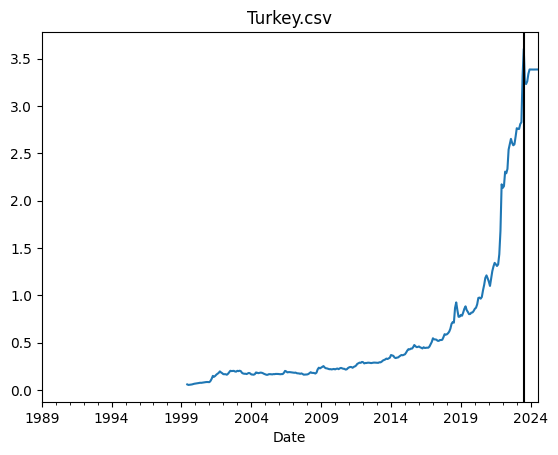

processing Macao, China.csv
[(0, 0, 0), (0, 0, 1, 12), 'c'] 0.043824345159825716 0.18940238272199994


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


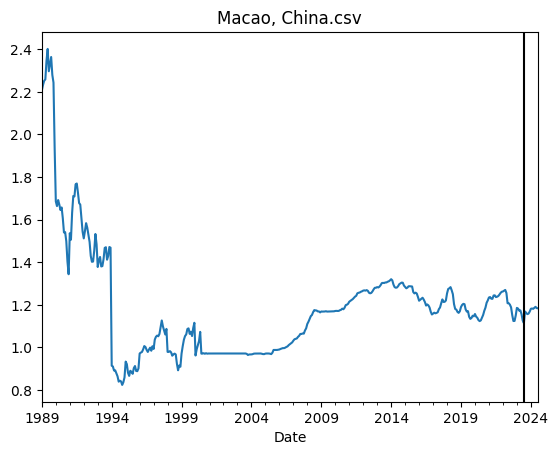

processing Australia.csv
[(2, 0, 2), (0, 0, 0, 12), 'c'] 0.00653477850574442 0.024995143953787435


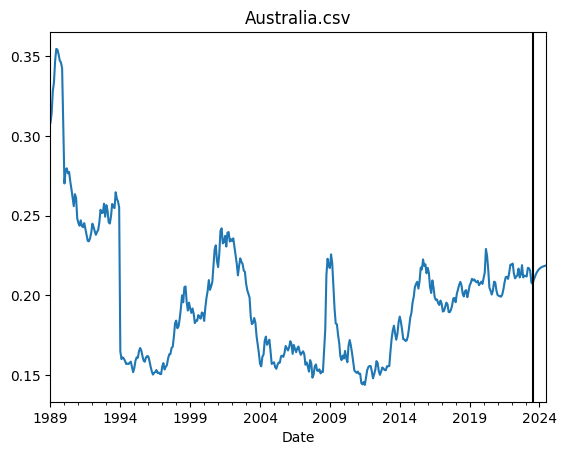

processing New Zealand.csv
[(2, 0, 2), (1, 0, 0, 12), 'c'] 0.006680254804279749 0.27802803879508686


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


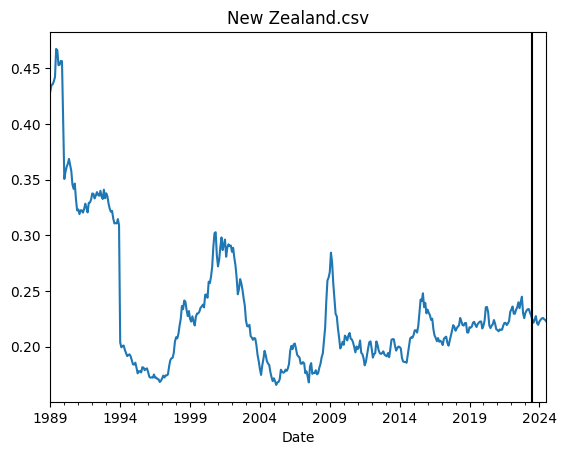

processing Czech.csv
[(2, 1, 1), (0, 0, 0, 12), 'n'] 0.13670651951501223 -0.058141742562868526


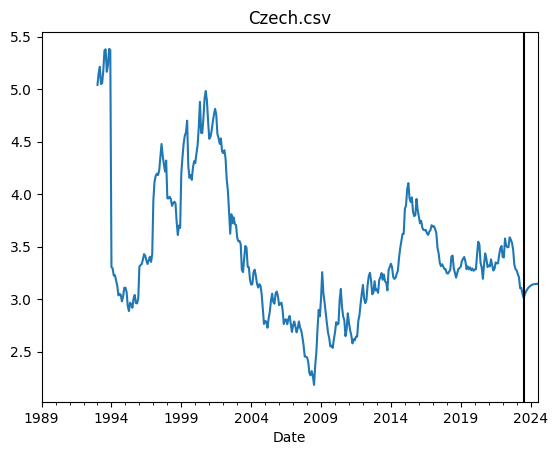

processing Hawaii.csv
[(0, 0, 0), (0, 0, 1, 12), 'c'] 0.005376147816357612 0.2542475645552491


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


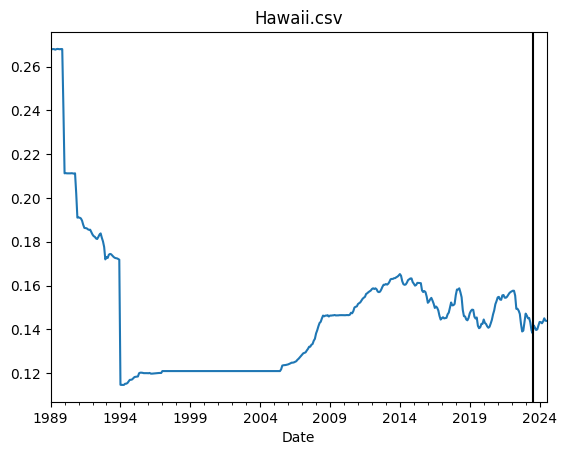

processing Mexico.csv
[(1, 0, 2), (1, 1, 0, 12), 'n'] 0.2615327576116882 -0.11062622390566168


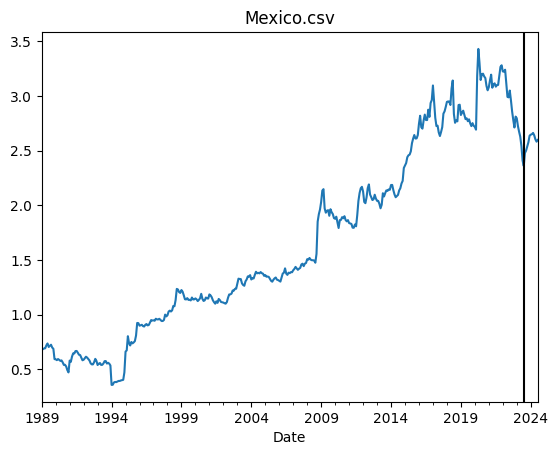

processing Hong Kong SAR.csv
[(0, 0, 0), (0, 0, 1, 12), 'c'] 0.040023652515036 0.2828051516566201


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


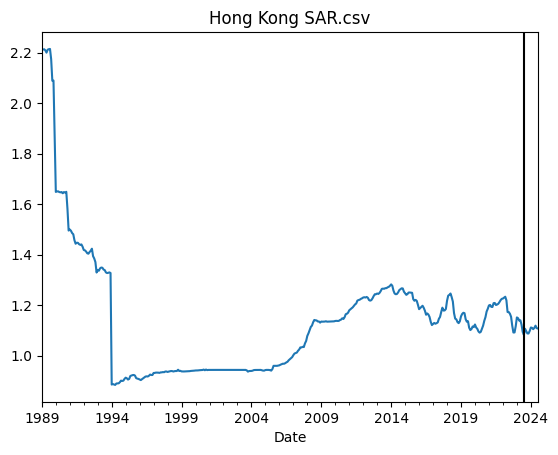

processing Canada.csv
[(1, 0, 1), (1, 0, 1, 12), 'c'] 0.003982608800481525 0.15232161539515643


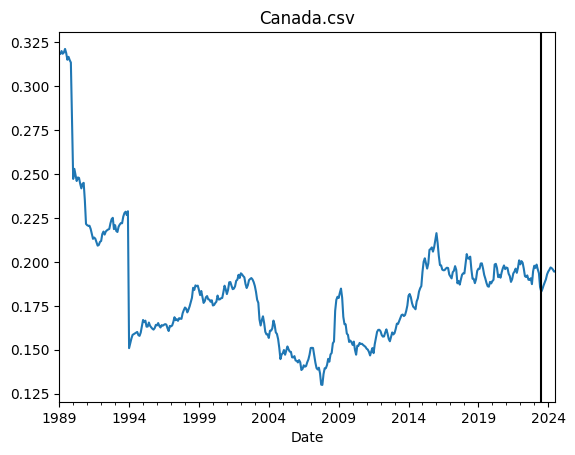

processing Austria.csv
[(0, 0, 0), (1, 0, 0, 12), 'c'] 0.005436103285490503 0.23967506946197148


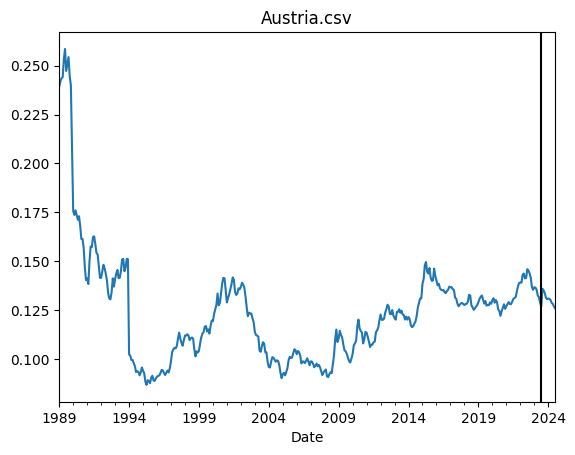

In [86]:
# repeat for ensembling but use repeating forecast if cant fit
target = 'FXAgainstChina'

for f in os.listdir(imputed_dir):
    if f.endswith('.csv'):
        print('processing', f)
        country = f.split('.')[0]
        full_df = pd.read_csv(os.path.join(imputed_dir, f))
        full_df['Date'] = pd.to_datetime(full_df['Date'])
        # df = df[df['Date'] < '2020-01-01']
        full_df = full_df.set_index('Date')
        df = full_df.copy()
        
        # forward
        train_full = df[target].asfreq('MS')
        train_y = train_full.dropna()
        train_y, test_y = train_y.iloc[:-4*12], train_y.iloc[-4*12:]
        
        best_param, best_rmse, best_r2 = grid_search_sarimax(train_y, test_y, init_repeat=True, param_grids={'p': range(0, 3), 'q': range(0, 2), 'r': range(0, 3)})
        print(best_param, best_rmse, best_r2)
        train_y = train_full.dropna()
        test_y = train_full[train_full.last_valid_index() + train_full.index.freq:]
        if best_param is None:
            pred = np.asarray(forecast_predictions[country]).clip(0.9*full_df[target].min(), 1.1*full_df[target].max()).copy()
        else:
            sarima_model = sm.tsa.statespace.SARIMAX(train_y, order=best_param[0], seasonal_order=best_param[1], trend=best_param[2])
            result = sarima_model.fit(disp=False)
            pred = result.forecast(len(test_y)).clip(0.9*full_df[target].min(), 1.1*full_df[target].max())
        rnn_pred = np.asarray(forecast_predictions[country]).clip(0.9*full_df[target].min(), 1.1*full_df[target].max())
        assert len(pred) == len(rnn_pred)
        pred_df = pd.DataFrame({'SARIMAPred': pred, 'RNNPred': rnn_pred}, index=test_y.index)
        sarima_w = 0.5
        pred_df['TargetImputed'] = sarima_w * pred_df['SARIMAPred'] + (1 - sarima_w) * pred_df['RNNPred']
        
        assert sum(full_df.loc[full_df[target].first_valid_index():][target].isna()) == len(pred_df)
        full_df[target] = full_df[target].fillna(full_df.merge(pred_df, how='left', left_index=True, right_index=True)['TargetImputed'])
        full_df.reset_index(names='Date')
        full_df[target].plot()
        plt.title(f)
        plt.axvline(train_y.index.max(), color='black')
        plt.show()
        # full_df.to_csv(os.path.join(imputed_dir, f))
        # break

In [170]:
# repeat for all countries for rnn model
# no need to rerun for forecast
# best_param, best_rmse = grid_search_rnn(reverse=False, verbose=False)
candidates = ['GDPPerCap', 'GDP', 'Population', 'Country', 'GDPRatioChina', 'GDPPerCapRatioChina', 'GDPGrowthDiffChina', 'GDPPerCapGrowthDiffChina']
target = 'FXAgainstChina'
best_param = ({'preprocess': 'standard', 'seq_len': 50, 'batch_size': 128}, 
              {'model_type': 'lstm', 'num_layers': 1, 'hidden_size': 15}, 
              {'optim_type': 'rmsprop', 'lr': 0.00005})

Epoch 0: train loss 0.7389, time 3.5003
Epoch 1: train loss 0.3295, time 3.1075
Epoch 2: train loss 0.2003, time 3.0652
Epoch 3: train loss 0.1329, time 3.0277
Epoch 4: train loss 0.0879, time 3.0268
Epoch 5: train loss 0.0604, time 3.0263
Epoch 6: train loss 0.0430, time 3.0499
Epoch 7: train loss 0.0307, time 3.1259
Epoch 8: train loss 0.0210, time 3.1139
Epoch 9: train loss 0.0142, time 3.1219
Epoch 10: train loss 0.0098, time 3.1319
Epoch 11: train loss 0.0071, time 3.1419
Epoch 12: train loss 0.0055, time 3.1384
Epoch 13: train loss 0.0045, time 3.1544
Epoch 14: train loss 0.0040, time 3.1322
warning not converged


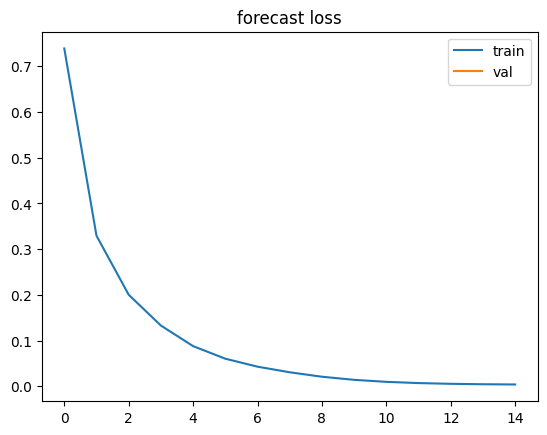

In [172]:
seq_train_x, seq_train_y, seq_test_x, seq_test_y, x_scaler, y_scaler, train_country = load_data_forecast(imputed_dir, candidates, target, best_param[0]['seq_len'], freq='MS', reverse=False, preprocess=best_param[0]['preprocess'])
model = ForecastModel(**best_param[1], input_size=8, conditional_labels=np.unique(train_country).tolist())
optimizer = get_torch_optimizer(best_param[2]['optim_type'], model.parameters(), lr=best_param[2]['lr'])
criterion = nn.MSELoss()

# seq_train_x, seq_train_y, seq_val_x, seq_val_y = seq_train_x[:-3], seq_train_y[:-3], seq_train_x[-3:], seq_train_y[-3:]
train_dataset = TimeSeriesDataset(seq_train_x, seq_train_y,)# (model.num_layers, model.hidden_size))
# val_dataset = TimeSeriesDataset(seq_val_x, seq_val_y,)# (model.num_layers, model.hidden_size))
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=best_param[0]['batch_size'], pin_memory=True)
# val_dataloader = DataLoader(val_dataset, shuffle=False, batch_size=1, pin_memory=True)

model, train_losses, val_losses = train_rnn(model, criterion, optimizer, train_dataloader, cuda=True, verbose=True, epochs=15)
forecast_predictions = one_step_prediction(model, seq_test_x, x_scaler, y_scaler)
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.title('forecast loss')
plt.legend()
plt.show()

processing Japan.csv


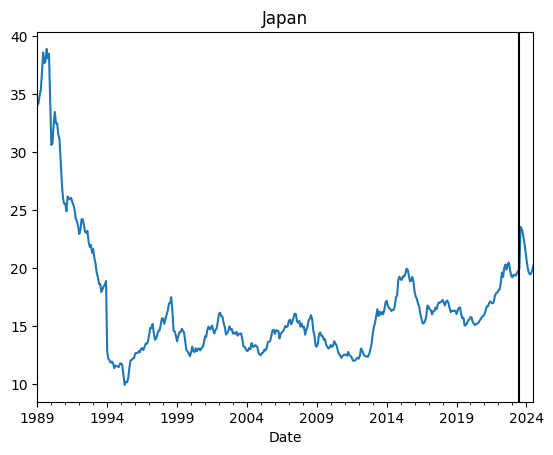

processing Korea (ROK).csv


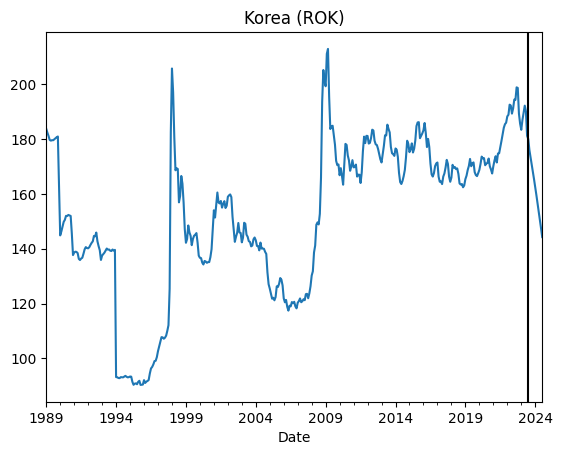

processing Chile.csv


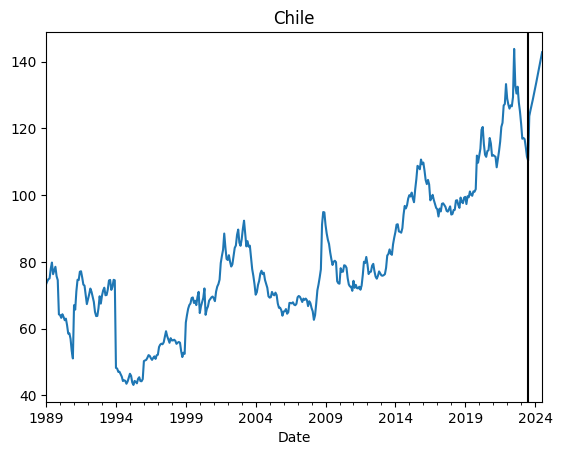

processing Maldives.csv


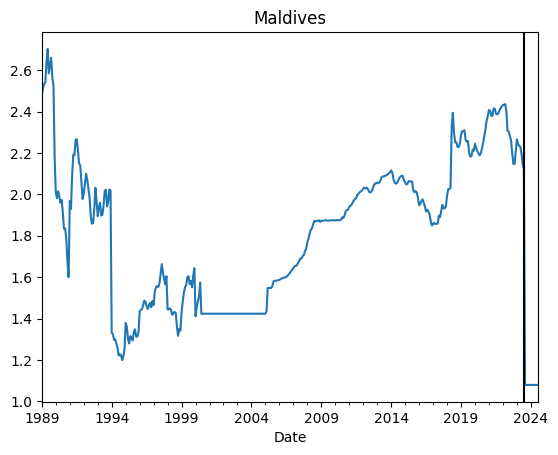

processing Cambodia.csv


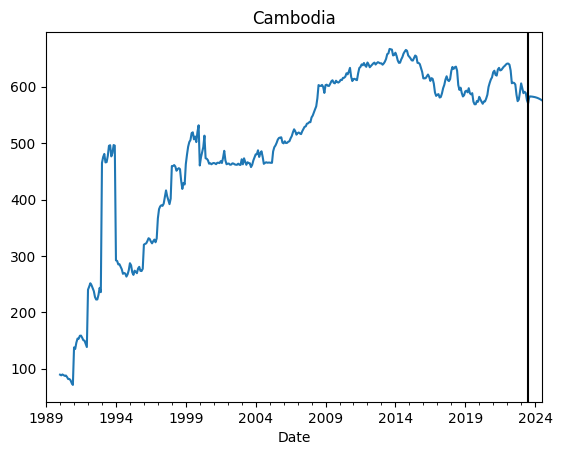

processing Singapore.csv


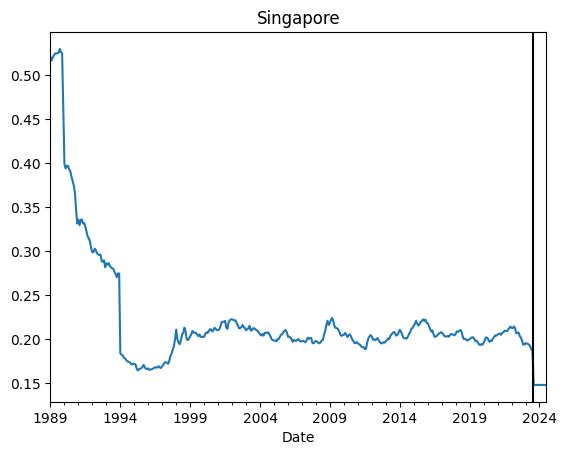

processing USA.csv


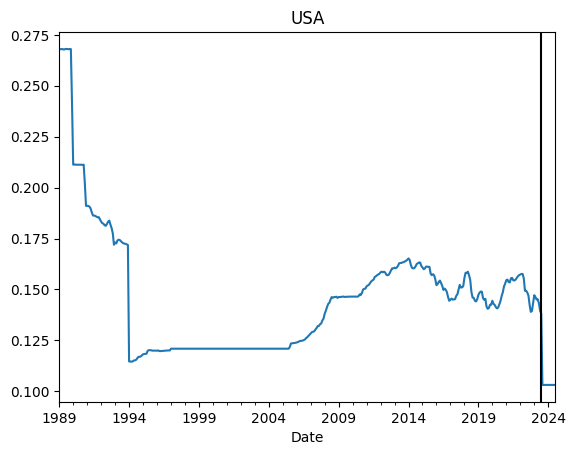

processing Chinese Taipei.csv


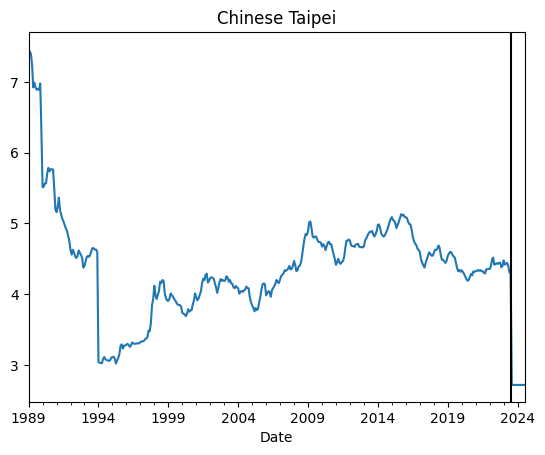

processing Thailand.csv


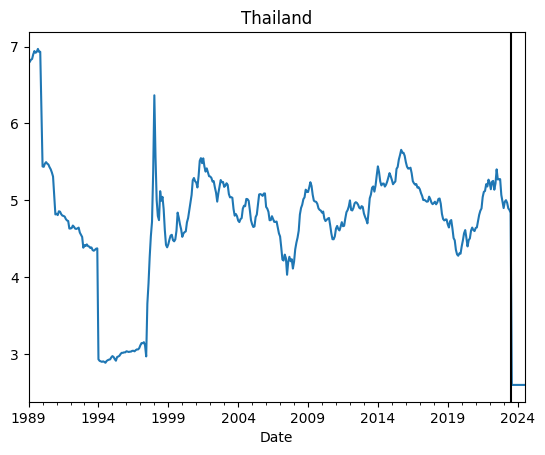

processing Indonesia.csv


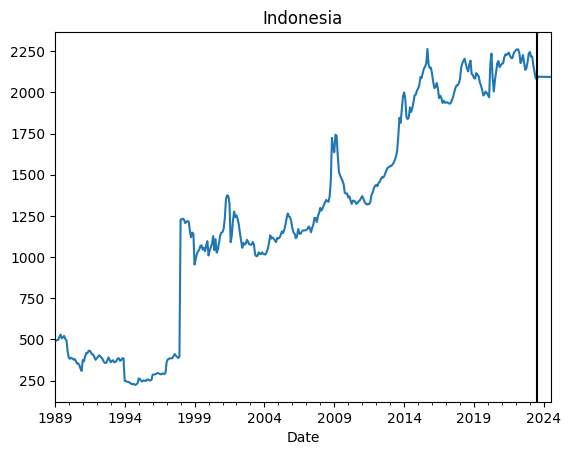

processing Turkey.csv


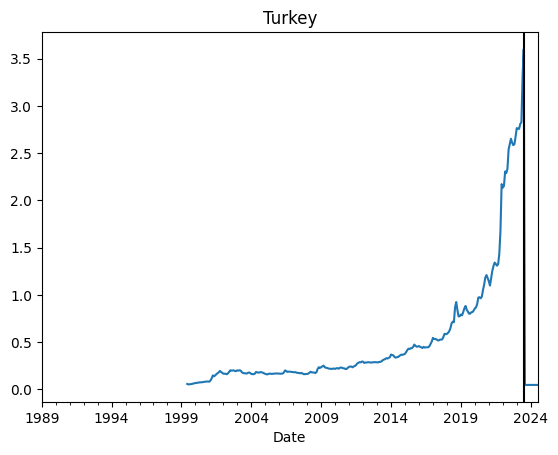

processing Macao, China.csv


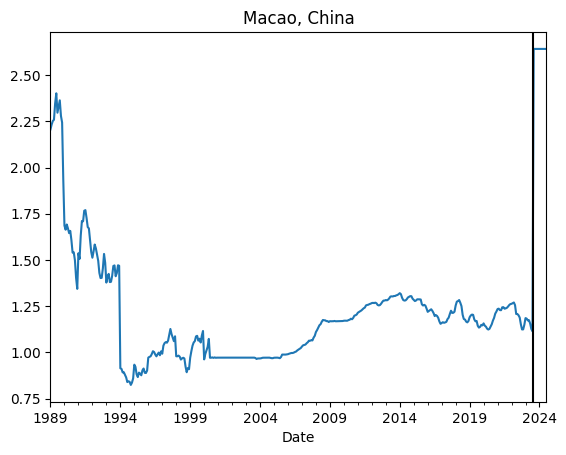

processing Australia.csv


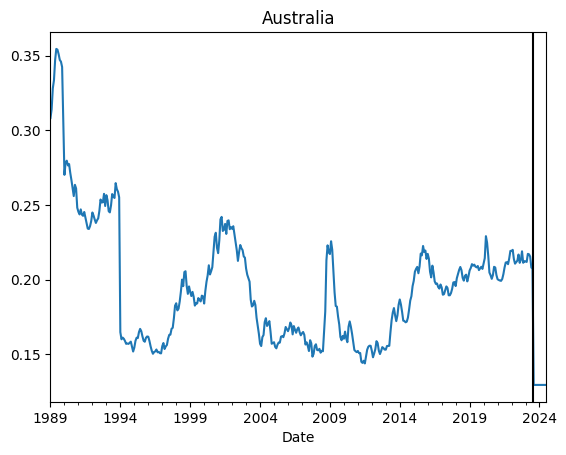

processing New Zealand.csv


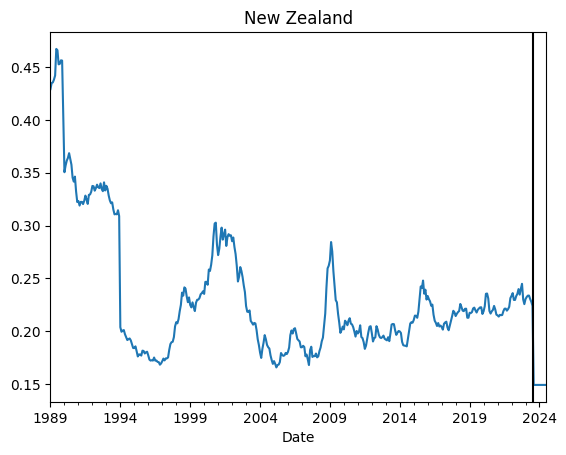

processing Czech.csv


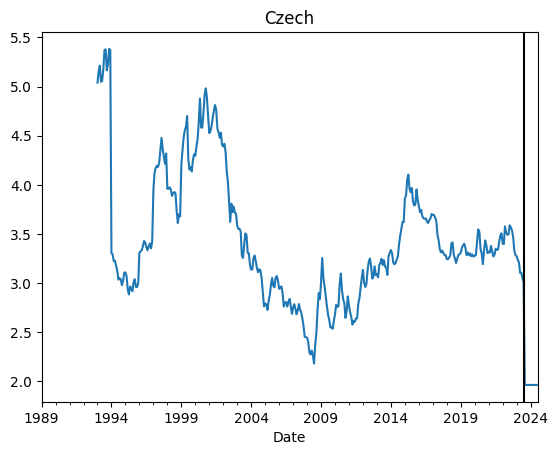

processing Hawaii.csv


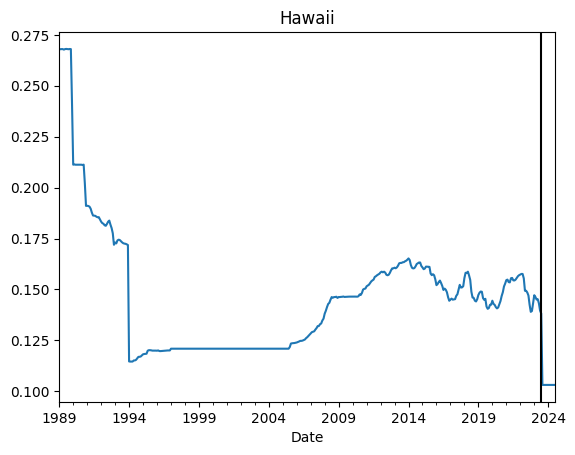

processing Mexico.csv


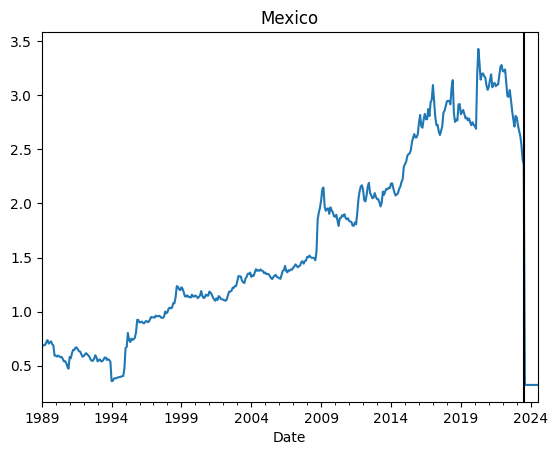

processing Hong Kong SAR.csv


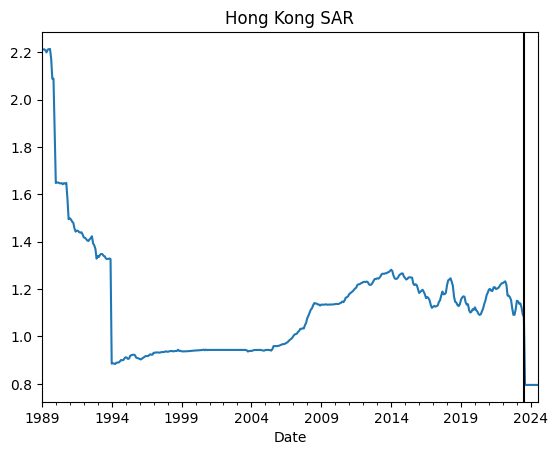

processing Canada.csv


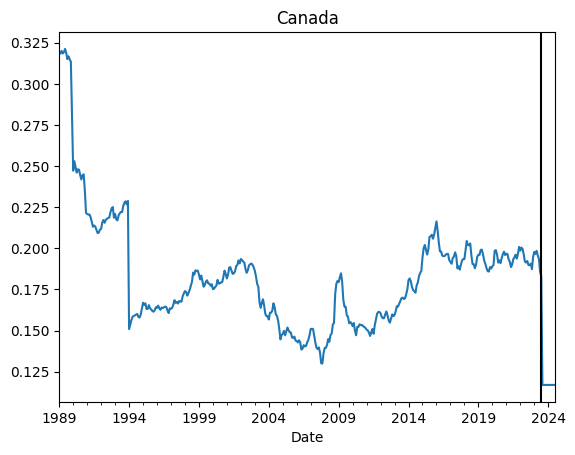

processing Austria.csv


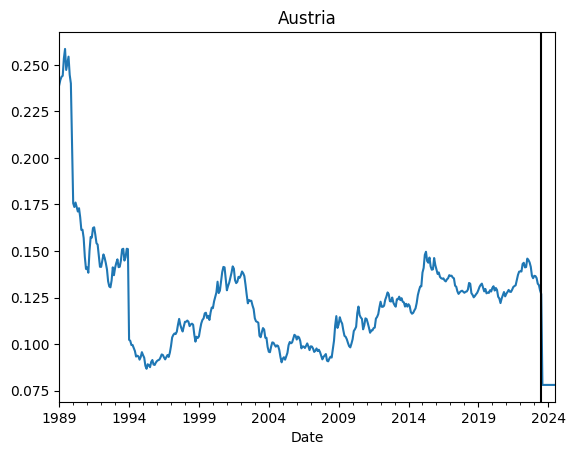

In [189]:
for f in os.listdir(imputed_dir):
    if f.endswith('.csv'):
        print('processing', f)
        country = f.split('.')[0]
        full_df = pd.read_csv(os.path.join(imputed_dir, f))
        full_df['Date'] = pd.to_datetime(full_df['Date'])
        # df = df[df['Date'] < '2020-01-01']
        full_df = full_df.set_index('Date')
        end_date = full_df[target].last_valid_index()
        df = full_df.copy()
        df = df.reset_index(names='Date')
        df.loc[df[target].last_valid_index() + 1:, target] = np.asarray(forecast_predictions[country]).clip(0.9*full_df[target].min(), 1.1*full_df[target].max())
        df = df.set_index('Date')
        
        full_df[target] = full_df[target].fillna(df[target]).ffill()
        full_df.reset_index(names='Date')
        full_df[target].plot()
        plt.title(country)
        plt.axvline(end_date, color='black')
        plt.show()
        # break
        # full_df.to_csv(os.path.join(imputed_dir, f))

In [95]:
# fix hawaii since we copied its value from USA?
hawaii_df = pd.read_csv(os.path.join(imputed_dir, 'Hawaii.csv'))
usa_df = pd.read_csv(os.path.join(imputed_dir, 'USA.csv'))
assert len(hawaii_df) == len(usa_df)
hawaii_df['FXAgainstChina'] = usa_df['FXAgainstChina']
hawaii_df.to_csv(os.path.join(imputed_dir, 'Hawaii.csv'), index=False)